# downloading and quality controlling gauge data

In this notebook, I have an example of the process I used to download and quality control gauge data from the Synoptic data API (https://synopticdata.com/weatherapi/)

To run the code, you'll need a Synoptic account. There is a free version available, which is what I use, although it's good to note that there are limitations on the amount and time period of data you can download with the free accounts

Last thing before we get going is to download this spreadsheet, which I use to translate from Synoptic network IDs to actual network names: https://docs.google.com/spreadsheets/d/1_6kWgqkqEPXW50-1HlkU6ylgGasvyzDO/edit?usp=sharing&ouid=112095056147865565966&rtpof=true&sd=true

In [8]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', None) # optional, for showing all rows in a table
import xarray as xr
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature 

import urllib.request as req
import json
import requests
from tqdm import trange

import resample_qc

### setup for running the notebook

In [3]:
# set up some important path information

netID_path = '/path/to/synoptic_netids.xlsx'           # USER INPUT! path to network spreadsheet
netids = pd.read_excel(netID_path)

using_atlas14 = False                                  # USER INPUT! whether or not to use atlas14 data for QC
atlas14_path = '/path/to/atlas14_data/'                # USER INPUT! path to atlas14 (if using, otherwise ignore)

In [2]:
# set up for downloading data from Synoptic

start = '202308180000'      # USER INPUT! start date and time in YYYYMMDDHHMM
end   = '202308230000'      # USER INPUT! end date and time in YYYYMMDDHHMM
api_token = ''              # USER INPUT! API token associated with synoptic data account
lat_bounds = [32, 38]       # USER INPUT! lower and upper latitude boundaries for study area
lon_bounds = [-123, -114]   # USER INPUT! lower and upper longitude boundaries for study area
units = 'metric'            # USER INPUT! units - 'metric' for mm and 'english' for inches 

### Download gauge data from Synoptic API

In [6]:
# download gauge data for desired time period 

lat_list = np.arange(lat_bounds[0], lat_bounds[1]+0.1, 0.2) # break study area into latitude bands
dict_list = [] # define a list for data to be stored in

for i in trange(len(lat_list) - 1): # loop over lat bands
    # define API request URL
    bbox = f'{lon_bounds[0]},{lat_list[i]},{lon_bounds[1]},{lat_list[i+1]}' # area for data download
    api_root = 'https://api.synopticdata.com/v2/stations/timeseries'
    api_params = ( 
        f'?token={api_token}&'
        f'start={start}&end={end}&'
        f'bbox={bbox}&'
        f'vars=precip&precip=1&all_reports=1&'
        f'units={units}'
    )
    api_request_url = api_root + api_params
    
    # request and download data
    response = req.urlopen(api_request_url)
    api_text_data = response.read() 
    data_dict = json.loads(api_text_data)
    
    # check for errors
    if list(data_dict.keys()) == ['SUMMARY']:
        print(data_dict['SUMMARY']['RESPONSE_MESSAGE'])
        continue
    
    # add data from lat band to list
    station_list_partial = data_dict['STATION']
    dict_list.append(station_list_partial)
    
# combine data from all lat bands into one list
station_list = sum(dict_list, [])
print('number of stations: ', len(station_list))

  3%|▎         | 1/30 [00:00<00:10,  2.85it/s]

No stations found for this request, or your account does not have access to the requested station(s). Please contact support@synopticdata.com.


100%|██████████| 30/30 [01:06<00:00,  2.20s/it]

number of stations:  2131


### check that all stations downloaded have precipitation data

In [7]:
# check for stations with no interval precip data
for station in station_list:
    if 'precip_intervals_set_1d' not in station['OBSERVATIONS'].keys():
        print('no intervals: ', station['STID'])
        
# check for stations with no accumulated precip data
for station in station_list:
    if 'precip_accumulated_set_1d' not in station['OBSERVATIONS'].keys():
        print('no accumulated: ', station['STID'])

### resample and perform quality control on station data

NOTE: for help with the resample_qc.py functions, you can look at the resample_qc.py file, or take a look at the description of the functiom (for example, by running the line
? resample_qc.resample 
to look at the doc string of the resample function)

  0%|          | 1/2131 [00:10<5:55:02, 10.00s/it]

QC passed, flag = 0


  0%|          | 2/2131 [00:12<3:24:01,  5.75s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


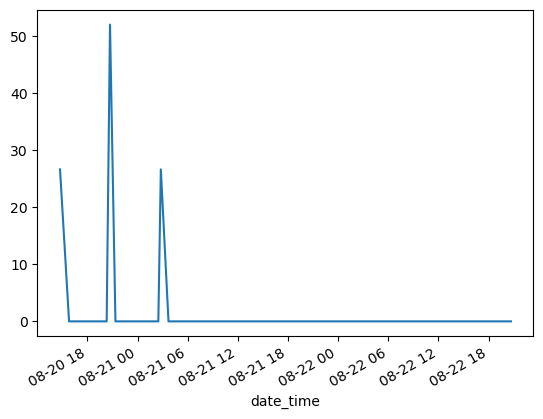

  0%|          | 4/2131 [00:14<1:29:47,  2.53s/it]

QC passed, flag = 0


  0%|          | 5/2131 [00:16<1:23:00,  2.34s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


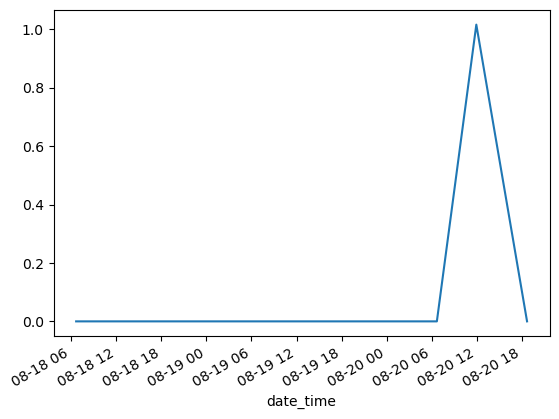

  0%|          | 7/2131 [00:21<1:33:58,  2.65s/it]

QC passed, flag = 0


  0%|          | 8/2131 [00:26<1:57:11,  3.31s/it]

QC passed, flag = 0


  0%|          | 9/2131 [00:29<1:54:20,  3.23s/it]

QC passed, flag = 0


  0%|          | 10/2131 [00:30<1:32:21,  2.61s/it]

QC passed, flag = 0


  1%|          | 11/2131 [00:32<1:20:55,  2.29s/it]

QC passed, flag = 0


  1%|          | 12/2131 [00:35<1:31:33,  2.59s/it]

QC passed, flag = 0


  1%|          | 13/2131 [00:36<1:17:28,  2.19s/it]

QC passed, flag = 0


  1%|          | 14/2131 [00:38<1:09:09,  1.96s/it]

QC passed, flag = 0


  1%|          | 15/2131 [00:39<1:01:49,  1.75s/it]

QC passed, flag = 0


  1%|          | 16/2131 [00:40<58:52,  1.67s/it]  

QC passed, flag = 0


  1%|          | 17/2131 [00:42<57:24,  1.63s/it]

QC passed, flag = 0


  1%|          | 18/2131 [00:43<53:01,  1.51s/it]

QC passed, flag = 0


  1%|          | 19/2131 [00:53<2:19:41,  3.97s/it]

QC passed, flag = 0


  1%|          | 20/2131 [00:55<1:56:29,  3.31s/it]

QC passed, flag = 0


  1%|          | 21/2131 [00:56<1:38:52,  2.81s/it]

QC passed, flag = 0


  1%|          | 22/2131 [00:58<1:21:52,  2.33s/it]

QC passed, flag = 0


  1%|          | 23/2131 [01:04<2:06:12,  3.59s/it]

QC passed, flag = 0


  1%|          | 24/2131 [01:12<2:50:47,  4.86s/it]

QC passed, flag = 0


  1%|          | 25/2131 [01:18<3:05:06,  5.27s/it]

QC passed, flag = 0


  1%|          | 26/2131 [01:34<4:52:38,  8.34s/it]

QC passed, flag = 0


  1%|▏         | 27/2131 [01:39<4:17:52,  7.35s/it]

QC passed, flag = 0


  1%|▏         | 28/2131 [01:44<3:57:48,  6.79s/it]

QC passed, flag = 0


  1%|▏         | 29/2131 [01:49<3:37:26,  6.21s/it]

QC passed, flag = 0


  1%|▏         | 30/2131 [01:51<2:54:34,  4.99s/it]

QC passed, flag = 0


  1%|▏         | 31/2131 [01:56<2:57:52,  5.08s/it]

QC passed, flag = 0


  2%|▏         | 32/2131 [02:01<2:52:52,  4.94s/it]

QC passed, flag = 0


  2%|▏         | 33/2131 [02:16<4:36:09,  7.90s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


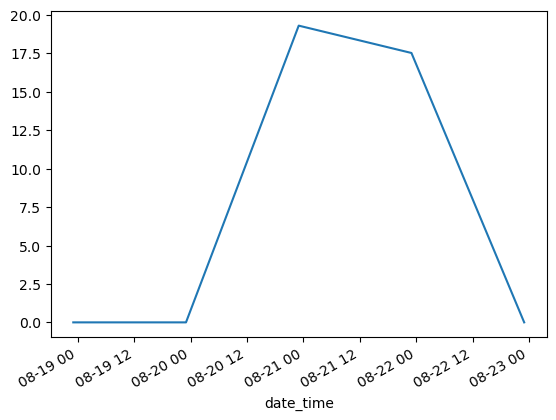

  2%|▏         | 34/2131 [02:16<3:18:50,  5.69s/it]

QC fail with flag: 1 - not hourly


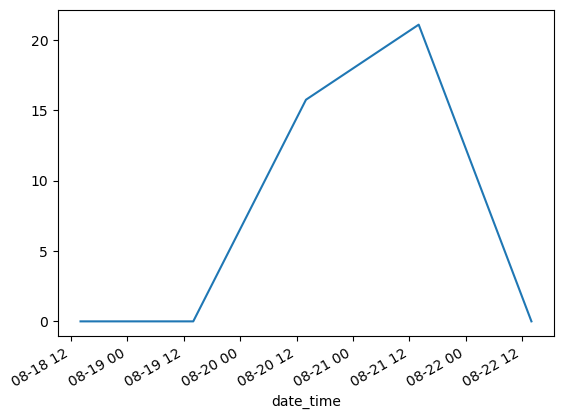

  2%|▏         | 35/2131 [02:17<2:21:10,  4.04s/it]

QC fail with flag: 1 - not hourly


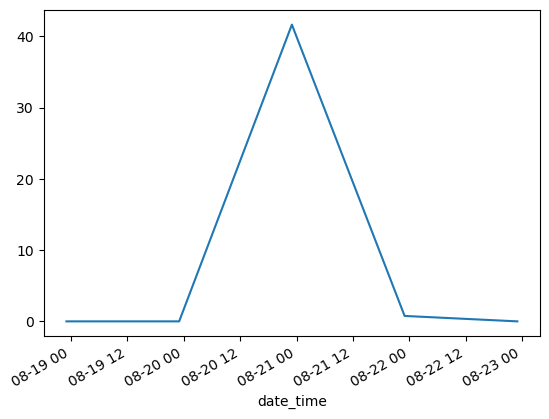

  2%|▏         | 37/2131 [02:22<2:05:44,  3.60s/it]

QC passed, flag = 0


  2%|▏         | 38/2131 [02:26<2:12:03,  3.79s/it]

QC passed, flag = 0


  2%|▏         | 39/2131 [02:31<2:17:36,  3.95s/it]

QC passed, flag = 0


  2%|▏         | 40/2131 [02:36<2:31:54,  4.36s/it]

QC passed, flag = 0


  2%|▏         | 41/2131 [02:40<2:33:58,  4.42s/it]

QC passed, flag = 0


  2%|▏         | 42/2131 [02:49<3:20:08,  5.75s/it]

QC passed, flag = 0


  2%|▏         | 43/2131 [02:54<3:06:42,  5.37s/it]

QC passed, flag = 0


  2%|▏         | 44/2131 [02:59<3:05:17,  5.33s/it]

QC passed, flag = 0


  2%|▏         | 45/2131 [03:00<2:23:22,  4.12s/it]

QC passed, flag = 0


  2%|▏         | 46/2131 [03:02<1:58:43,  3.42s/it]

QC passed, flag = 0


  2%|▏         | 47/2131 [03:04<1:42:39,  2.96s/it]

QC passed, flag = 0


  2%|▏         | 48/2131 [03:06<1:32:21,  2.66s/it]

QC passed, flag = 0


  2%|▏         | 49/2131 [03:07<1:20:12,  2.31s/it]

QC passed, flag = 0


  2%|▏         | 50/2131 [03:09<1:14:15,  2.14s/it]

QC passed, flag = 0


  2%|▏         | 51/2131 [03:16<1:58:49,  3.43s/it]

QC passed, flag = 0
QC fail with flag: 2 - negative readings


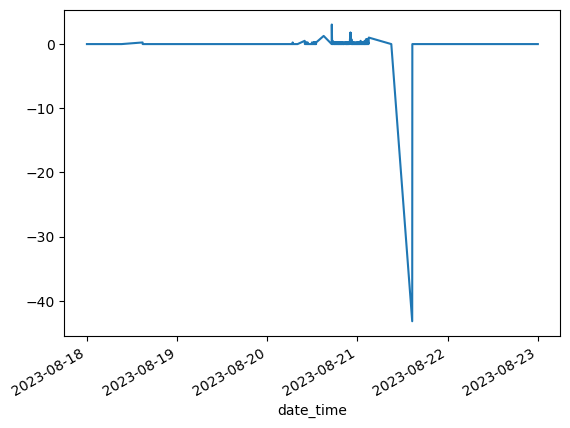

  2%|▏         | 53/2131 [03:33<3:12:16,  5.55s/it]

QC passed, flag = 0


  3%|▎         | 54/2131 [03:36<2:49:14,  4.89s/it]

QC passed, flag = 0


  3%|▎         | 55/2131 [03:52<4:34:52,  7.94s/it]

QC passed, flag = 0


  3%|▎         | 56/2131 [04:06<5:41:43,  9.88s/it]

QC passed, flag = 0


  3%|▎         | 57/2131 [04:11<4:53:37,  8.49s/it]

QC passed, flag = 0


  3%|▎         | 58/2131 [04:30<6:38:18, 11.53s/it]

QC passed, flag = 0


  3%|▎         | 59/2131 [04:33<5:08:11,  8.92s/it]

QC passed, flag = 0


  3%|▎         | 60/2131 [04:35<4:03:51,  7.06s/it]

QC passed, flag = 0


  3%|▎         | 61/2131 [04:37<3:08:54,  5.48s/it]

QC passed, flag = 0


  3%|▎         | 62/2131 [04:41<2:49:39,  4.92s/it]

QC passed, flag = 0


  3%|▎         | 63/2131 [04:43<2:25:01,  4.21s/it]

QC passed, flag = 0


  3%|▎         | 64/2131 [04:44<1:53:22,  3.29s/it]

QC passed, flag = 0


  3%|▎         | 65/2131 [04:46<1:31:10,  2.65s/it]

QC passed, flag = 0


  3%|▎         | 66/2131 [04:47<1:17:52,  2.26s/it]

QC passed, flag = 0


  3%|▎         | 67/2131 [04:48<1:09:05,  2.01s/it]

QC passed, flag = 0


  3%|▎         | 68/2131 [04:50<1:02:52,  1.83s/it]

QC passed, flag = 0


  3%|▎         | 69/2131 [04:51<56:20,  1.64s/it]  

QC passed, flag = 0


  3%|▎         | 70/2131 [04:52<52:03,  1.52s/it]

QC passed, flag = 0


  3%|▎         | 71/2131 [05:07<3:10:20,  5.54s/it]

QC passed, flag = 0


  3%|▎         | 72/2131 [05:09<2:32:29,  4.44s/it]

QC passed, flag = 0


  3%|▎         | 73/2131 [05:10<2:01:10,  3.53s/it]

QC passed, flag = 0


  3%|▎         | 74/2131 [05:12<1:39:10,  2.89s/it]

QC passed, flag = 0


  4%|▎         | 75/2131 [05:29<4:09:49,  7.29s/it]

QC passed, flag = 0


  4%|▎         | 76/2131 [05:45<5:37:59,  9.87s/it]

QC passed, flag = 0


  4%|▎         | 77/2131 [06:01<6:33:31, 11.50s/it]

QC passed, flag = 0


  4%|▎         | 78/2131 [06:02<4:53:17,  8.57s/it]

QC passed, flag = 0


  4%|▎         | 79/2131 [06:10<4:42:29,  8.26s/it]

QC passed, flag = 0


  4%|▍         | 80/2131 [06:17<4:30:12,  7.90s/it]

QC passed, flag = 0


  4%|▍         | 81/2131 [06:37<6:36:56, 11.62s/it]

QC passed, flag = 0


  4%|▍         | 82/2131 [06:39<4:56:56,  8.70s/it]

QC passed, flag = 0


  4%|▍         | 83/2131 [06:40<3:40:21,  6.46s/it]

QC passed, flag = 0


  4%|▍         | 84/2131 [06:42<2:50:04,  4.99s/it]

QC passed, flag = 0


  4%|▍         | 85/2131 [06:43<2:12:39,  3.89s/it]

QC passed, flag = 0


  4%|▍         | 86/2131 [06:50<2:40:14,  4.70s/it]

QC passed, flag = 0


  4%|▍         | 87/2131 [06:54<2:39:51,  4.69s/it]

QC passed, flag = 0


  4%|▍         | 88/2131 [07:14<5:10:56,  9.13s/it]

QC passed, flag = 0


  4%|▍         | 89/2131 [07:16<3:57:12,  6.97s/it]

QC passed, flag = 0


  4%|▍         | 90/2131 [07:22<3:51:34,  6.81s/it]

QC passed, flag = 0


  4%|▍         | 91/2131 [07:41<5:48:12, 10.24s/it]

QC passed, flag = 0


  4%|▍         | 92/2131 [07:46<5:02:20,  8.90s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


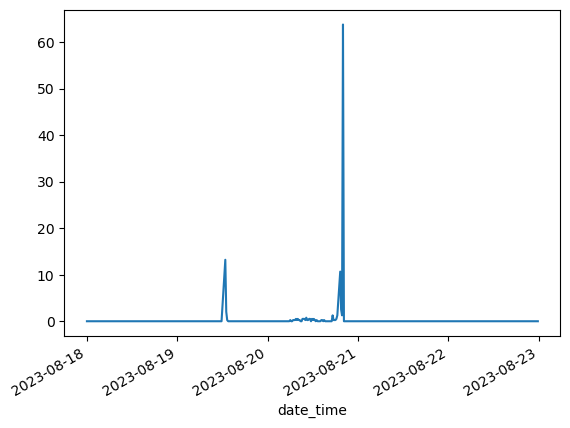

  4%|▍         | 94/2131 [08:06<5:35:20,  9.88s/it]

QC passed, flag = 0


  4%|▍         | 95/2131 [08:11<4:48:36,  8.50s/it]

QC passed, flag = 0


  5%|▍         | 96/2131 [08:17<4:15:35,  7.54s/it]

QC passed, flag = 0


  5%|▍         | 97/2131 [08:22<3:51:47,  6.84s/it]

QC passed, flag = 0


  5%|▍         | 98/2131 [08:26<3:25:25,  6.06s/it]

QC passed, flag = 0


  5%|▍         | 99/2131 [08:41<4:54:42,  8.70s/it]

QC passed, flag = 0


  5%|▍         | 100/2131 [08:46<4:19:01,  7.65s/it]

QC passed, flag = 0


  5%|▍         | 101/2131 [08:55<4:31:53,  8.04s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


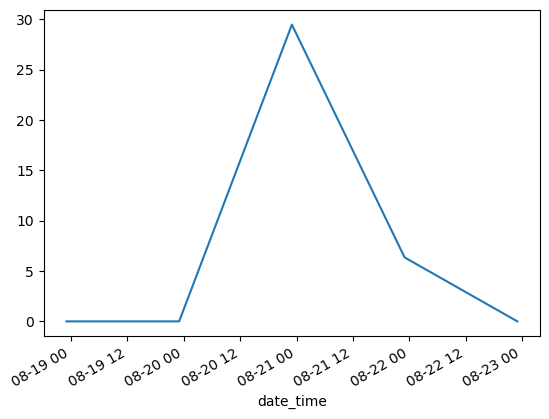

  5%|▍         | 102/2131 [08:56<3:15:11,  5.77s/it]

QC fail with flag: 1 - not hourly


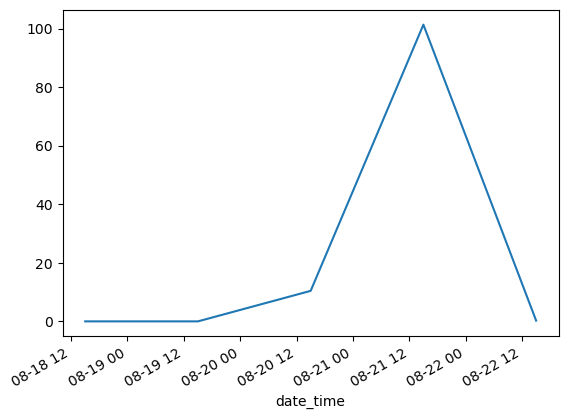

  5%|▍         | 103/2131 [08:56<2:18:14,  4.09s/it]

QC fail with flag: 1 - not hourly


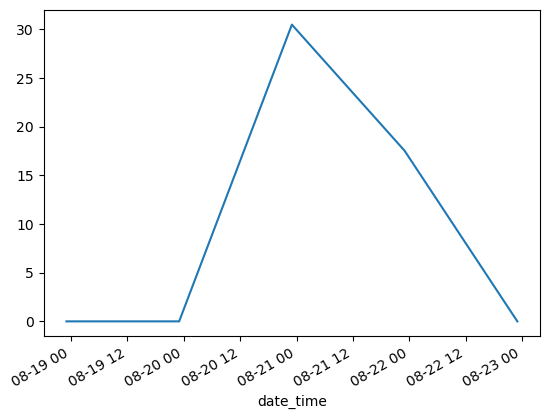

  5%|▍         | 104/2131 [08:56<1:38:38,  2.92s/it]

QC fail with flag: 1 - not hourly


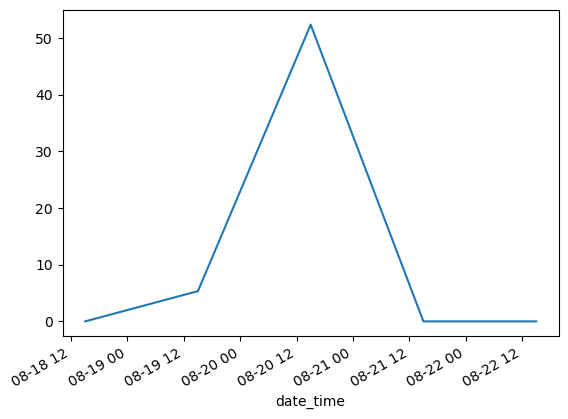

  5%|▍         | 105/2131 [08:56<1:11:16,  2.11s/it]

QC fail with flag: 1 - not hourly


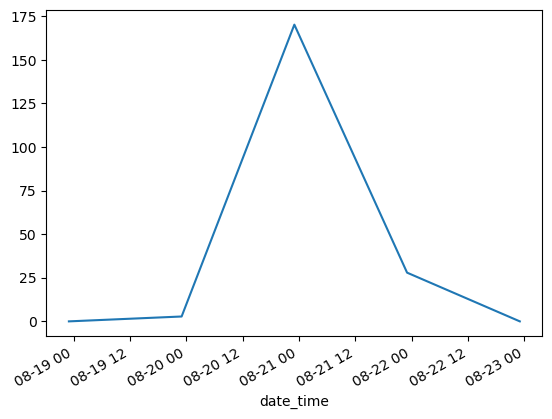

  5%|▍         | 106/2131 [08:56<52:42,  1.56s/it]  

QC fail with flag: 1 - not hourly


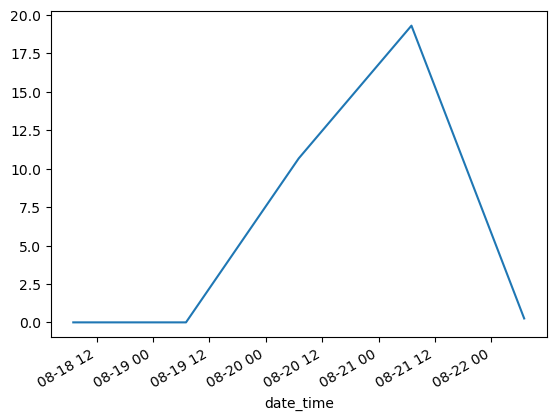

  5%|▌         | 108/2131 [09:01<1:14:23,  2.21s/it]

QC passed, flag = 0


  5%|▌         | 109/2131 [09:16<3:21:40,  5.98s/it]

QC passed, flag = 0


  5%|▌         | 110/2131 [09:22<3:19:43,  5.93s/it]

QC passed, flag = 0


  5%|▌         | 111/2131 [09:27<3:09:12,  5.62s/it]

QC passed, flag = 0


  5%|▌         | 112/2131 [09:31<2:53:45,  5.16s/it]

QC passed, flag = 0


  5%|▌         | 113/2131 [09:36<2:49:00,  5.03s/it]

QC passed, flag = 0


  5%|▌         | 114/2131 [09:41<2:56:45,  5.26s/it]

QC passed, flag = 0


  5%|▌         | 115/2131 [09:47<2:56:41,  5.26s/it]

QC passed, flag = 0


  5%|▌         | 116/2131 [09:51<2:47:08,  4.98s/it]

QC passed, flag = 0


  5%|▌         | 117/2131 [09:53<2:20:34,  4.19s/it]

QC passed, flag = 0


  6%|▌         | 118/2131 [09:57<2:11:43,  3.93s/it]

QC passed, flag = 0


  6%|▌         | 119/2131 [09:59<1:52:28,  3.35s/it]

QC passed, flag = 0


  6%|▌         | 120/2131 [10:02<1:51:10,  3.32s/it]

QC passed, flag = 0


  6%|▌         | 121/2131 [10:07<2:07:59,  3.82s/it]

QC passed, flag = 0


  6%|▌         | 122/2131 [10:09<1:51:50,  3.34s/it]

QC passed, flag = 0


  6%|▌         | 123/2131 [10:12<1:44:49,  3.13s/it]

QC passed, flag = 0


  6%|▌         | 124/2131 [10:14<1:34:18,  2.82s/it]

QC passed, flag = 0


  6%|▌         | 125/2131 [10:16<1:27:47,  2.63s/it]

QC passed, flag = 0


  6%|▌         | 126/2131 [10:18<1:22:28,  2.47s/it]

QC passed, flag = 0


  6%|▌         | 127/2131 [10:22<1:33:38,  2.80s/it]

QC passed, flag = 0


  6%|▌         | 128/2131 [10:23<1:21:29,  2.44s/it]

QC passed, flag = 0


  6%|▌         | 129/2131 [10:26<1:24:03,  2.52s/it]

QC passed, flag = 0


  6%|▌         | 130/2131 [10:28<1:17:43,  2.33s/it]

QC passed, flag = 0


  6%|▌         | 131/2131 [10:30<1:11:00,  2.13s/it]

QC passed, flag = 0


  6%|▌         | 132/2131 [10:45<3:28:49,  6.27s/it]

QC passed, flag = 0


  6%|▌         | 133/2131 [10:51<3:17:07,  5.92s/it]

QC passed, flag = 0


  6%|▋         | 134/2131 [10:56<3:07:00,  5.62s/it]

QC passed, flag = 0
QC fail with flag: 3 - intensity greater than 1000 year retun interval


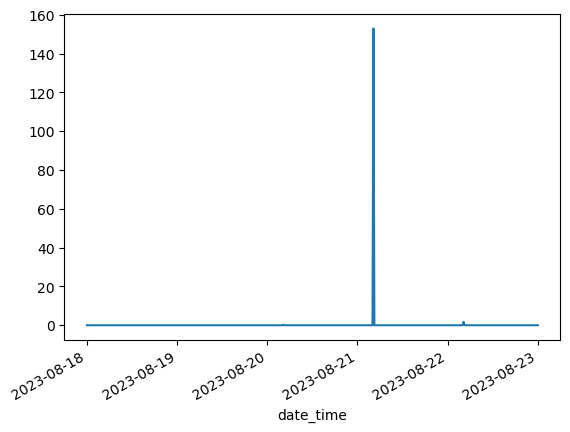

  6%|▋         | 136/2131 [10:58<2:00:30,  3.62s/it]

QC passed, flag = 0


  6%|▋         | 137/2131 [11:05<2:28:16,  4.46s/it]

QC passed, flag = 0


  6%|▋         | 138/2131 [11:18<3:57:32,  7.15s/it]

QC passed, flag = 0


  7%|▋         | 139/2131 [11:32<5:02:58,  9.13s/it]

QC passed, flag = 0


  7%|▋         | 140/2131 [11:38<4:31:08,  8.17s/it]

QC passed, flag = 0


  7%|▋         | 141/2131 [11:47<4:39:20,  8.42s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


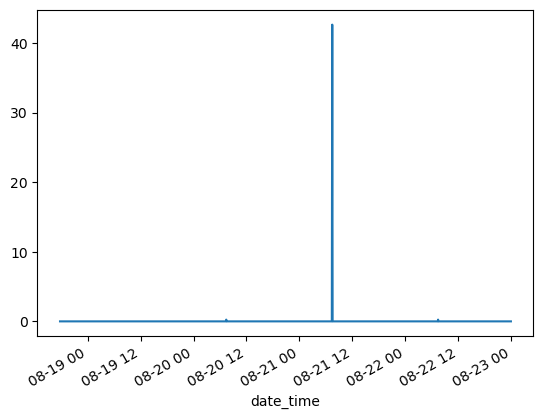

  7%|▋         | 143/2131 [11:51<2:58:52,  5.40s/it]

QC passed, flag = 0


  7%|▋         | 144/2131 [12:06<4:28:40,  8.11s/it]

QC passed, flag = 0


  7%|▋         | 145/2131 [12:11<4:04:05,  7.37s/it]

QC passed, flag = 0


  7%|▋         | 146/2131 [12:12<2:54:43,  5.28s/it]

QC passed, flag = 0


  7%|▋         | 147/2131 [12:25<4:15:24,  7.72s/it]

QC passed, flag = 0


  7%|▋         | 148/2131 [12:39<5:17:57,  9.62s/it]

QC passed, flag = 0


  7%|▋         | 149/2131 [12:58<6:51:48, 12.47s/it]

QC passed, flag = 0


  7%|▋         | 150/2131 [13:13<7:08:12, 12.97s/it]

QC passed, flag = 0


  7%|▋         | 151/2131 [13:18<5:49:04, 10.58s/it]

QC passed, flag = 0


  7%|▋         | 152/2131 [13:21<4:37:55,  8.43s/it]

QC passed, flag = 0


  7%|▋         | 153/2131 [13:23<3:36:28,  6.57s/it]

QC passed, flag = 0


  7%|▋         | 154/2131 [13:25<2:51:05,  5.19s/it]

QC passed, flag = 0


  7%|▋         | 155/2131 [13:26<2:11:14,  3.99s/it]

QC passed, flag = 0


  7%|▋         | 156/2131 [13:27<1:43:18,  3.14s/it]

QC passed, flag = 0


  7%|▋         | 157/2131 [13:29<1:23:23,  2.53s/it]

QC passed, flag = 0


  7%|▋         | 158/2131 [13:30<1:09:29,  2.11s/it]

QC passed, flag = 0


  7%|▋         | 159/2131 [13:31<59:58,  1.82s/it]  

QC passed, flag = 0


  8%|▊         | 160/2131 [13:32<52:51,  1.61s/it]

QC passed, flag = 0


  8%|▊         | 161/2131 [13:53<4:01:42,  7.36s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


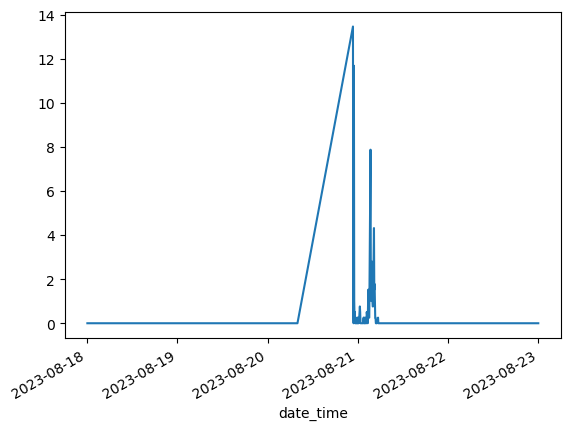

  8%|▊         | 163/2131 [14:13<4:57:49,  9.08s/it]

QC passed, flag = 0


  8%|▊         | 164/2131 [14:21<4:44:22,  8.67s/it]

QC passed, flag = 0


  8%|▊         | 165/2131 [14:27<4:17:15,  7.85s/it]

QC passed, flag = 0


  8%|▊         | 166/2131 [14:46<6:07:02, 11.21s/it]

QC passed, flag = 0


  8%|▊         | 167/2131 [15:00<6:35:30, 12.08s/it]

QC passed, flag = 0


  8%|▊         | 168/2131 [15:01<4:48:09,  8.81s/it]

QC passed, flag = 0


  8%|▊         | 169/2131 [15:06<4:08:56,  7.61s/it]

QC passed, flag = 0


  8%|▊         | 170/2131 [15:13<4:02:29,  7.42s/it]

QC passed, flag = 0


  8%|▊         | 171/2131 [15:27<5:05:28,  9.35s/it]

QC passed, flag = 0


  8%|▊         | 172/2131 [15:33<4:38:45,  8.54s/it]

QC passed, flag = 0


  8%|▊         | 173/2131 [15:35<3:27:28,  6.36s/it]

QC passed, flag = 0


  8%|▊         | 174/2131 [15:37<2:50:16,  5.22s/it]

QC passed, flag = 0


  8%|▊         | 175/2131 [15:42<2:44:00,  5.03s/it]

QC passed, flag = 0


  8%|▊         | 176/2131 [15:47<2:43:08,  5.01s/it]

QC passed, flag = 0


  8%|▊         | 177/2131 [15:51<2:40:08,  4.92s/it]

QC passed, flag = 0


  8%|▊         | 178/2131 [15:53<2:04:02,  3.81s/it]

QC passed, flag = 0


  8%|▊         | 179/2131 [15:56<2:00:44,  3.71s/it]

QC passed, flag = 0
QC passed, flag = 0


  8%|▊         | 181/2131 [16:01<1:39:53,  3.07s/it]

QC passed, flag = 0


  9%|▊         | 182/2131 [16:05<1:50:34,  3.40s/it]

QC passed, flag = 0


  9%|▊         | 183/2131 [16:20<3:25:03,  6.32s/it]

QC passed, flag = 0


  9%|▊         | 184/2131 [16:25<3:15:32,  6.03s/it]

QC passed, flag = 0


  9%|▊         | 185/2131 [16:37<4:15:12,  7.87s/it]

QC passed, flag = 0


  9%|▊         | 186/2131 [16:44<4:05:32,  7.57s/it]

QC passed, flag = 0


  9%|▉         | 187/2131 [16:46<3:09:23,  5.85s/it]

QC passed, flag = 0


  9%|▉         | 188/2131 [16:49<2:45:34,  5.11s/it]

QC passed, flag = 0


  9%|▉         | 189/2131 [17:03<4:06:03,  7.60s/it]

QC passed, flag = 0


  9%|▉         | 190/2131 [17:07<3:37:26,  6.72s/it]

QC passed, flag = 0


  9%|▉         | 191/2131 [17:23<5:02:58,  9.37s/it]

QC passed, flag = 0


  9%|▉         | 192/2131 [17:46<7:17:10, 13.53s/it]

QC passed, flag = 0


  9%|▉         | 193/2131 [17:51<5:54:14, 10.97s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


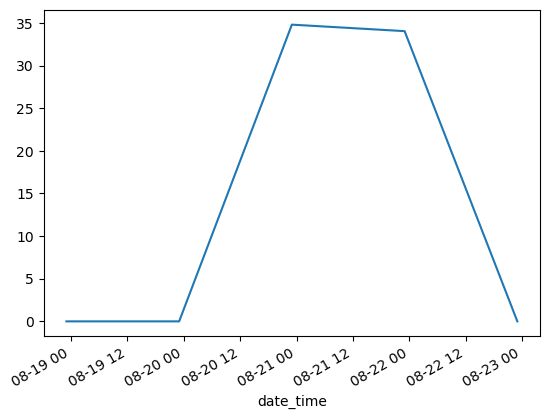

  9%|▉         | 194/2131 [17:52<4:11:15,  7.78s/it]

QC fail with flag: 1 - not hourly


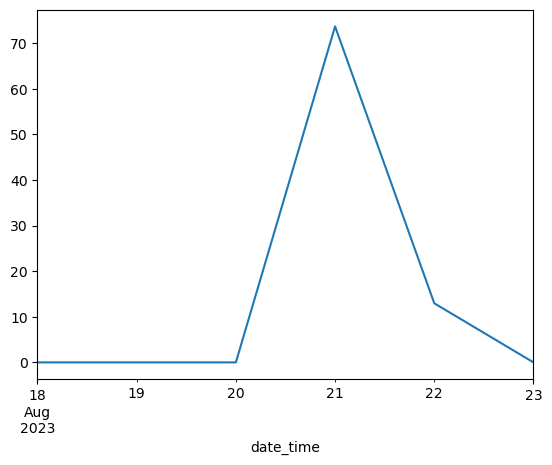

  9%|▉         | 195/2131 [17:52<2:58:28,  5.53s/it]

QC fail with flag: 1 - not hourly


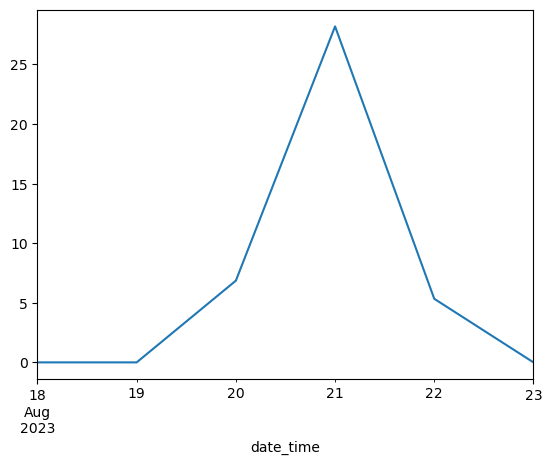

  9%|▉         | 196/2131 [17:52<2:06:26,  3.92s/it]

QC fail with flag: 1 - not hourly


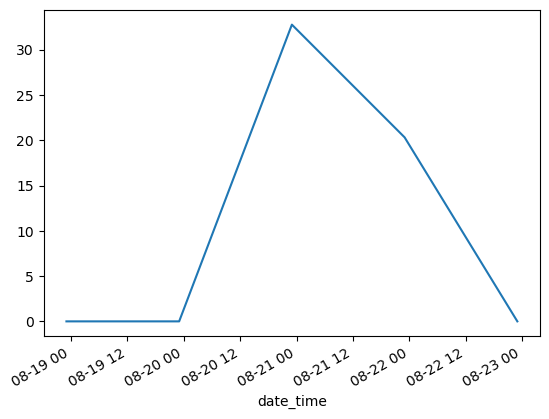

  9%|▉         | 198/2131 [18:02<2:40:37,  4.99s/it]

QC passed, flag = 0


  9%|▉         | 199/2131 [18:14<3:46:51,  7.05s/it]

QC passed, flag = 0


  9%|▉         | 200/2131 [18:29<5:00:56,  9.35s/it]

QC passed, flag = 0


  9%|▉         | 201/2131 [18:33<4:12:19,  7.84s/it]

QC passed, flag = 0


  9%|▉         | 202/2131 [18:37<3:31:34,  6.58s/it]

QC passed, flag = 0


 10%|▉         | 203/2131 [18:37<2:32:15,  4.74s/it]

QC passed, flag = 0


 10%|▉         | 204/2131 [18:39<2:06:06,  3.93s/it]

QC passed, flag = 0


 10%|▉         | 205/2131 [18:41<1:43:32,  3.23s/it]

QC passed, flag = 0


 10%|▉         | 206/2131 [18:42<1:25:22,  2.66s/it]

QC passed, flag = 0


 10%|▉         | 207/2131 [18:44<1:13:27,  2.29s/it]

QC passed, flag = 0


 10%|▉         | 208/2131 [18:45<1:06:11,  2.07s/it]

QC passed, flag = 0


 10%|▉         | 209/2131 [18:47<1:01:25,  1.92s/it]

QC passed, flag = 0


 10%|▉         | 210/2131 [18:48<57:55,  1.81s/it]  

QC passed, flag = 0


 10%|▉         | 211/2131 [18:50<51:37,  1.61s/it]

QC passed, flag = 0


 10%|▉         | 212/2131 [18:50<44:34,  1.39s/it]

QC passed, flag = 0


 10%|▉         | 213/2131 [18:51<37:47,  1.18s/it]

QC passed, flag = 0


 10%|█         | 214/2131 [18:53<40:48,  1.28s/it]

QC passed, flag = 0


 10%|█         | 215/2131 [18:54<41:33,  1.30s/it]

QC passed, flag = 0


 10%|█         | 216/2131 [18:55<41:39,  1.31s/it]

QC passed, flag = 0


 10%|█         | 217/2131 [18:56<40:11,  1.26s/it]

QC passed, flag = 0


 10%|█         | 218/2131 [18:58<42:48,  1.34s/it]

QC passed, flag = 0


 10%|█         | 219/2131 [19:05<1:39:33,  3.12s/it]

QC passed, flag = 0


 10%|█         | 220/2131 [19:19<3:21:33,  6.33s/it]

QC passed, flag = 0


 10%|█         | 221/2131 [19:24<3:07:42,  5.90s/it]

QC passed, flag = 0


 10%|█         | 222/2131 [19:37<4:20:25,  8.19s/it]

QC passed, flag = 0


 10%|█         | 223/2131 [19:42<3:48:38,  7.19s/it]

QC passed, flag = 0


 11%|█         | 224/2131 [19:56<4:52:15,  9.20s/it]

QC passed, flag = 0


 11%|█         | 225/2131 [20:10<5:33:03, 10.48s/it]

QC passed, flag = 0


 11%|█         | 226/2131 [20:24<6:08:07, 11.59s/it]

QC passed, flag = 0


 11%|█         | 227/2131 [20:28<4:56:47,  9.35s/it]

QC passed, flag = 0


 11%|█         | 228/2131 [20:29<3:36:29,  6.83s/it]

QC passed, flag = 0


 11%|█         | 229/2131 [20:43<4:47:52,  9.08s/it]

QC passed, flag = 0


 11%|█         | 230/2131 [20:47<3:57:28,  7.50s/it]

QC passed, flag = 0


 11%|█         | 231/2131 [20:49<3:02:01,  5.75s/it]

QC passed, flag = 0


 11%|█         | 232/2131 [20:50<2:22:29,  4.50s/it]

QC passed, flag = 0


 11%|█         | 233/2131 [20:51<1:50:09,  3.48s/it]

QC passed, flag = 0


 11%|█         | 234/2131 [20:53<1:27:27,  2.77s/it]

QC passed, flag = 0


 11%|█         | 235/2131 [20:54<1:11:33,  2.26s/it]

QC passed, flag = 0


 11%|█         | 236/2131 [20:55<1:00:23,  1.91s/it]

QC passed, flag = 0


 11%|█         | 237/2131 [20:56<52:34,  1.67s/it]  

QC passed, flag = 0


 11%|█         | 238/2131 [20:57<47:08,  1.49s/it]

QC passed, flag = 0


 11%|█         | 239/2131 [20:58<43:18,  1.37s/it]

QC passed, flag = 0


 11%|█▏        | 240/2131 [21:01<1:01:49,  1.96s/it]

QC passed, flag = 0


 11%|█▏        | 241/2131 [21:07<1:38:26,  3.13s/it]

QC passed, flag = 0


 11%|█▏        | 242/2131 [21:13<2:06:24,  4.02s/it]

QC passed, flag = 0


 11%|█▏        | 243/2131 [21:17<2:07:03,  4.04s/it]

QC passed, flag = 0


 11%|█▏        | 244/2131 [21:21<2:03:03,  3.91s/it]

QC passed, flag = 0


 11%|█▏        | 245/2131 [21:25<1:59:56,  3.82s/it]

QC passed, flag = 0


 12%|█▏        | 246/2131 [21:26<1:36:01,  3.06s/it]

QC passed, flag = 0


 12%|█▏        | 247/2131 [21:31<1:55:02,  3.66s/it]

QC passed, flag = 0


 12%|█▏        | 249/2131 [21:32<1:04:39,  2.06s/it]

QC passed, flag = 0
QC passed, flag = 0


 12%|█▏        | 250/2131 [21:34<59:01,  1.88s/it]  

QC passed, flag = 0


 12%|█▏        | 251/2131 [21:38<1:23:48,  2.67s/it]

QC passed, flag = 0


 12%|█▏        | 252/2131 [21:45<2:02:27,  3.91s/it]

QC passed, flag = 0


 12%|█▏        | 253/2131 [21:51<2:24:34,  4.62s/it]

QC passed, flag = 0


 12%|█▏        | 254/2131 [21:58<2:40:47,  5.14s/it]

QC passed, flag = 0


 12%|█▏        | 255/2131 [22:03<2:41:38,  5.17s/it]

QC passed, flag = 0


 12%|█▏        | 256/2131 [22:17<4:10:17,  8.01s/it]

QC passed, flag = 0


 12%|█▏        | 257/2131 [22:18<2:57:11,  5.67s/it]

QC passed, flag = 0


 12%|█▏        | 258/2131 [22:23<2:49:03,  5.42s/it]

QC passed, flag = 0


 12%|█▏        | 259/2131 [22:29<2:58:54,  5.73s/it]

QC passed, flag = 0


 12%|█▏        | 260/2131 [22:32<2:36:25,  5.02s/it]

QC passed, flag = 0


 12%|█▏        | 261/2131 [22:33<2:00:06,  3.85s/it]

QC passed, flag = 0


 12%|█▏        | 262/2131 [22:35<1:34:34,  3.04s/it]

QC passed, flag = 0


 12%|█▏        | 263/2131 [22:42<2:11:14,  4.22s/it]

QC passed, flag = 0


 12%|█▏        | 264/2131 [22:43<1:43:03,  3.31s/it]

QC passed, flag = 0


 12%|█▏        | 265/2131 [22:47<1:51:03,  3.57s/it]

QC passed, flag = 0


 12%|█▏        | 266/2131 [22:48<1:28:17,  2.84s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


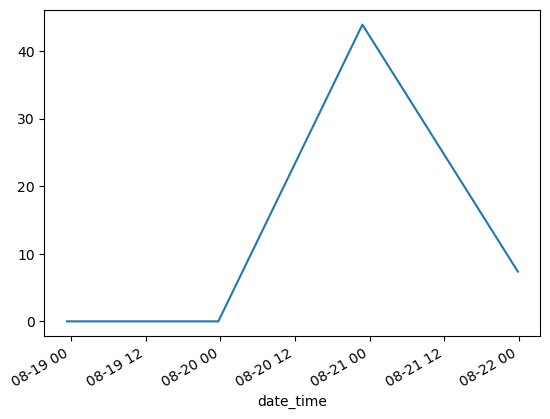

 13%|█▎        | 267/2131 [22:48<1:04:47,  2.09s/it]

QC fail with flag: 1 - not hourly


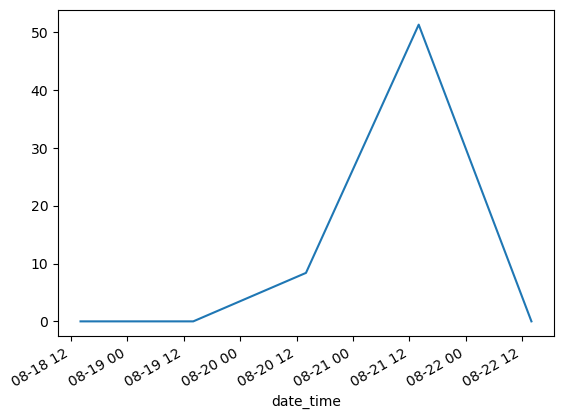

 13%|█▎        | 268/2131 [22:49<46:58,  1.51s/it]  

QC fail with flag: 1 - not hourly


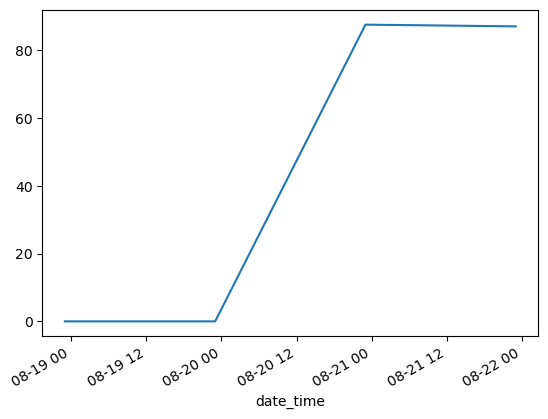

 13%|█▎        | 269/2131 [22:49<34:12,  1.10s/it]

QC fail with flag: 1 - not hourly


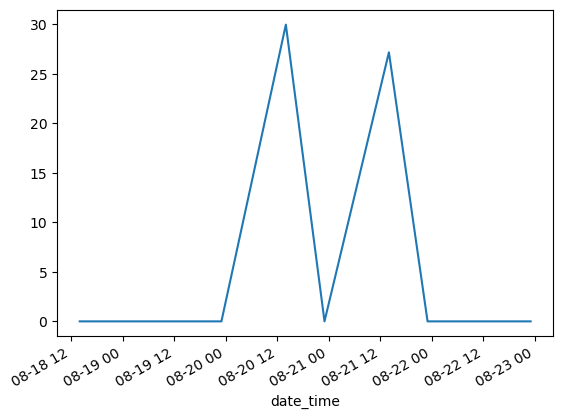

 13%|█▎        | 271/2131 [22:54<1:03:35,  2.05s/it]

QC passed, flag = 0


 13%|█▎        | 272/2131 [23:08<2:57:58,  5.74s/it]

QC passed, flag = 0


 13%|█▎        | 273/2131 [23:10<2:17:05,  4.43s/it]

QC passed, flag = 0


 13%|█▎        | 274/2131 [23:13<2:09:59,  4.20s/it]

QC passed, flag = 0


 13%|█▎        | 275/2131 [23:15<1:48:41,  3.51s/it]

QC passed, flag = 0


 13%|█▎        | 276/2131 [23:17<1:36:32,  3.12s/it]

QC passed, flag = 0


 13%|█▎        | 277/2131 [23:20<1:30:35,  2.93s/it]

QC passed, flag = 0


 13%|█▎        | 278/2131 [23:22<1:24:01,  2.72s/it]

QC passed, flag = 0


 13%|█▎        | 279/2131 [23:24<1:16:22,  2.47s/it]

QC passed, flag = 0


 13%|█▎        | 280/2131 [23:26<1:12:33,  2.35s/it]

QC passed, flag = 0


 13%|█▎        | 281/2131 [23:28<1:06:42,  2.16s/it]

QC passed, flag = 0


 13%|█▎        | 282/2131 [23:30<1:04:54,  2.11s/it]

QC passed, flag = 0


 13%|█▎        | 283/2131 [23:31<59:21,  1.93s/it]  

QC passed, flag = 0


 13%|█▎        | 284/2131 [23:33<54:11,  1.76s/it]

QC passed, flag = 0


 13%|█▎        | 285/2131 [23:34<52:48,  1.72s/it]

QC passed, flag = 0


 13%|█▎        | 286/2131 [23:36<52:12,  1.70s/it]

QC passed, flag = 0


 13%|█▎        | 287/2131 [23:38<54:44,  1.78s/it]

QC passed, flag = 0


 14%|█▎        | 288/2131 [23:38<43:18,  1.41s/it]

QC passed, flag = 0


 14%|█▎        | 289/2131 [23:40<41:44,  1.36s/it]

QC passed, flag = 0


 14%|█▎        | 290/2131 [23:41<45:27,  1.48s/it]

QC passed, flag = 0


 14%|█▎        | 291/2131 [23:43<44:47,  1.46s/it]

QC passed, flag = 0


 14%|█▎        | 292/2131 [23:45<47:33,  1.55s/it]

QC passed, flag = 0


 14%|█▎        | 293/2131 [23:46<43:15,  1.41s/it]

QC passed, flag = 0


 14%|█▍        | 294/2131 [23:47<40:37,  1.33s/it]

QC passed, flag = 0


 14%|█▍        | 295/2131 [23:55<1:41:06,  3.30s/it]

QC passed, flag = 0


 14%|█▍        | 296/2131 [23:59<1:50:50,  3.62s/it]

QC passed, flag = 0


 14%|█▍        | 297/2131 [24:11<3:04:25,  6.03s/it]

QC passed, flag = 0


 14%|█▍        | 298/2131 [24:26<4:28:43,  8.80s/it]

QC passed, flag = 0


 14%|█▍        | 299/2131 [24:40<5:15:54, 10.35s/it]

QC passed, flag = 0


 14%|█▍        | 300/2131 [24:45<4:24:35,  8.67s/it]

QC passed, flag = 0


 14%|█▍        | 301/2131 [24:48<3:38:37,  7.17s/it]

QC passed, flag = 0


 14%|█▍        | 302/2131 [24:53<3:16:16,  6.44s/it]

QC passed, flag = 0


 14%|█▍        | 303/2131 [25:08<4:29:59,  8.86s/it]

QC passed, flag = 0


 14%|█▍        | 304/2131 [25:14<4:08:47,  8.17s/it]

QC passed, flag = 0


 14%|█▍        | 305/2131 [25:16<3:06:39,  6.13s/it]

QC passed, flag = 0


 14%|█▍        | 306/2131 [25:31<4:28:46,  8.84s/it]

QC passed, flag = 0
QC fail with flag: 5.0 - accumulation greater than 1000 year return interval


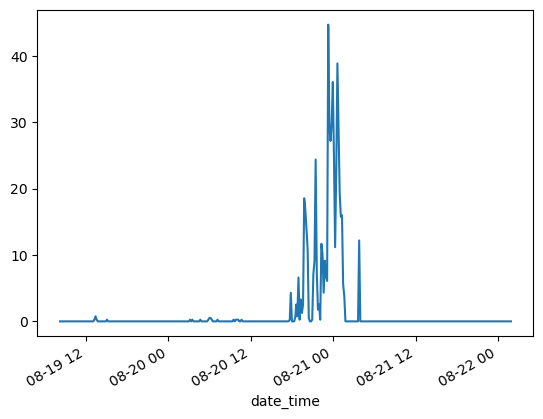

 14%|█▍        | 308/2131 [25:36<2:50:08,  5.60s/it]

QC passed, flag = 0


 15%|█▍        | 309/2131 [25:37<2:09:34,  4.27s/it]

QC passed, flag = 0


 15%|█▍        | 310/2131 [25:38<1:41:03,  3.33s/it]

QC passed, flag = 0


 15%|█▍        | 311/2131 [25:40<1:21:14,  2.68s/it]

QC passed, flag = 0


 15%|█▍        | 312/2131 [25:41<1:07:33,  2.23s/it]

QC passed, flag = 0


 15%|█▍        | 313/2131 [25:42<57:57,  1.91s/it]  

QC passed, flag = 0


 15%|█▍        | 314/2131 [25:43<51:20,  1.70s/it]

QC passed, flag = 0


 15%|█▍        | 315/2131 [25:44<46:22,  1.53s/it]

QC passed, flag = 0


 15%|█▍        | 316/2131 [25:46<42:55,  1.42s/it]

QC passed, flag = 0


 15%|█▍        | 317/2131 [26:00<2:37:21,  5.20s/it]

QC passed, flag = 0


 15%|█▍        | 318/2131 [26:02<2:14:22,  4.45s/it]

QC passed, flag = 0


 15%|█▍        | 319/2131 [26:13<3:15:09,  6.46s/it]

QC passed, flag = 0


 15%|█▌        | 320/2131 [26:18<2:54:53,  5.79s/it]

QC passed, flag = 0


 15%|█▌        | 321/2131 [26:19<2:13:57,  4.44s/it]

QC passed, flag = 0


 15%|█▌        | 322/2131 [26:23<2:13:10,  4.42s/it]

QC passed, flag = 0


 15%|█▌        | 323/2131 [26:38<3:42:57,  7.40s/it]

QC passed, flag = 0


 15%|█▌        | 324/2131 [26:44<3:29:33,  6.96s/it]

QC passed, flag = 0


 15%|█▌        | 325/2131 [26:47<2:56:59,  5.88s/it]

QC passed, flag = 0


 15%|█▌        | 326/2131 [27:01<4:09:55,  8.31s/it]

QC passed, flag = 0


 15%|█▌        | 327/2131 [27:02<3:07:01,  6.22s/it]

QC passed, flag = 0


 15%|█▌        | 328/2131 [27:07<2:51:55,  5.72s/it]

QC passed, flag = 0


 15%|█▌        | 329/2131 [27:08<2:11:14,  4.37s/it]

QC passed, flag = 0


 15%|█▌        | 330/2131 [27:09<1:42:01,  3.40s/it]

QC passed, flag = 0


 16%|█▌        | 331/2131 [27:22<3:03:40,  6.12s/it]

QC passed, flag = 0


 16%|█▌        | 332/2131 [27:26<2:50:41,  5.69s/it]

QC passed, flag = 0


 16%|█▌        | 333/2131 [27:33<2:58:17,  5.95s/it]

QC passed, flag = 0


 16%|█▌        | 334/2131 [27:37<2:41:44,  5.40s/it]

QC passed, flag = 0


 16%|█▌        | 335/2131 [27:38<2:02:39,  4.10s/it]

QC passed, flag = 0


 16%|█▌        | 336/2131 [27:41<1:56:14,  3.89s/it]

QC passed, flag = 0


 16%|█▌        | 337/2131 [27:45<1:57:22,  3.93s/it]

QC passed, flag = 0


 16%|█▌        | 338/2131 [27:47<1:31:53,  3.07s/it]

QC passed, flag = 0


 16%|█▌        | 339/2131 [27:48<1:14:05,  2.48s/it]

QC passed, flag = 0


 16%|█▌        | 340/2131 [27:52<1:30:01,  3.02s/it]

QC passed, flag = 0


 16%|█▌        | 341/2131 [27:53<1:12:49,  2.44s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


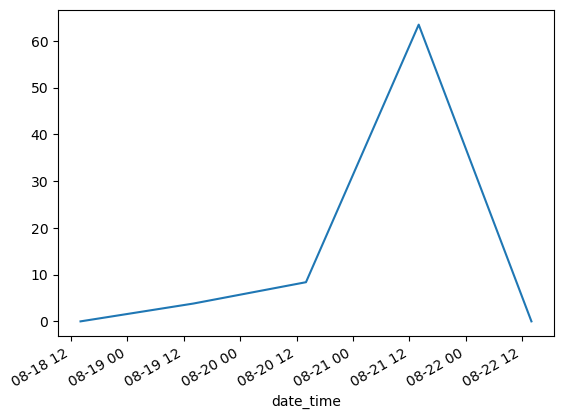

 16%|█▌        | 342/2131 [27:53<54:58,  1.84s/it]  

QC fail with flag: 1 - not hourly


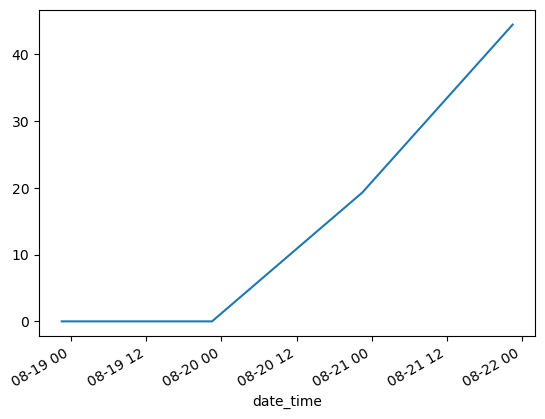

 16%|█▌        | 344/2131 [28:09<2:45:21,  5.55s/it]

QC passed, flag = 0


 16%|█▌        | 345/2131 [28:10<2:08:15,  4.31s/it]

QC passed, flag = 0


 16%|█▌        | 346/2131 [28:23<3:22:26,  6.80s/it]

QC passed, flag = 0


 16%|█▋        | 347/2131 [28:37<4:25:44,  8.94s/it]

QC passed, flag = 0


 16%|█▋        | 348/2131 [28:50<5:02:58, 10.20s/it]

QC passed, flag = 0


 16%|█▋        | 349/2131 [29:02<5:21:49, 10.84s/it]

QC passed, flag = 0


 16%|█▋        | 350/2131 [29:07<4:22:40,  8.85s/it]

QC passed, flag = 0


 16%|█▋        | 351/2131 [29:08<3:18:57,  6.71s/it]

QC passed, flag = 0


 17%|█▋        | 352/2131 [29:22<4:21:28,  8.82s/it]

QC passed, flag = 0


 17%|█▋        | 353/2131 [29:23<3:14:00,  6.55s/it]

QC passed, flag = 0


 17%|█▋        | 354/2131 [29:25<2:29:43,  5.06s/it]

QC passed, flag = 0


 17%|█▋        | 355/2131 [29:26<1:57:56,  3.98s/it]

QC passed, flag = 0


 17%|█▋        | 356/2131 [29:31<1:59:22,  4.04s/it]

QC passed, flag = 0


 17%|█▋        | 357/2131 [29:34<1:57:34,  3.98s/it]

QC passed, flag = 0


 17%|█▋        | 358/2131 [29:38<1:58:45,  4.02s/it]

QC passed, flag = 0


 17%|█▋        | 359/2131 [29:53<3:32:33,  7.20s/it]

QC passed, flag = 0


 17%|█▋        | 360/2131 [30:08<4:36:24,  9.36s/it]

QC passed, flag = 0


 17%|█▋        | 361/2131 [30:09<3:26:02,  6.98s/it]

QC passed, flag = 0


 17%|█▋        | 362/2131 [30:15<3:15:56,  6.65s/it]

QC passed, flag = 0


 17%|█▋        | 363/2131 [30:29<4:26:09,  9.03s/it]

QC passed, flag = 0


 17%|█▋        | 364/2131 [30:36<4:01:43,  8.21s/it]

QC passed, flag = 0


 17%|█▋        | 365/2131 [30:50<4:51:04,  9.89s/it]

QC passed, flag = 0


 17%|█▋        | 366/2131 [31:03<5:20:22, 10.89s/it]

QC passed, flag = 0


 17%|█▋        | 367/2131 [31:03<3:49:56,  7.82s/it]

QC passed, flag = 0


 17%|█▋        | 368/2131 [31:06<3:03:49,  6.26s/it]

QC passed, flag = 0


 17%|█▋        | 369/2131 [31:08<2:23:27,  4.89s/it]

QC passed, flag = 0


 17%|█▋        | 370/2131 [31:08<1:43:40,  3.53s/it]

QC passed, flag = 0


 17%|█▋        | 371/2131 [31:09<1:22:34,  2.82s/it]

QC passed, flag = 0


 17%|█▋        | 372/2131 [31:10<1:07:39,  2.31s/it]

QC passed, flag = 0


 18%|█▊        | 373/2131 [31:12<57:57,  1.98s/it]  

QC passed, flag = 0


 18%|█▊        | 374/2131 [31:13<50:12,  1.71s/it]

QC passed, flag = 0


 18%|█▊        | 375/2131 [31:14<44:40,  1.53s/it]

QC passed, flag = 0


 18%|█▊        | 376/2131 [31:15<41:05,  1.40s/it]

QC passed, flag = 0


 18%|█▊        | 377/2131 [31:28<2:22:43,  4.88s/it]

QC passed, flag = 0


 18%|█▊        | 378/2131 [31:29<1:52:00,  3.83s/it]

QC passed, flag = 0


 18%|█▊        | 379/2131 [31:31<1:29:35,  3.07s/it]

QC passed, flag = 0


 18%|█▊        | 380/2131 [31:32<1:12:32,  2.49s/it]

QC passed, flag = 0


 18%|█▊        | 381/2131 [31:46<2:56:44,  6.06s/it]

QC passed, flag = 0


 18%|█▊        | 382/2131 [31:51<2:44:34,  5.65s/it]

QC passed, flag = 0


 18%|█▊        | 383/2131 [32:05<4:01:04,  8.27s/it]

QC passed, flag = 0


 18%|█▊        | 384/2131 [32:21<5:03:13, 10.41s/it]

QC passed, flag = 0
QC fail with flag: 3 - intensity greater than 1000 year retun interval


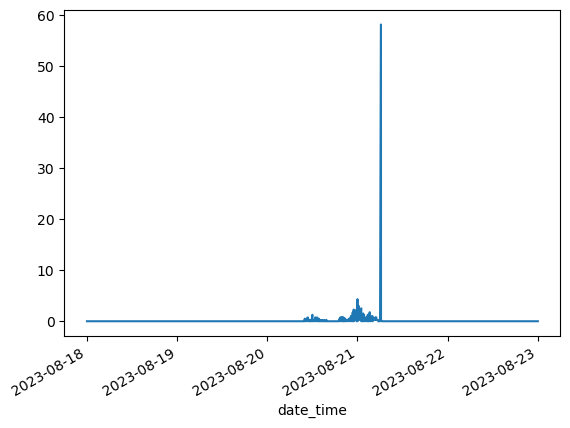

 18%|█▊        | 386/2131 [33:27<11:56:04, 24.62s/it]

QC passed, flag = 0


 18%|█▊        | 387/2131 [33:48<11:16:47, 23.28s/it]

QC passed, flag = 0


 18%|█▊        | 389/2131 [34:01<6:54:04, 14.26s/it] 

QC passed, flag = 0
QC passed, flag = 0


 18%|█▊        | 390/2131 [34:03<5:01:30, 10.39s/it]

QC passed, flag = 0


 18%|█▊        | 391/2131 [34:04<3:40:30,  7.60s/it]

QC passed, flag = 0


 18%|█▊        | 392/2131 [34:19<4:43:39,  9.79s/it]

QC passed, flag = 0


 18%|█▊        | 393/2131 [34:20<3:31:11,  7.29s/it]

QC passed, flag = 0


 18%|█▊        | 394/2131 [34:24<3:06:44,  6.45s/it]

QC passed, flag = 0


 19%|█▊        | 395/2131 [34:26<2:20:47,  4.87s/it]

QC passed, flag = 0


 19%|█▊        | 396/2131 [34:41<3:51:21,  8.00s/it]

QC passed, flag = 0


 19%|█▊        | 397/2131 [34:45<3:19:01,  6.89s/it]

QC passed, flag = 0


 19%|█▊        | 398/2131 [35:01<4:37:48,  9.62s/it]

QC passed, flag = 0


 19%|█▊        | 399/2131 [35:03<3:30:04,  7.28s/it]

QC passed, flag = 0


 19%|█▉        | 400/2131 [35:07<3:03:54,  6.37s/it]

QC passed, flag = 0


 19%|█▉        | 401/2131 [35:11<2:42:44,  5.64s/it]

QC passed, flag = 0


 19%|█▉        | 402/2131 [35:16<2:34:41,  5.37s/it]

QC passed, flag = 0


 19%|█▉        | 403/2131 [35:31<3:54:49,  8.15s/it]

QC passed, flag = 0


 19%|█▉        | 404/2131 [35:45<4:51:36, 10.13s/it]

QC passed, flag = 0


 19%|█▉        | 405/2131 [35:47<3:35:37,  7.50s/it]

QC passed, flag = 0


 19%|█▉        | 406/2131 [35:47<2:35:46,  5.42s/it]

QC passed, flag = 0


 19%|█▉        | 407/2131 [35:52<2:25:44,  5.07s/it]

QC passed, flag = 0
QC fail with flag: 3 - intensity greater than 1000 year retun interval


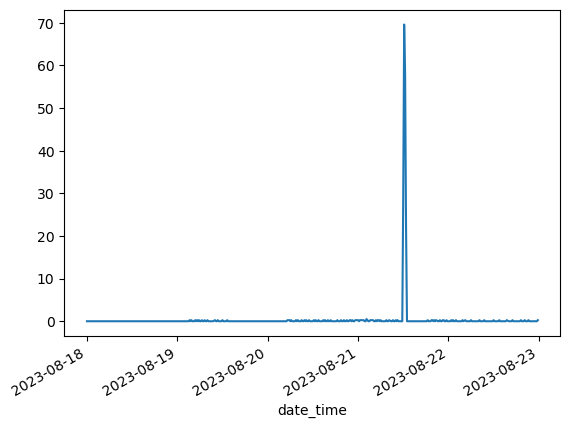

 19%|█▉        | 409/2131 [36:09<3:30:27,  7.33s/it]

QC passed, flag = 0


 19%|█▉        | 410/2131 [36:13<3:06:54,  6.52s/it]

QC passed, flag = 0


 19%|█▉        | 411/2131 [36:28<4:16:11,  8.94s/it]

QC passed, flag = 0


 19%|█▉        | 412/2131 [36:33<3:40:18,  7.69s/it]

QC passed, flag = 0


 19%|█▉        | 413/2131 [36:50<4:59:11, 10.45s/it]

QC passed, flag = 0


 19%|█▉        | 414/2131 [36:51<3:41:41,  7.75s/it]

QC passed, flag = 0


 19%|█▉        | 415/2131 [37:08<5:03:12, 10.60s/it]

QC passed, flag = 0
QC fail with flag: 3 - intensity greater than 1000 year retun interval


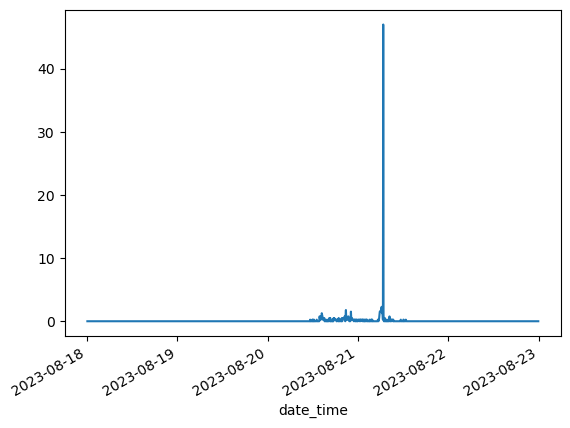

 20%|█▉        | 417/2131 [37:23<4:11:40,  8.81s/it]

QC passed, flag = 0


 20%|█▉        | 418/2131 [37:30<3:55:47,  8.26s/it]

QC passed, flag = 0


 20%|█▉        | 419/2131 [37:31<2:55:55,  6.17s/it]

QC passed, flag = 0


 20%|█▉        | 420/2131 [37:32<2:12:17,  4.64s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


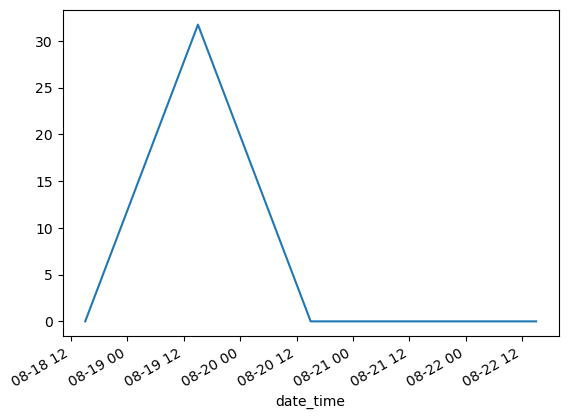

 20%|█▉        | 421/2131 [37:32<1:35:45,  3.36s/it]

QC fail with flag: 1 - not hourly


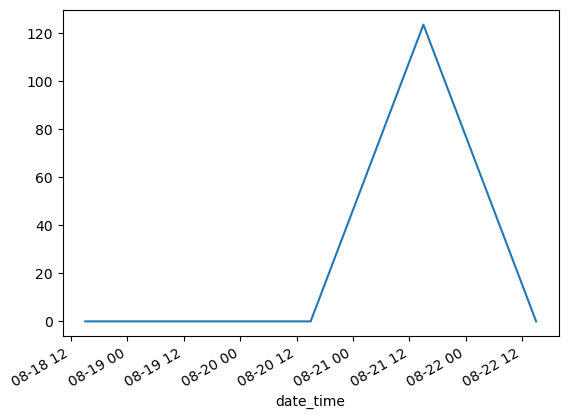

 20%|█▉        | 422/2131 [37:33<1:08:22,  2.40s/it]

QC fail with flag: 1 - not hourly


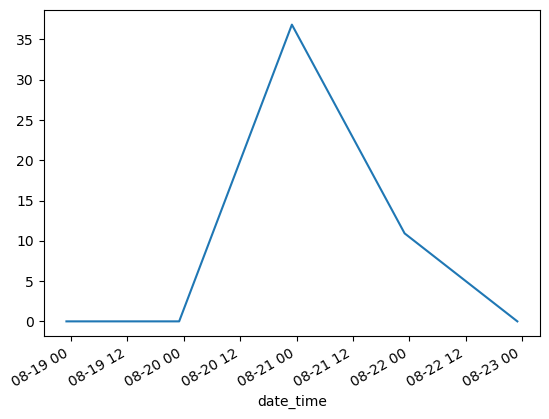

 20%|█▉        | 423/2131 [37:33<49:13,  1.73s/it]  

QC fail with flag: 1 - not hourly


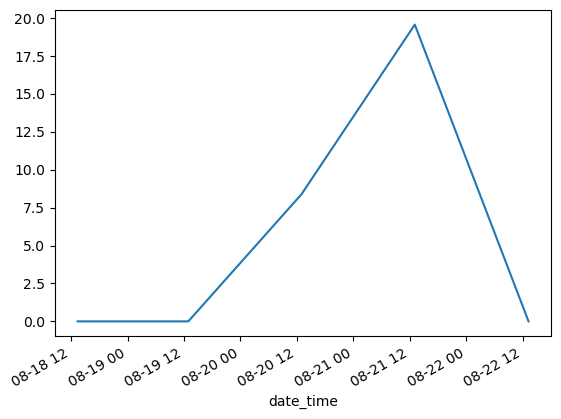

 20%|█▉        | 424/2131 [37:33<35:51,  1.26s/it]

QC fail with flag: 1 - not hourly


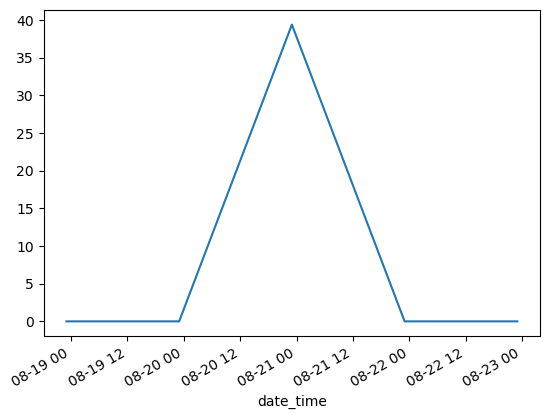

 20%|█▉        | 425/2131 [37:33<26:29,  1.07it/s]

QC fail with flag: 1 - not hourly


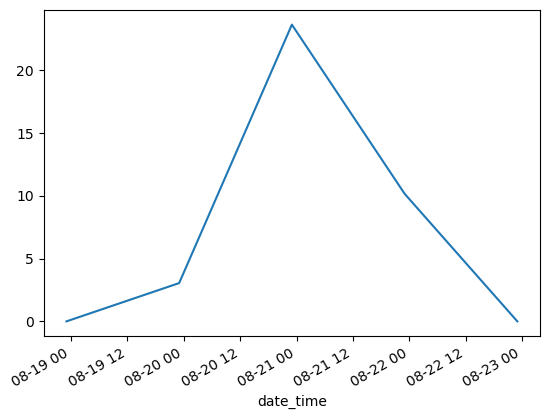

 20%|█▉        | 426/2131 [37:33<19:54,  1.43it/s]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


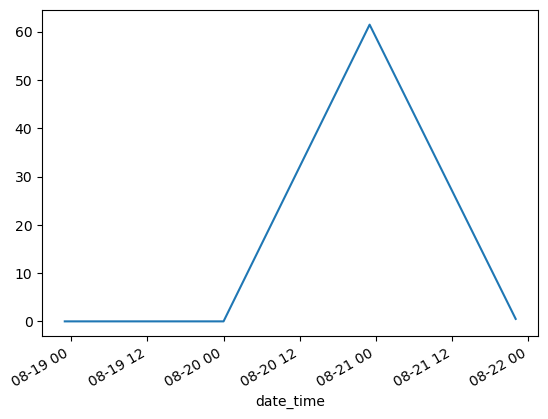

 20%|██        | 428/2131 [37:34<13:16,  2.14it/s]

QC fail with flag: 1 - not hourly


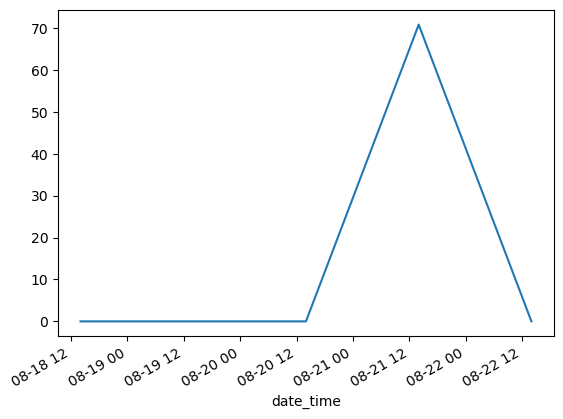

 20%|██        | 429/2131 [37:34<11:08,  2.55it/s]

QC fail with flag: 1 - not hourly


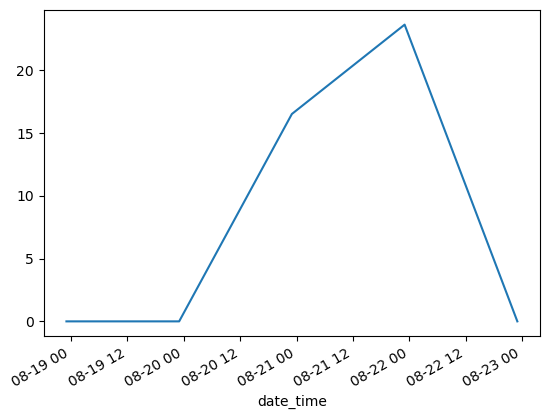

 20%|██        | 430/2131 [37:34<09:24,  3.01it/s]

QC fail with flag: 1 - not hourly


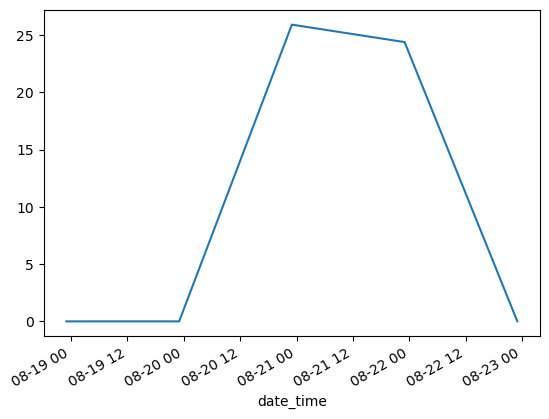

 20%|██        | 432/2131 [37:40<51:26,  1.82s/it]

QC passed, flag = 0


 20%|██        | 433/2131 [37:44<1:12:59,  2.58s/it]

QC passed, flag = 0


 20%|██        | 434/2131 [37:49<1:27:00,  3.08s/it]

QC passed, flag = 0


 20%|██        | 435/2131 [38:04<3:08:52,  6.68s/it]

QC passed, flag = 0


 20%|██        | 436/2131 [38:06<2:26:48,  5.20s/it]

QC passed, flag = 0


 21%|██        | 437/2131 [38:20<3:43:08,  7.90s/it]

QC passed, flag = 0


 21%|██        | 438/2131 [38:36<4:51:41, 10.34s/it]

QC passed, flag = 0


 21%|██        | 439/2131 [38:40<4:01:02,  8.55s/it]

QC passed, flag = 0


 21%|██        | 440/2131 [38:44<3:16:49,  6.98s/it]

QC passed, flag = 0


 21%|██        | 441/2131 [38:48<2:51:12,  6.08s/it]

QC passed, flag = 0


 21%|██        | 442/2131 [38:50<2:20:33,  4.99s/it]

QC passed, flag = 0


 21%|██        | 443/2131 [38:53<2:00:53,  4.30s/it]

QC passed, flag = 0


 21%|██        | 444/2131 [38:55<1:46:12,  3.78s/it]

QC passed, flag = 0


 21%|██        | 445/2131 [38:59<1:47:52,  3.84s/it]

QC passed, flag = 0


 21%|██        | 446/2131 [39:13<3:14:28,  6.93s/it]

QC passed, flag = 0


 21%|██        | 447/2131 [39:14<2:21:19,  5.04s/it]

QC passed, flag = 0


 21%|██        | 448/2131 [39:22<2:48:19,  6.00s/it]

QC passed, flag = 0


 21%|██        | 449/2131 [39:24<2:07:35,  4.55s/it]

QC passed, flag = 0


 21%|██        | 450/2131 [39:37<3:23:57,  7.28s/it]

QC passed, flag = 0


 21%|██        | 451/2131 [39:41<2:52:48,  6.17s/it]

QC passed, flag = 0


 21%|██        | 452/2131 [39:42<2:09:21,  4.62s/it]

QC passed, flag = 0


 21%|██▏       | 453/2131 [39:46<2:10:05,  4.65s/it]

QC passed, flag = 0


 21%|██▏       | 454/2131 [39:52<2:14:15,  4.80s/it]

QC passed, flag = 0


 21%|██▏       | 455/2131 [39:56<2:10:48,  4.68s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


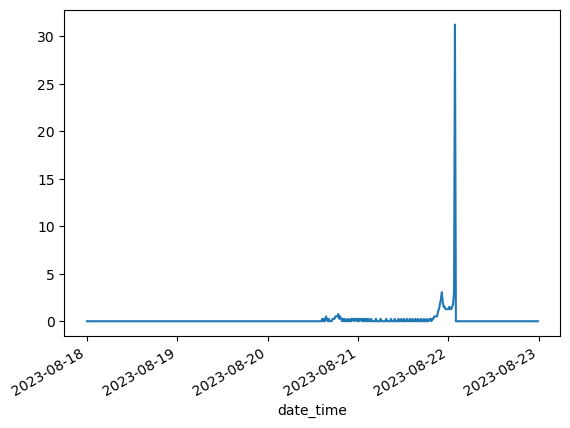

 21%|██▏       | 457/2131 [40:07<2:27:02,  5.27s/it]

QC passed, flag = 0


 21%|██▏       | 458/2131 [40:19<3:22:36,  7.27s/it]

QC passed, flag = 0


 22%|██▏       | 459/2131 [40:23<2:54:21,  6.26s/it]

QC passed, flag = 0


 22%|██▏       | 460/2131 [40:37<3:57:36,  8.53s/it]

QC passed, flag = 0


 22%|██▏       | 461/2131 [40:45<3:49:49,  8.26s/it]

QC passed, flag = 0


 22%|██▏       | 462/2131 [41:02<5:08:30, 11.09s/it]

QC passed, flag = 0


 22%|██▏       | 463/2131 [41:17<5:37:34, 12.14s/it]

QC passed, flag = 0


 22%|██▏       | 464/2131 [41:22<4:40:20, 10.09s/it]

QC passed, flag = 0


 22%|██▏       | 465/2131 [41:37<5:16:24, 11.40s/it]

QC passed, flag = 0


 22%|██▏       | 466/2131 [41:54<6:03:07, 13.09s/it]

QC passed, flag = 0


 22%|██▏       | 467/2131 [42:08<6:14:58, 13.52s/it]

QC passed, flag = 0


 22%|██▏       | 468/2131 [42:16<5:28:11, 11.84s/it]

QC passed, flag = 0


 22%|██▏       | 469/2131 [42:19<4:10:07,  9.03s/it]

QC passed, flag = 0


 22%|██▏       | 470/2131 [42:21<3:11:33,  6.92s/it]

QC passed, flag = 0


 22%|██▏       | 471/2131 [42:22<2:28:14,  5.36s/it]

QC passed, flag = 0


 22%|██▏       | 472/2131 [42:24<1:59:08,  4.31s/it]

QC passed, flag = 0


 22%|██▏       | 473/2131 [42:26<1:38:21,  3.56s/it]

QC passed, flag = 0


 22%|██▏       | 474/2131 [42:28<1:25:10,  3.08s/it]

QC passed, flag = 0


 22%|██▏       | 475/2131 [42:29<1:10:07,  2.54s/it]

QC passed, flag = 0


 22%|██▏       | 476/2131 [42:31<1:01:29,  2.23s/it]

QC passed, flag = 0


 22%|██▏       | 477/2131 [42:32<53:09,  1.93s/it]  

QC passed, flag = 0


 22%|██▏       | 478/2131 [42:34<49:51,  1.81s/it]

QC passed, flag = 0


 22%|██▏       | 479/2131 [42:35<46:38,  1.69s/it]

QC passed, flag = 0


 23%|██▎       | 480/2131 [42:36<42:10,  1.53s/it]

QC passed, flag = 0


 23%|██▎       | 481/2131 [42:37<38:36,  1.40s/it]

QC passed, flag = 0


 23%|██▎       | 482/2131 [42:39<37:28,  1.36s/it]

QC passed, flag = 0


 23%|██▎       | 483/2131 [42:40<35:09,  1.28s/it]

QC passed, flag = 0


 23%|██▎       | 484/2131 [42:41<34:45,  1.27s/it]

QC passed, flag = 0


 23%|██▎       | 485/2131 [42:42<34:10,  1.25s/it]

QC passed, flag = 0


 23%|██▎       | 486/2131 [42:43<33:30,  1.22s/it]

QC passed, flag = 0


 23%|██▎       | 487/2131 [42:44<32:35,  1.19s/it]

QC passed, flag = 0


 23%|██▎       | 488/2131 [42:55<1:46:53,  3.90s/it]

QC passed, flag = 0


 23%|██▎       | 489/2131 [42:56<1:26:44,  3.17s/it]

QC passed, flag = 0


 23%|██▎       | 490/2131 [43:00<1:34:52,  3.47s/it]

QC passed, flag = 0


 23%|██▎       | 491/2131 [43:01<1:15:31,  2.76s/it]

QC passed, flag = 0


 23%|██▎       | 492/2131 [43:17<2:57:35,  6.50s/it]

QC passed, flag = 0


 23%|██▎       | 493/2131 [43:34<4:26:18,  9.76s/it]

QC passed, flag = 0


 23%|██▎       | 494/2131 [43:39<3:45:02,  8.25s/it]

QC passed, flag = 0


 23%|██▎       | 495/2131 [43:40<2:48:27,  6.18s/it]

QC passed, flag = 0


 23%|██▎       | 496/2131 [43:54<3:54:32,  8.61s/it]

QC passed, flag = 0


 23%|██▎       | 497/2131 [43:56<3:01:11,  6.65s/it]

QC passed, flag = 0


 23%|██▎       | 498/2131 [44:01<2:47:02,  6.14s/it]

QC passed, flag = 0


 23%|██▎       | 499/2131 [44:16<3:53:17,  8.58s/it]

QC passed, flag = 0


 23%|██▎       | 500/2131 [44:24<3:52:38,  8.56s/it]

QC passed, flag = 0


 24%|██▎       | 501/2131 [44:25<2:53:52,  6.40s/it]

QC passed, flag = 0


 24%|██▎       | 502/2131 [44:27<2:10:57,  4.82s/it]

QC passed, flag = 0


 24%|██▎       | 503/2131 [44:28<1:41:18,  3.73s/it]

QC passed, flag = 0


 24%|██▎       | 504/2131 [44:29<1:20:15,  2.96s/it]

QC passed, flag = 0


 24%|██▎       | 505/2131 [44:45<3:04:17,  6.80s/it]

QC passed, flag = 0


 24%|██▎       | 506/2131 [45:01<4:18:28,  9.54s/it]

QC passed, flag = 0


 24%|██▍       | 507/2131 [45:15<4:57:37, 11.00s/it]

QC passed, flag = 0


 24%|██▍       | 508/2131 [45:20<4:05:27,  9.07s/it]

QC passed, flag = 0


 24%|██▍       | 509/2131 [45:35<4:56:27, 10.97s/it]

QC passed, flag = 0


 24%|██▍       | 510/2131 [45:40<4:08:11,  9.19s/it]

QC passed, flag = 0


 24%|██▍       | 511/2131 [45:44<3:28:19,  7.72s/it]

QC passed, flag = 0


 24%|██▍       | 512/2131 [45:58<4:18:32,  9.58s/it]

QC passed, flag = 0


 24%|██▍       | 513/2131 [46:05<3:56:25,  8.77s/it]

QC passed, flag = 0


 24%|██▍       | 514/2131 [46:10<3:26:25,  7.66s/it]

QC passed, flag = 0


 24%|██▍       | 515/2131 [46:24<4:12:42,  9.38s/it]

QC passed, flag = 0


 24%|██▍       | 516/2131 [46:30<3:47:29,  8.45s/it]

QC passed, flag = 0


 24%|██▍       | 517/2131 [46:31<2:50:03,  6.32s/it]

QC passed, flag = 0


 24%|██▍       | 518/2131 [46:36<2:39:11,  5.92s/it]

QC passed, flag = 0


 24%|██▍       | 519/2131 [46:41<2:27:44,  5.50s/it]

QC passed, flag = 0


 24%|██▍       | 520/2131 [46:42<1:53:09,  4.21s/it]

QC passed, flag = 0


 24%|██▍       | 521/2131 [46:50<2:20:48,  5.25s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


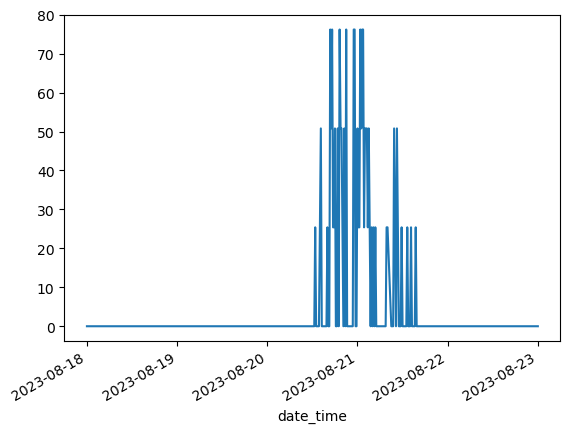

 25%|██▍       | 523/2131 [46:53<1:30:12,  3.37s/it]

QC passed, flag = 0


 25%|██▍       | 524/2131 [46:57<1:38:51,  3.69s/it]

QC passed, flag = 0


 25%|██▍       | 525/2131 [47:13<3:14:47,  7.28s/it]

QC passed, flag = 0


 25%|██▍       | 526/2131 [47:17<2:47:31,  6.26s/it]

QC passed, flag = 0


 25%|██▍       | 527/2131 [47:22<2:34:24,  5.78s/it]

QC passed, flag = 0


 25%|██▍       | 528/2131 [47:23<1:59:33,  4.48s/it]

QC passed, flag = 0


 25%|██▍       | 529/2131 [47:27<1:56:59,  4.38s/it]

QC passed, flag = 0


 25%|██▍       | 530/2131 [47:33<2:11:24,  4.92s/it]

QC passed, flag = 0


 25%|██▍       | 531/2131 [47:48<3:29:12,  7.85s/it]

QC passed, flag = 0


 25%|██▍       | 532/2131 [47:50<2:39:25,  5.98s/it]

QC passed, flag = 0


 25%|██▌       | 533/2131 [47:54<2:25:36,  5.47s/it]

QC passed, flag = 0


 25%|██▌       | 534/2131 [47:59<2:18:35,  5.21s/it]

QC passed, flag = 0


 25%|██▌       | 535/2131 [48:03<2:09:13,  4.86s/it]

QC passed, flag = 0


 25%|██▌       | 536/2131 [48:07<2:03:22,  4.64s/it]

QC passed, flag = 0


 25%|██▌       | 537/2131 [48:11<1:59:39,  4.50s/it]

QC passed, flag = 0


 25%|██▌       | 538/2131 [48:15<1:55:45,  4.36s/it]

QC passed, flag = 0


 25%|██▌       | 539/2131 [48:17<1:35:44,  3.61s/it]

QC passed, flag = 0


 25%|██▌       | 540/2131 [48:22<1:45:23,  3.97s/it]

QC passed, flag = 0


 25%|██▌       | 541/2131 [48:27<1:57:33,  4.44s/it]

QC passed, flag = 0


 25%|██▌       | 542/2131 [48:32<2:05:11,  4.73s/it]

QC passed, flag = 0


 25%|██▌       | 543/2131 [48:37<2:00:27,  4.55s/it]

QC passed, flag = 0


 26%|██▌       | 544/2131 [48:54<3:38:07,  8.25s/it]

QC passed, flag = 0


 26%|██▌       | 545/2131 [48:55<2:43:11,  6.17s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


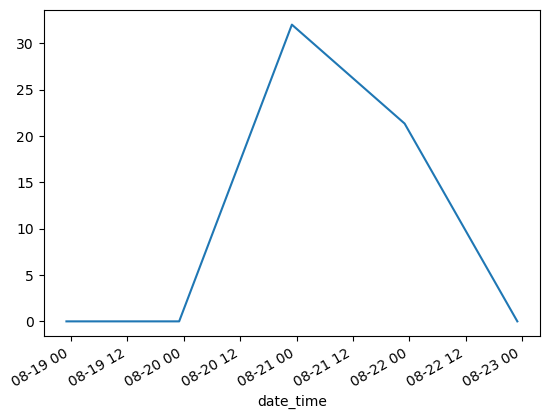

 26%|██▌       | 546/2131 [48:55<1:57:35,  4.45s/it]

QC fail with flag: 1 - not hourly


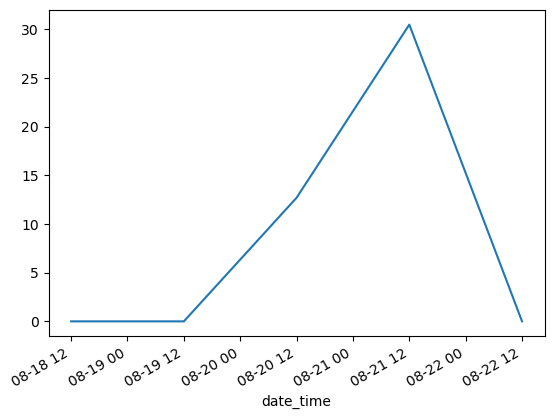

 26%|██▌       | 547/2131 [48:55<1:23:47,  3.17s/it]

QC fail with flag: 1 - not hourly


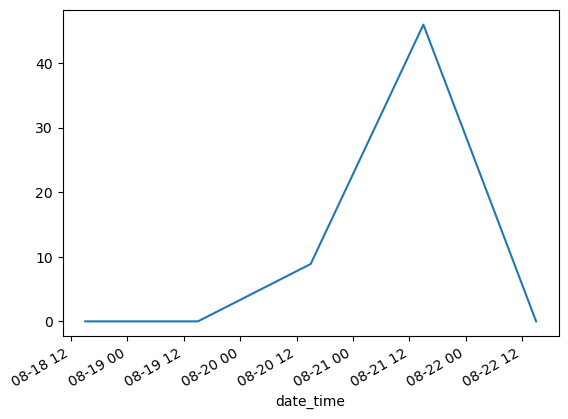

 26%|██▌       | 548/2131 [48:56<59:58,  2.27s/it]  

QC fail with flag: 1 - not hourly


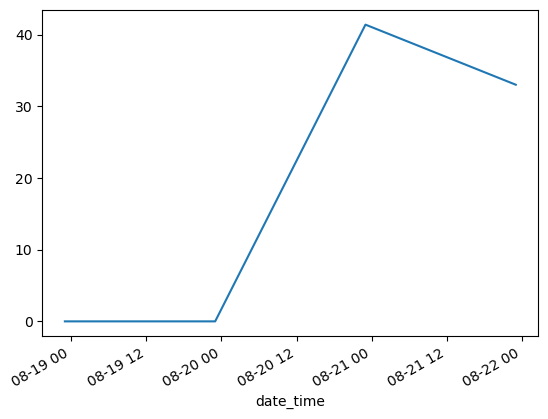

 26%|██▌       | 550/2131 [49:01<1:09:19,  2.63s/it]

QC passed, flag = 0


 26%|██▌       | 551/2131 [49:05<1:23:48,  3.18s/it]

QC passed, flag = 0


 26%|██▌       | 552/2131 [49:22<3:09:46,  7.21s/it]

QC passed, flag = 0


 26%|██▌       | 553/2131 [49:23<2:23:33,  5.46s/it]

QC passed, flag = 0


 26%|██▌       | 554/2131 [49:41<4:02:32,  9.23s/it]

QC passed, flag = 0


 26%|██▌       | 555/2131 [49:45<3:18:33,  7.56s/it]

QC passed, flag = 0


 26%|██▌       | 556/2131 [49:48<2:45:31,  6.31s/it]

QC passed, flag = 0


 26%|██▌       | 557/2131 [49:51<2:17:47,  5.25s/it]

QC passed, flag = 0


 26%|██▌       | 558/2131 [49:54<1:57:30,  4.48s/it]

QC passed, flag = 0


 26%|██▌       | 559/2131 [49:56<1:41:31,  3.87s/it]

QC passed, flag = 0


 26%|██▋       | 560/2131 [50:00<1:38:20,  3.76s/it]

QC passed, flag = 0


 26%|██▋       | 561/2131 [50:02<1:30:27,  3.46s/it]

QC passed, flag = 0


 26%|██▋       | 562/2131 [50:05<1:26:31,  3.31s/it]

QC passed, flag = 0


 26%|██▋       | 563/2131 [50:07<1:14:58,  2.87s/it]

QC passed, flag = 0


 26%|██▋       | 564/2131 [50:10<1:15:58,  2.91s/it]

QC passed, flag = 0


 27%|██▋       | 565/2131 [50:13<1:17:28,  2.97s/it]

QC passed, flag = 0


 27%|██▋       | 566/2131 [50:16<1:13:59,  2.84s/it]

QC passed, flag = 0


 27%|██▋       | 567/2131 [50:19<1:12:20,  2.78s/it]

QC passed, flag = 0


 27%|██▋       | 568/2131 [50:21<1:11:02,  2.73s/it]

QC passed, flag = 0


 27%|██▋       | 569/2131 [50:24<1:14:40,  2.87s/it]

QC passed, flag = 0


 27%|██▋       | 570/2131 [50:28<1:21:05,  3.12s/it]

QC passed, flag = 0


 27%|██▋       | 571/2131 [50:31<1:17:57,  3.00s/it]

QC passed, flag = 0


 27%|██▋       | 572/2131 [50:34<1:20:20,  3.09s/it]

QC passed, flag = 0


 27%|██▋       | 573/2131 [50:49<2:52:28,  6.64s/it]

QC passed, flag = 0


 27%|██▋       | 574/2131 [51:02<3:40:35,  8.50s/it]

QC passed, flag = 0


 27%|██▋       | 575/2131 [51:06<3:07:36,  7.23s/it]

QC passed, flag = 0


 27%|██▋       | 576/2131 [51:24<4:29:37, 10.40s/it]

QC passed, flag = 0


 27%|██▋       | 577/2131 [51:31<4:00:14,  9.28s/it]

QC passed, flag = 0


 27%|██▋       | 578/2131 [51:45<4:37:56, 10.74s/it]

QC passed, flag = 0


 27%|██▋       | 579/2131 [52:03<5:34:21, 12.93s/it]

QC passed, flag = 0


 27%|██▋       | 580/2131 [52:07<4:28:09, 10.37s/it]

QC passed, flag = 0


 27%|██▋       | 581/2131 [52:17<4:21:27, 10.12s/it]

QC passed, flag = 0


 27%|██▋       | 582/2131 [52:23<3:55:27,  9.12s/it]

QC passed, flag = 0


 27%|██▋       | 583/2131 [52:38<4:35:11, 10.67s/it]

QC passed, flag = 0


 27%|██▋       | 584/2131 [52:39<3:23:53,  7.91s/it]

QC passed, flag = 0


 27%|██▋       | 585/2131 [52:54<4:19:50, 10.08s/it]

QC passed, flag = 0


 27%|██▋       | 586/2131 [53:10<5:00:49, 11.68s/it]

QC passed, flag = 0


 28%|██▊       | 587/2131 [53:24<5:17:48, 12.35s/it]

QC passed, flag = 0


 28%|██▊       | 588/2131 [53:44<6:15:32, 14.60s/it]

QC passed, flag = 0


 28%|██▊       | 589/2131 [53:58<6:13:54, 14.55s/it]

QC passed, flag = 0


 28%|██▊       | 590/2131 [54:03<4:58:29, 11.62s/it]

QC passed, flag = 0


 28%|██▊       | 591/2131 [54:15<5:05:18, 11.90s/it]

QC passed, flag = 0


 28%|██▊       | 592/2131 [54:20<4:06:27,  9.61s/it]

QC passed, flag = 0


 28%|██▊       | 593/2131 [54:34<4:43:11, 11.05s/it]

QC passed, flag = 0


 28%|██▊       | 594/2131 [54:44<4:32:17, 10.63s/it]

QC passed, flag = 0


 28%|██▊       | 595/2131 [54:49<3:49:06,  8.95s/it]

QC passed, flag = 0


 28%|██▊       | 596/2131 [54:51<2:55:24,  6.86s/it]

QC passed, flag = 0


 28%|██▊       | 597/2131 [54:54<2:27:31,  5.77s/it]

QC passed, flag = 0


 28%|██▊       | 598/2131 [54:56<1:58:18,  4.63s/it]

QC passed, flag = 0


 28%|██▊       | 599/2131 [54:58<1:37:17,  3.81s/it]

QC passed, flag = 0


 28%|██▊       | 600/2131 [55:00<1:25:08,  3.34s/it]

QC passed, flag = 0


 28%|██▊       | 601/2131 [55:02<1:14:00,  2.90s/it]

QC passed, flag = 0


 28%|██▊       | 602/2131 [55:03<1:00:32,  2.38s/it]

QC passed, flag = 0


 28%|██▊       | 603/2131 [55:04<51:10,  2.01s/it]  

QC passed, flag = 0


 28%|██▊       | 604/2131 [55:05<44:26,  1.75s/it]

QC passed, flag = 0


 28%|██▊       | 605/2131 [55:06<39:54,  1.57s/it]

QC passed, flag = 0


 28%|██▊       | 606/2131 [55:08<36:43,  1.44s/it]

QC passed, flag = 0


 28%|██▊       | 607/2131 [55:09<34:41,  1.37s/it]

QC passed, flag = 0


 29%|██▊       | 608/2131 [55:10<33:43,  1.33s/it]

QC passed, flag = 0


 29%|██▊       | 609/2131 [55:11<32:25,  1.28s/it]

QC passed, flag = 0


 29%|██▊       | 610/2131 [55:13<34:35,  1.36s/it]

QC passed, flag = 0


 29%|██▊       | 611/2131 [55:14<33:02,  1.30s/it]

QC passed, flag = 0


 29%|██▊       | 612/2131 [55:15<31:49,  1.26s/it]

QC passed, flag = 0


 29%|██▉       | 613/2131 [55:16<30:47,  1.22s/it]

QC passed, flag = 0


 29%|██▉       | 614/2131 [55:17<30:06,  1.19s/it]

QC passed, flag = 0


 29%|██▉       | 615/2131 [55:18<29:32,  1.17s/it]

QC passed, flag = 0


 29%|██▉       | 616/2131 [55:20<29:00,  1.15s/it]

QC passed, flag = 0


 29%|██▉       | 617/2131 [55:35<2:18:51,  5.50s/it]

QC passed, flag = 0


 29%|██▉       | 618/2131 [55:49<3:24:17,  8.10s/it]

QC passed, flag = 0


 29%|██▉       | 619/2131 [56:02<3:54:47,  9.32s/it]

QC passed, flag = 0


 29%|██▉       | 620/2131 [56:04<3:01:21,  7.20s/it]

QC passed, flag = 0


 29%|██▉       | 621/2131 [56:12<3:07:21,  7.44s/it]

QC passed, flag = 0


 29%|██▉       | 622/2131 [56:13<2:20:52,  5.60s/it]

QC passed, flag = 0


 29%|██▉       | 623/2131 [56:17<2:10:23,  5.19s/it]

QC passed, flag = 0


 29%|██▉       | 624/2131 [56:21<2:01:02,  4.82s/it]

QC passed, flag = 0


 29%|██▉       | 625/2131 [56:44<4:14:53, 10.16s/it]

QC passed, flag = 0


 29%|██▉       | 626/2131 [56:57<4:39:01, 11.12s/it]

QC passed, flag = 0


 29%|██▉       | 627/2131 [57:02<3:47:30,  9.08s/it]

QC passed, flag = 0


 29%|██▉       | 628/2131 [57:08<3:30:25,  8.40s/it]

QC passed, flag = 0


 30%|██▉       | 629/2131 [57:12<2:54:19,  6.96s/it]

QC passed, flag = 0


 30%|██▉       | 630/2131 [57:17<2:37:27,  6.29s/it]

QC passed, flag = 0


 30%|██▉       | 631/2131 [57:31<3:37:18,  8.69s/it]

QC passed, flag = 0


 30%|██▉       | 632/2131 [57:44<4:08:22,  9.94s/it]

QC passed, flag = 0


 30%|██▉       | 633/2131 [58:01<5:05:21, 12.23s/it]

QC passed, flag = 0


 30%|██▉       | 634/2131 [58:06<4:05:20,  9.83s/it]

QC passed, flag = 0


 30%|██▉       | 635/2131 [58:10<3:23:49,  8.18s/it]

QC passed, flag = 0


 30%|██▉       | 636/2131 [58:11<2:33:10,  6.15s/it]

QC passed, flag = 0


 30%|██▉       | 637/2131 [58:16<2:21:32,  5.68s/it]

QC passed, flag = 0


 30%|██▉       | 638/2131 [58:21<2:13:01,  5.35s/it]

QC passed, flag = 0


 30%|██▉       | 639/2131 [58:26<2:11:53,  5.30s/it]

QC passed, flag = 0


 30%|███       | 640/2131 [58:27<1:40:54,  4.06s/it]

QC passed, flag = 0


 30%|███       | 641/2131 [58:42<3:06:10,  7.50s/it]

QC passed, flag = 0


 30%|███       | 642/2131 [58:47<2:43:01,  6.57s/it]

QC passed, flag = 0


 30%|███       | 643/2131 [58:51<2:27:24,  5.94s/it]

QC passed, flag = 0


 30%|███       | 644/2131 [59:21<5:22:53, 13.03s/it]

QC passed, flag = 0


 30%|███       | 645/2131 [59:38<5:50:07, 14.14s/it]

QC passed, flag = 0


 30%|███       | 646/2131 [59:39<4:14:59, 10.30s/it]

QC passed, flag = 0


 30%|███       | 647/2131 [59:45<3:46:12,  9.15s/it]

QC passed, flag = 0


 30%|███       | 648/2131 [1:00:00<4:25:19, 10.73s/it]

QC passed, flag = 0


 30%|███       | 649/2131 [1:00:04<3:39:16,  8.88s/it]

QC passed, flag = 0


 31%|███       | 650/2131 [1:00:06<2:42:58,  6.60s/it]

QC passed, flag = 0


 31%|███       | 651/2131 [1:00:12<2:43:34,  6.63s/it]

QC passed, flag = 0


 31%|███       | 652/2131 [1:00:16<2:23:08,  5.81s/it]

QC passed, flag = 0


 31%|███       | 653/2131 [1:00:20<2:10:42,  5.31s/it]

QC passed, flag = 0


 31%|███       | 654/2131 [1:00:25<2:02:26,  4.97s/it]

QC passed, flag = 0


 31%|███       | 655/2131 [1:00:29<1:55:37,  4.70s/it]

QC passed, flag = 0


 31%|███       | 656/2131 [1:00:33<1:52:25,  4.57s/it]

QC passed, flag = 0


 31%|███       | 657/2131 [1:00:34<1:29:34,  3.65s/it]

QC passed, flag = 0


 31%|███       | 658/2131 [1:00:39<1:39:47,  4.06s/it]

QC passed, flag = 0


 31%|███       | 659/2131 [1:00:44<1:40:02,  4.08s/it]

QC passed, flag = 0


 31%|███       | 660/2131 [1:00:48<1:40:21,  4.09s/it]

QC passed, flag = 0


 31%|███       | 661/2131 [1:01:06<3:22:48,  8.28s/it]

QC passed, flag = 0


 31%|███       | 662/2131 [1:01:11<3:03:51,  7.51s/it]

QC passed, flag = 0


 31%|███       | 663/2131 [1:01:14<2:25:14,  5.94s/it]

QC passed, flag = 0


 31%|███       | 664/2131 [1:01:18<2:12:11,  5.41s/it]

QC passed, flag = 0


 31%|███       | 665/2131 [1:01:22<2:05:15,  5.13s/it]

QC passed, flag = 0


 31%|███▏      | 666/2131 [1:01:29<2:18:24,  5.67s/it]

QC passed, flag = 0


 31%|███▏      | 667/2131 [1:01:44<3:22:04,  8.28s/it]

QC passed, flag = 0


 31%|███▏      | 668/2131 [1:01:48<2:56:13,  7.23s/it]

QC passed, flag = 0


 31%|███▏      | 669/2131 [1:01:53<2:35:39,  6.39s/it]

QC passed, flag = 0


 31%|███▏      | 670/2131 [1:01:57<2:18:43,  5.70s/it]

QC passed, flag = 0


 31%|███▏      | 671/2131 [1:02:12<3:24:55,  8.42s/it]

QC passed, flag = 0


 32%|███▏      | 672/2131 [1:02:17<2:58:31,  7.34s/it]

QC passed, flag = 0


 32%|███▏      | 673/2131 [1:02:22<2:41:38,  6.65s/it]

QC passed, flag = 0


 32%|███▏      | 674/2131 [1:02:26<2:24:21,  5.94s/it]

QC passed, flag = 0


 32%|███▏      | 675/2131 [1:02:30<2:11:29,  5.42s/it]

QC passed, flag = 0


 32%|███▏      | 676/2131 [1:02:48<3:41:44,  9.14s/it]

QC passed, flag = 0


 32%|███▏      | 677/2131 [1:02:51<2:59:12,  7.40s/it]

QC passed, flag = 0


 32%|███▏      | 678/2131 [1:02:56<2:39:32,  6.59s/it]

QC passed, flag = 0


 32%|███▏      | 679/2131 [1:03:00<2:23:45,  5.94s/it]

QC passed, flag = 0


 32%|███▏      | 680/2131 [1:03:18<3:48:00,  9.43s/it]

QC passed, flag = 0


 32%|███▏      | 681/2131 [1:03:32<4:23:06, 10.89s/it]

QC passed, flag = 0


 32%|███▏      | 682/2131 [1:03:37<3:38:01,  9.03s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


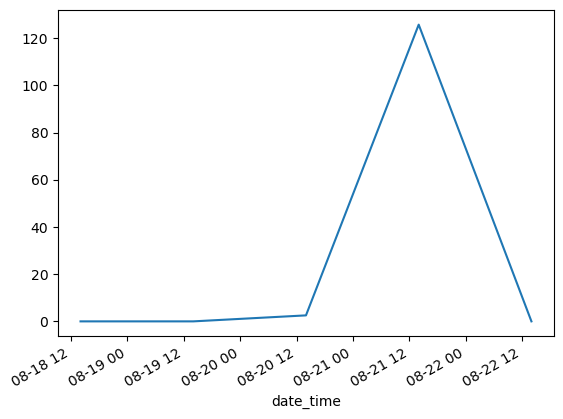

 32%|███▏      | 683/2131 [1:03:37<2:35:26,  6.44s/it]

QC fail with flag: 1 - not hourly


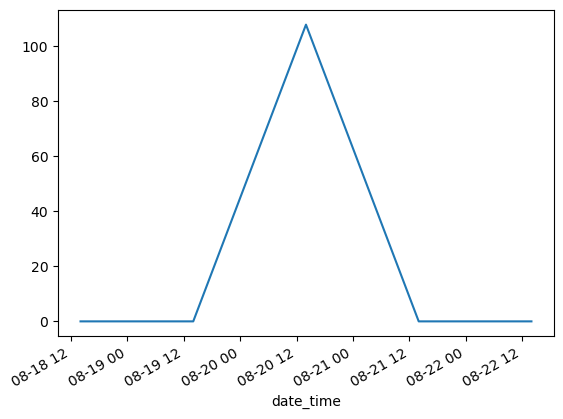

 32%|███▏      | 685/2131 [1:03:41<1:38:36,  4.09s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


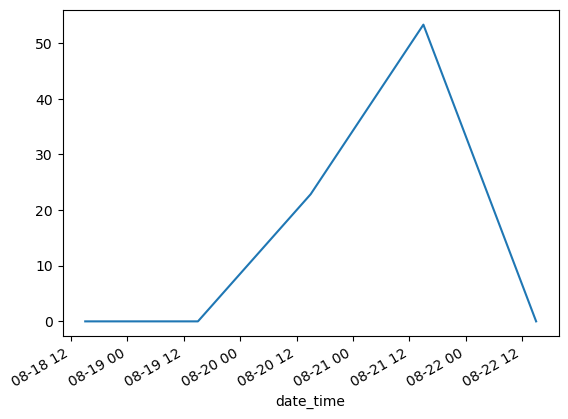

 32%|███▏      | 686/2131 [1:03:41<1:10:14,  2.92s/it]

QC fail with flag: 1 - not hourly


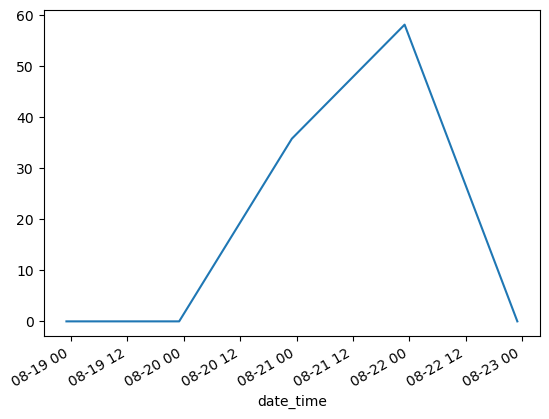

 32%|███▏      | 687/2131 [1:03:41<50:19,  2.09s/it]  

QC fail with flag: 1 - not hourly


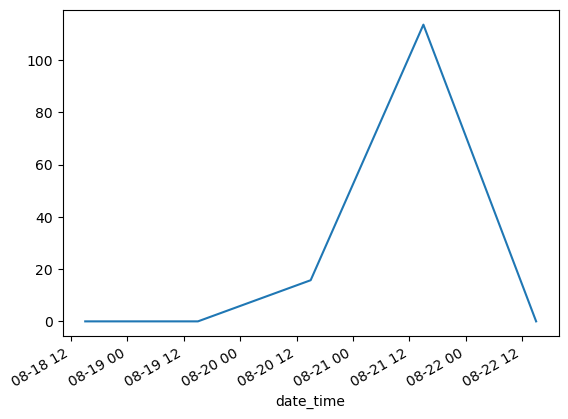

 32%|███▏      | 688/2131 [1:03:41<36:22,  1.51s/it]

QC fail with flag: 1 - not hourly


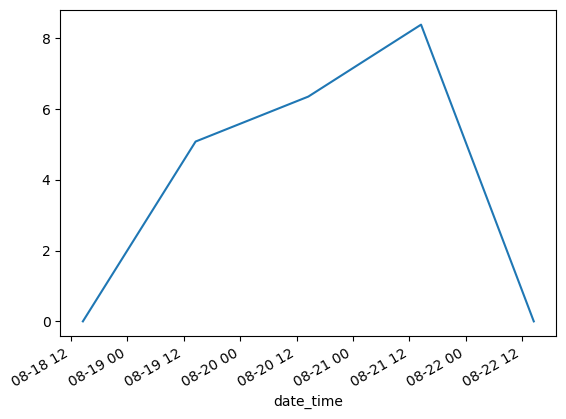

 32%|███▏      | 689/2131 [1:03:41<26:37,  1.11s/it]

QC fail with flag: 1 - not hourly


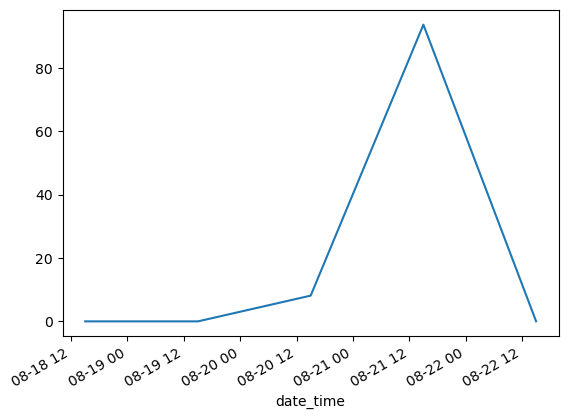

 32%|███▏      | 690/2131 [1:03:41<19:49,  1.21it/s]

QC fail with flag: 1 - not hourly


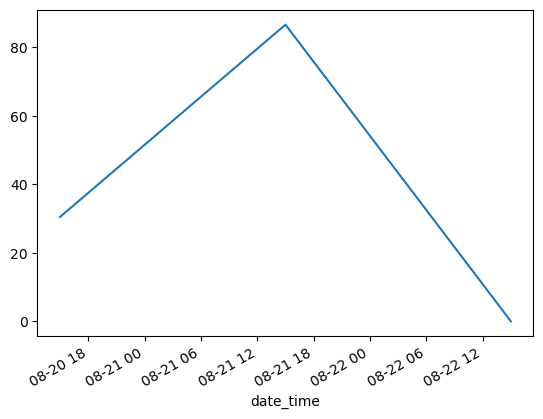

 32%|███▏      | 691/2131 [1:03:41<14:51,  1.62it/s]

QC fail with flag: 1 - not hourly


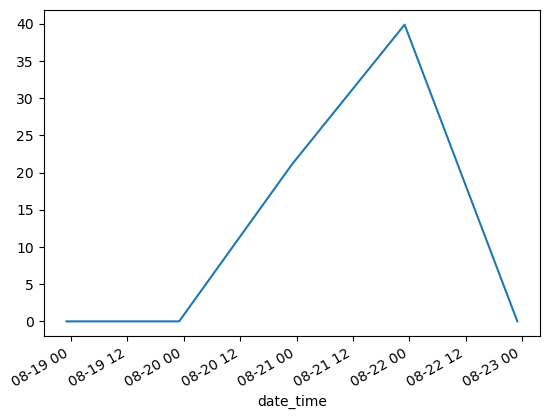

 32%|███▏      | 692/2131 [1:03:42<12:02,  1.99it/s]

QC fail with flag: 1 - not hourly


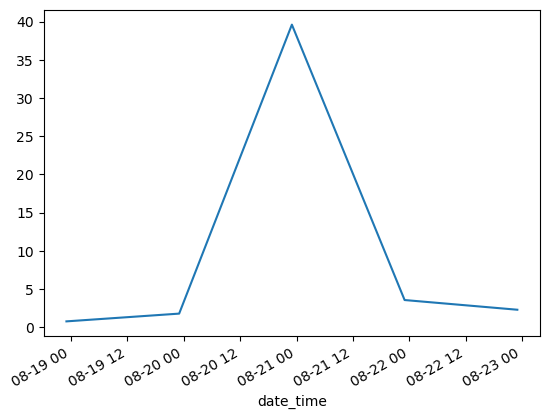

 33%|███▎      | 693/2131 [1:03:42<13:31,  1.77it/s]

QC fail with flag: 1 - not hourly


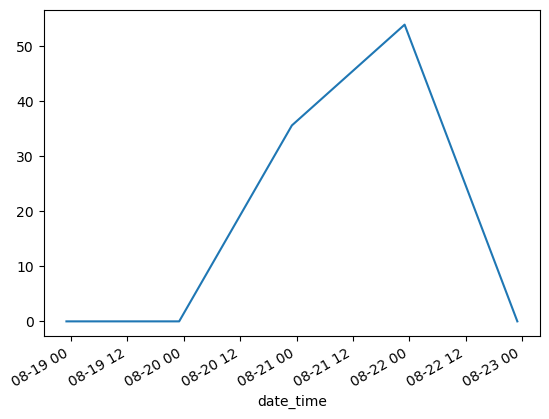

 33%|███▎      | 695/2131 [1:03:47<39:47,  1.66s/it]

QC passed, flag = 0


 33%|███▎      | 696/2131 [1:03:58<1:48:02,  4.52s/it]

QC passed, flag = 0


 33%|███▎      | 697/2131 [1:04:02<1:39:11,  4.15s/it]

QC passed, flag = 0


 33%|███▎      | 698/2131 [1:04:05<1:30:42,  3.80s/it]

QC passed, flag = 0


 33%|███▎      | 699/2131 [1:04:08<1:29:17,  3.74s/it]

QC passed, flag = 0


 33%|███▎      | 700/2131 [1:04:22<2:40:51,  6.74s/it]

QC passed, flag = 0


 33%|███▎      | 701/2131 [1:04:26<2:22:51,  5.99s/it]

QC passed, flag = 0


 33%|███▎      | 702/2131 [1:04:47<4:10:39, 10.52s/it]

QC passed, flag = 0


 33%|███▎      | 703/2131 [1:04:51<3:24:13,  8.58s/it]

QC passed, flag = 0


 33%|███▎      | 704/2131 [1:04:55<2:49:42,  7.14s/it]

QC passed, flag = 0


 33%|███▎      | 705/2131 [1:04:59<2:24:48,  6.09s/it]

QC passed, flag = 0


 33%|███▎      | 706/2131 [1:05:01<2:01:00,  5.09s/it]

QC passed, flag = 0


 33%|███▎      | 707/2131 [1:05:04<1:39:17,  4.18s/it]

QC passed, flag = 0


 33%|███▎      | 708/2131 [1:05:06<1:25:07,  3.59s/it]

QC passed, flag = 0


 33%|███▎      | 709/2131 [1:05:08<1:13:51,  3.12s/it]

QC passed, flag = 0


 33%|███▎      | 710/2131 [1:05:10<1:06:05,  2.79s/it]

QC passed, flag = 0


 33%|███▎      | 711/2131 [1:05:13<1:08:00,  2.87s/it]

QC passed, flag = 0


 33%|███▎      | 712/2131 [1:05:15<1:02:43,  2.65s/it]

QC passed, flag = 0


 33%|███▎      | 713/2131 [1:05:18<1:04:31,  2.73s/it]

QC passed, flag = 0


 34%|███▎      | 714/2131 [1:05:21<1:09:01,  2.92s/it]

QC passed, flag = 0


 34%|███▎      | 715/2131 [1:05:24<1:05:21,  2.77s/it]

QC passed, flag = 0


 34%|███▎      | 716/2131 [1:05:26<1:01:57,  2.63s/it]

QC passed, flag = 0


 34%|███▎      | 717/2131 [1:05:28<57:47,  2.45s/it]  

QC passed, flag = 0


 34%|███▎      | 718/2131 [1:05:31<1:00:05,  2.55s/it]

QC passed, flag = 0


 34%|███▎      | 719/2131 [1:05:33<1:00:44,  2.58s/it]

QC passed, flag = 0


 34%|███▍      | 720/2131 [1:05:37<1:10:26,  3.00s/it]

QC passed, flag = 0


 34%|███▍      | 721/2131 [1:05:41<1:12:53,  3.10s/it]

QC passed, flag = 0


 34%|███▍      | 722/2131 [1:05:44<1:12:20,  3.08s/it]

QC passed, flag = 0


 34%|███▍      | 723/2131 [1:05:47<1:11:42,  3.06s/it]

QC passed, flag = 0


 34%|███▍      | 724/2131 [1:05:51<1:19:17,  3.38s/it]

QC passed, flag = 0


 34%|███▍      | 725/2131 [1:05:54<1:19:06,  3.38s/it]

QC passed, flag = 0


 34%|███▍      | 726/2131 [1:05:58<1:20:48,  3.45s/it]

QC passed, flag = 0


 34%|███▍      | 727/2131 [1:06:01<1:15:50,  3.24s/it]

QC passed, flag = 0


 34%|███▍      | 728/2131 [1:06:04<1:16:21,  3.27s/it]

QC passed, flag = 0


 34%|███▍      | 729/2131 [1:06:08<1:22:21,  3.52s/it]

QC passed, flag = 0


 34%|███▍      | 730/2131 [1:06:11<1:17:40,  3.33s/it]

QC passed, flag = 0


 34%|███▍      | 731/2131 [1:06:14<1:17:02,  3.30s/it]

QC passed, flag = 0


 34%|███▍      | 732/2131 [1:06:17<1:11:14,  3.06s/it]

QC passed, flag = 0


 34%|███▍      | 733/2131 [1:06:20<1:12:23,  3.11s/it]

QC passed, flag = 0


 34%|███▍      | 734/2131 [1:06:24<1:22:21,  3.54s/it]

QC passed, flag = 0


 34%|███▍      | 735/2131 [1:06:27<1:14:10,  3.19s/it]

QC passed, flag = 0


 35%|███▍      | 736/2131 [1:06:29<1:09:44,  3.00s/it]

QC passed, flag = 0


 35%|███▍      | 737/2131 [1:06:33<1:16:38,  3.30s/it]

QC passed, flag = 0


 35%|███▍      | 738/2131 [1:06:36<1:12:04,  3.10s/it]

QC passed, flag = 0


 35%|███▍      | 739/2131 [1:06:39<1:13:14,  3.16s/it]

QC passed, flag = 0


 35%|███▍      | 740/2131 [1:06:42<1:06:38,  2.87s/it]

QC passed, flag = 0


 35%|███▍      | 741/2131 [1:06:43<1:00:00,  2.59s/it]

QC passed, flag = 0


 35%|███▍      | 742/2131 [1:06:47<1:07:38,  2.92s/it]

QC passed, flag = 0


 35%|███▍      | 743/2131 [1:06:50<1:08:28,  2.96s/it]

QC passed, flag = 0


 35%|███▍      | 744/2131 [1:06:54<1:14:47,  3.24s/it]

QC passed, flag = 0


 35%|███▍      | 745/2131 [1:06:57<1:11:26,  3.09s/it]

QC passed, flag = 0


 35%|███▌      | 746/2131 [1:07:00<1:14:10,  3.21s/it]

QC passed, flag = 0


 35%|███▌      | 747/2131 [1:07:03<1:12:30,  3.14s/it]

QC passed, flag = 0


 35%|███▌      | 748/2131 [1:07:05<1:01:33,  2.67s/it]

QC passed, flag = 0


 35%|███▌      | 749/2131 [1:07:07<1:00:25,  2.62s/it]

QC passed, flag = 0


 35%|███▌      | 750/2131 [1:07:09<56:19,  2.45s/it]  

QC passed, flag = 0


 35%|███▌      | 751/2131 [1:07:15<1:15:54,  3.30s/it]

QC passed, flag = 0


 35%|███▌      | 752/2131 [1:07:19<1:23:32,  3.63s/it]

QC passed, flag = 0


 35%|███▌      | 753/2131 [1:07:23<1:23:58,  3.66s/it]

QC passed, flag = 0


 35%|███▌      | 754/2131 [1:07:36<2:32:27,  6.64s/it]

QC passed, flag = 0


 35%|███▌      | 755/2131 [1:07:40<2:11:36,  5.74s/it]

QC passed, flag = 0


 35%|███▌      | 756/2131 [1:07:44<2:00:39,  5.26s/it]

QC passed, flag = 0


 36%|███▌      | 757/2131 [1:07:59<3:02:20,  7.96s/it]

QC passed, flag = 0


 36%|███▌      | 758/2131 [1:08:00<2:16:42,  5.97s/it]

QC passed, flag = 0


 36%|███▌      | 759/2131 [1:08:20<3:51:05, 10.11s/it]

QC passed, flag = 0


 36%|███▌      | 760/2131 [1:08:24<3:11:04,  8.36s/it]

QC passed, flag = 0


 36%|███▌      | 761/2131 [1:08:38<3:49:51, 10.07s/it]

QC passed, flag = 0


 36%|███▌      | 762/2131 [1:08:41<2:59:33,  7.87s/it]

QC passed, flag = 0


 36%|███▌      | 763/2131 [1:08:45<2:34:46,  6.79s/it]

QC passed, flag = 0


 36%|███▌      | 764/2131 [1:08:51<2:29:53,  6.58s/it]

QC passed, flag = 0


 36%|███▌      | 765/2131 [1:08:57<2:23:59,  6.32s/it]

QC passed, flag = 0


 36%|███▌      | 766/2131 [1:09:04<2:29:13,  6.56s/it]

QC passed, flag = 0


 36%|███▌      | 767/2131 [1:09:08<2:14:58,  5.94s/it]

QC passed, flag = 0


 36%|███▌      | 768/2131 [1:09:13<2:04:38,  5.49s/it]

QC passed, flag = 0


 36%|███▌      | 769/2131 [1:09:14<1:36:12,  4.24s/it]

QC passed, flag = 0


 36%|███▌      | 770/2131 [1:09:21<1:52:20,  4.95s/it]

QC passed, flag = 0


 36%|███▌      | 771/2131 [1:09:35<2:57:49,  7.85s/it]

QC passed, flag = 0


 36%|███▌      | 772/2131 [1:09:38<2:21:56,  6.27s/it]

QC passed, flag = 0


 36%|███▋      | 773/2131 [1:09:52<3:13:46,  8.56s/it]

QC passed, flag = 0


 36%|███▋      | 774/2131 [1:09:53<2:20:01,  6.19s/it]

QC passed, flag = 0


 36%|███▋      | 775/2131 [1:10:07<3:15:43,  8.66s/it]

QC passed, flag = 0


 36%|███▋      | 776/2131 [1:10:22<3:57:02, 10.50s/it]

QC passed, flag = 0


 36%|███▋      | 777/2131 [1:10:35<4:18:19, 11.45s/it]

QC passed, flag = 0


 37%|███▋      | 778/2131 [1:10:50<4:42:26, 12.52s/it]

QC passed, flag = 0


 37%|███▋      | 779/2131 [1:10:55<3:50:58, 10.25s/it]

QC passed, flag = 0


 37%|███▋      | 780/2131 [1:11:10<4:20:20, 11.56s/it]

QC passed, flag = 0


 37%|███▋      | 781/2131 [1:11:15<3:34:59,  9.56s/it]

QC passed, flag = 0


 37%|███▋      | 782/2131 [1:11:30<4:13:26, 11.27s/it]

QC passed, flag = 0


 37%|███▋      | 783/2131 [1:11:32<3:07:39,  8.35s/it]

QC passed, flag = 0


 37%|███▋      | 784/2131 [1:11:36<2:41:50,  7.21s/it]

QC passed, flag = 0


 37%|███▋      | 785/2131 [1:11:51<3:31:55,  9.45s/it]

QC passed, flag = 0


 37%|███▋      | 786/2131 [1:11:52<2:37:02,  7.01s/it]

QC passed, flag = 0


 37%|███▋      | 787/2131 [1:12:07<3:30:08,  9.38s/it]

QC passed, flag = 0


 37%|███▋      | 788/2131 [1:12:13<3:06:03,  8.31s/it]

QC passed, flag = 0


 37%|███▋      | 790/2131 [1:12:28<2:40:21,  7.17s/it]

QC passed, flag = 0
QC passed, flag = 0


 37%|███▋      | 791/2131 [1:12:29<1:58:13,  5.29s/it]

QC passed, flag = 0


 37%|███▋      | 792/2131 [1:12:31<1:41:17,  4.54s/it]

QC passed, flag = 0


 37%|███▋      | 793/2131 [1:12:33<1:21:51,  3.67s/it]

QC passed, flag = 0


 37%|███▋      | 794/2131 [1:12:35<1:09:57,  3.14s/it]

QC passed, flag = 0


 37%|███▋      | 795/2131 [1:12:36<58:28,  2.63s/it]  

QC passed, flag = 0


 37%|███▋      | 796/2131 [1:12:38<51:21,  2.31s/it]

QC passed, flag = 0


 37%|███▋      | 797/2131 [1:12:39<44:53,  2.02s/it]

QC passed, flag = 0


 37%|███▋      | 798/2131 [1:12:40<39:02,  1.76s/it]

QC passed, flag = 0


 37%|███▋      | 799/2131 [1:12:41<34:46,  1.57s/it]

QC passed, flag = 0


 38%|███▊      | 800/2131 [1:12:43<31:53,  1.44s/it]

QC passed, flag = 0


 38%|███▊      | 801/2131 [1:12:44<29:57,  1.35s/it]

QC passed, flag = 0


 38%|███▊      | 802/2131 [1:12:45<28:38,  1.29s/it]

QC passed, flag = 0


 38%|███▊      | 803/2131 [1:12:46<27:49,  1.26s/it]

QC passed, flag = 0


 38%|███▊      | 804/2131 [1:12:47<27:10,  1.23s/it]

QC passed, flag = 0


 38%|███▊      | 805/2131 [1:12:48<27:00,  1.22s/it]

QC passed, flag = 0


 38%|███▊      | 806/2131 [1:12:50<26:39,  1.21s/it]

QC passed, flag = 0


 38%|███▊      | 807/2131 [1:12:51<26:18,  1.19s/it]

QC passed, flag = 0


 38%|███▊      | 808/2131 [1:12:52<26:10,  1.19s/it]

QC passed, flag = 0


 38%|███▊      | 809/2131 [1:12:53<26:08,  1.19s/it]

QC passed, flag = 0


 38%|███▊      | 810/2131 [1:13:10<2:07:47,  5.80s/it]

QC passed, flag = 0


 38%|███▊      | 811/2131 [1:13:11<1:37:10,  4.42s/it]

QC passed, flag = 0


 38%|███▊      | 812/2131 [1:13:28<2:59:07,  8.15s/it]

QC passed, flag = 0


 38%|███▊      | 813/2131 [1:13:43<3:46:04, 10.29s/it]

QC passed, flag = 0


 38%|███▊      | 814/2131 [1:13:44<2:45:53,  7.56s/it]

QC passed, flag = 0


 38%|███▊      | 815/2131 [1:13:45<2:04:06,  5.66s/it]

QC passed, flag = 0


 38%|███▊      | 816/2131 [1:13:47<1:34:29,  4.31s/it]

QC passed, flag = 0


 38%|███▊      | 817/2131 [1:13:48<1:13:46,  3.37s/it]

QC passed, flag = 0


 38%|███▊      | 818/2131 [1:14:01<2:17:19,  6.28s/it]

QC passed, flag = 0


 38%|███▊      | 819/2131 [1:14:14<3:04:01,  8.42s/it]

QC passed, flag = 0


 38%|███▊      | 820/2131 [1:14:18<2:34:03,  7.05s/it]

QC passed, flag = 0


 39%|███▊      | 821/2131 [1:14:22<2:14:51,  6.18s/it]

QC passed, flag = 0


 39%|███▊      | 822/2131 [1:14:36<3:04:10,  8.44s/it]

QC passed, flag = 0


 39%|███▊      | 823/2131 [1:14:49<3:36:25,  9.93s/it]

QC passed, flag = 0


 39%|███▊      | 824/2131 [1:15:04<4:08:40, 11.42s/it]

QC passed, flag = 0


 39%|███▊      | 825/2131 [1:15:09<3:26:25,  9.48s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


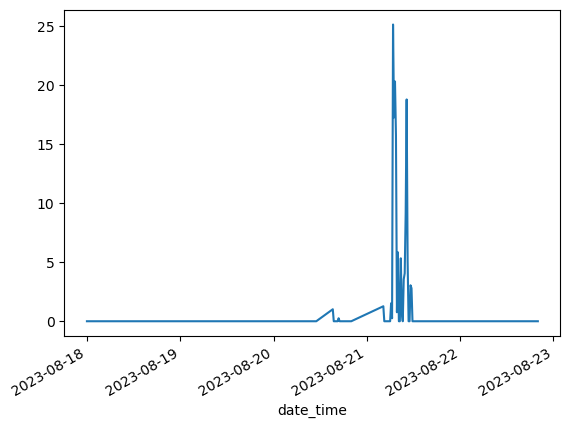

 39%|███▉      | 827/2131 [1:15:16<2:16:28,  6.28s/it]

QC passed, flag = 0


 39%|███▉      | 828/2131 [1:15:20<2:02:38,  5.65s/it]

QC passed, flag = 0


 39%|███▉      | 829/2131 [1:15:35<3:06:06,  8.58s/it]

QC passed, flag = 0


 39%|███▉      | 830/2131 [1:15:40<2:40:00,  7.38s/it]

QC passed, flag = 0


 39%|███▉      | 831/2131 [1:15:44<2:19:30,  6.44s/it]

QC passed, flag = 0


 39%|███▉      | 832/2131 [1:15:49<2:10:55,  6.05s/it]

QC passed, flag = 0


 39%|███▉      | 833/2131 [1:15:56<2:16:03,  6.29s/it]

QC passed, flag = 0


 39%|███▉      | 834/2131 [1:15:59<1:54:46,  5.31s/it]

QC passed, flag = 0


 39%|███▉      | 835/2131 [1:16:06<2:02:52,  5.69s/it]

QC passed, flag = 0


 39%|███▉      | 836/2131 [1:16:19<2:50:48,  7.91s/it]

QC passed, flag = 0


 39%|███▉      | 837/2131 [1:16:33<3:32:06,  9.84s/it]

QC passed, flag = 0


 39%|███▉      | 838/2131 [1:16:33<2:30:25,  6.98s/it]

QC passed, flag = 0


 39%|███▉      | 839/2131 [1:16:35<1:53:44,  5.28s/it]

QC passed, flag = 0


 39%|███▉      | 840/2131 [1:16:36<1:26:38,  4.03s/it]

QC passed, flag = 0


 39%|███▉      | 841/2131 [1:16:37<1:08:10,  3.17s/it]

QC passed, flag = 0


 40%|███▉      | 842/2131 [1:17:16<4:58:00, 13.87s/it]

QC passed, flag = 0


 40%|███▉      | 843/2131 [1:17:19<3:51:16, 10.77s/it]

QC passed, flag = 0


 40%|███▉      | 844/2131 [1:17:24<3:10:08,  8.86s/it]

QC passed, flag = 0


 40%|███▉      | 845/2131 [1:17:25<2:21:14,  6.59s/it]

QC passed, flag = 0


 40%|███▉      | 846/2131 [1:17:26<1:45:59,  4.95s/it]

QC passed, flag = 0


 40%|███▉      | 847/2131 [1:17:30<1:41:33,  4.75s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


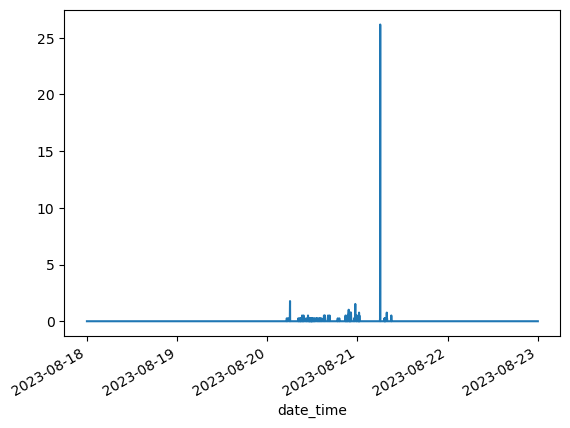

 40%|███▉      | 849/2131 [1:17:45<1:59:28,  5.59s/it]

QC passed, flag = 0


 40%|███▉      | 850/2131 [1:17:59<2:52:32,  8.08s/it]

QC passed, flag = 0


 40%|███▉      | 851/2131 [1:18:03<2:28:36,  6.97s/it]

QC passed, flag = 0


 40%|███▉      | 852/2131 [1:18:08<2:12:00,  6.19s/it]

QC passed, flag = 0


 40%|████      | 853/2131 [1:18:25<3:24:24,  9.60s/it]

QC passed, flag = 0


 40%|████      | 854/2131 [1:18:29<2:49:09,  7.95s/it]

QC passed, flag = 0


 40%|████      | 855/2131 [1:18:43<3:24:46,  9.63s/it]

QC passed, flag = 0


 40%|████      | 856/2131 [1:18:56<3:50:24, 10.84s/it]

QC passed, flag = 0


 40%|████      | 857/2131 [1:19:10<4:06:12, 11.59s/it]

QC passed, flag = 0


 40%|████      | 858/2131 [1:19:13<3:10:40,  8.99s/it]

QC passed, flag = 0


 40%|████      | 859/2131 [1:19:17<2:39:42,  7.53s/it]

QC passed, flag = 0


 40%|████      | 860/2131 [1:19:21<2:18:12,  6.52s/it]

QC passed, flag = 0


 40%|████      | 861/2131 [1:19:37<3:15:16,  9.23s/it]

QC passed, flag = 0


 40%|████      | 862/2131 [1:19:51<3:47:51, 10.77s/it]

QC passed, flag = 0


 40%|████      | 863/2131 [1:19:54<2:57:58,  8.42s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


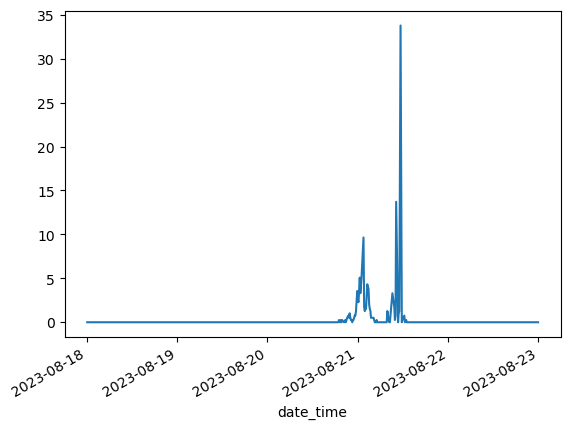

 41%|████      | 865/2131 [1:20:03<2:15:07,  6.40s/it]

QC passed, flag = 0


 41%|████      | 866/2131 [1:20:07<2:01:18,  5.75s/it]

QC passed, flag = 0


 41%|████      | 867/2131 [1:20:08<1:32:31,  4.39s/it]

QC passed, flag = 0


 41%|████      | 868/2131 [1:20:13<1:31:41,  4.36s/it]

QC passed, flag = 0


 41%|████      | 869/2131 [1:20:13<1:07:33,  3.21s/it]

QC passed, flag = 0


 41%|████      | 870/2131 [1:20:29<2:26:15,  6.96s/it]

QC passed, flag = 0


 41%|████      | 871/2131 [1:20:31<1:57:37,  5.60s/it]

QC passed, flag = 0


 41%|████      | 872/2131 [1:20:40<2:15:37,  6.46s/it]

QC passed, flag = 0


 41%|████      | 873/2131 [1:20:44<2:02:01,  5.82s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


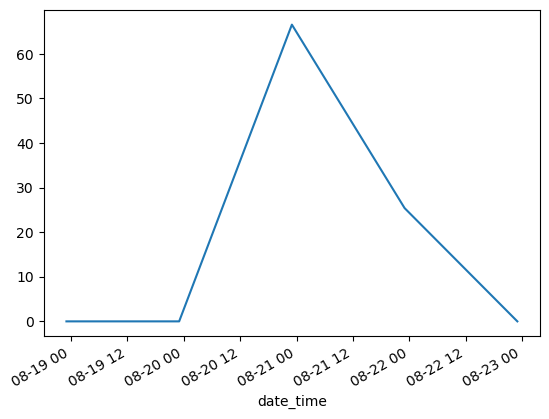

 41%|████      | 874/2131 [1:20:44<1:26:58,  4.15s/it]

QC fail with flag: 1 - not hourly


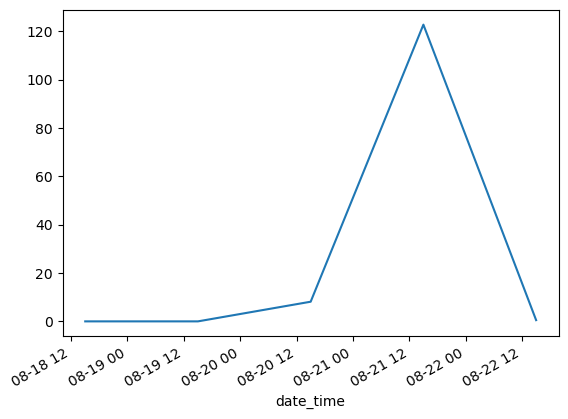

 41%|████      | 875/2131 [1:20:44<1:01:53,  2.96s/it]

QC fail with flag: 1 - not hourly


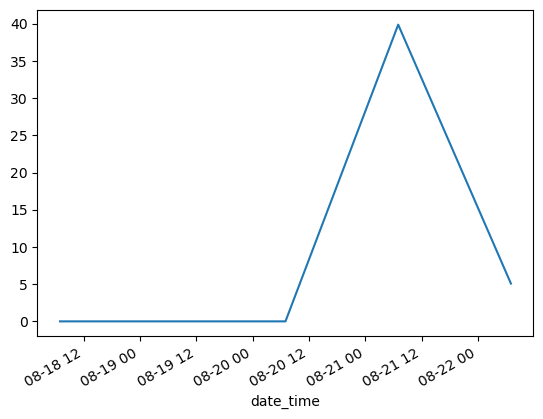

 41%|████      | 877/2131 [1:20:47<46:56,  2.25s/it]  

QC passed, flag = 0


 41%|████      | 878/2131 [1:20:51<58:31,  2.80s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


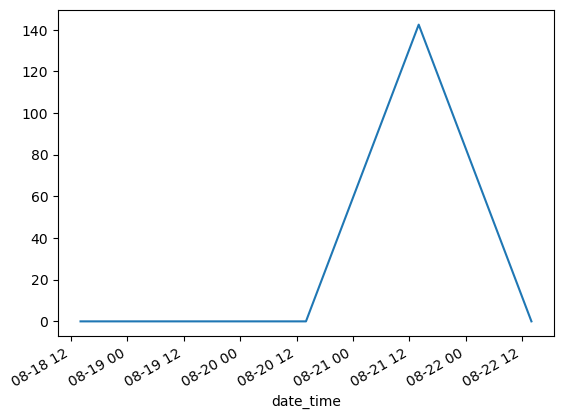

 41%|████      | 879/2131 [1:20:51<42:01,  2.01s/it]

QC fail with flag: 1 - not hourly


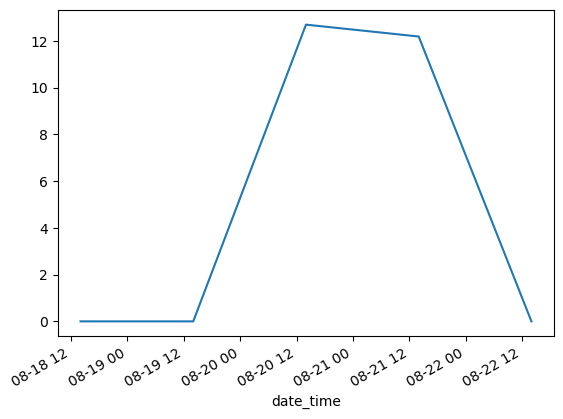

 41%|████▏     | 880/2131 [1:20:52<30:28,  1.46s/it]

QC fail with flag: 1 - not hourly


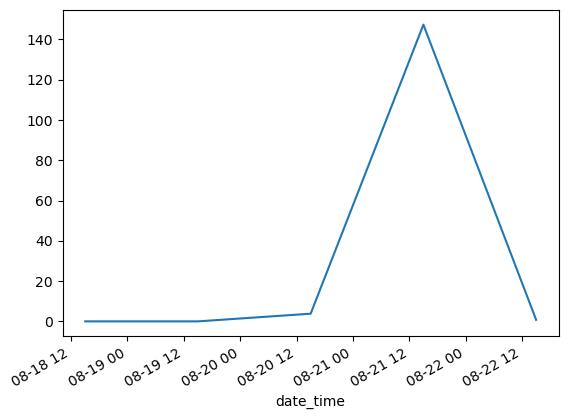

 41%|████▏     | 882/2131 [1:20:56<42:32,  2.04s/it]

QC passed, flag = 0


 41%|████▏     | 883/2131 [1:21:01<58:03,  2.79s/it]

QC passed, flag = 0


 41%|████▏     | 884/2131 [1:21:05<1:07:45,  3.26s/it]

QC passed, flag = 0


 42%|████▏     | 885/2131 [1:21:09<1:14:02,  3.57s/it]

QC passed, flag = 0


 42%|████▏     | 886/2131 [1:21:14<1:20:32,  3.88s/it]

QC passed, flag = 0


 42%|████▏     | 887/2131 [1:21:19<1:25:31,  4.12s/it]

QC passed, flag = 0


 42%|████▏     | 888/2131 [1:21:35<2:41:16,  7.78s/it]

QC passed, flag = 0


 42%|████▏     | 889/2131 [1:21:39<2:20:33,  6.79s/it]

QC passed, flag = 0


 42%|████▏     | 890/2131 [1:21:55<3:16:25,  9.50s/it]

QC passed, flag = 0


 42%|████▏     | 891/2131 [1:22:00<2:47:58,  8.13s/it]

QC passed, flag = 0


 42%|████▏     | 892/2131 [1:22:04<2:24:35,  7.00s/it]

QC passed, flag = 0


 42%|████▏     | 893/2131 [1:22:08<2:05:08,  6.07s/it]

QC passed, flag = 0


 42%|████▏     | 894/2131 [1:22:11<1:45:57,  5.14s/it]

QC passed, flag = 0


 42%|████▏     | 895/2131 [1:22:15<1:36:19,  4.68s/it]

QC passed, flag = 0


 42%|████▏     | 896/2131 [1:22:18<1:25:19,  4.15s/it]

QC passed, flag = 0


 42%|████▏     | 897/2131 [1:22:21<1:19:40,  3.87s/it]

QC passed, flag = 0


 42%|████▏     | 898/2131 [1:22:24<1:14:43,  3.64s/it]

QC passed, flag = 0


 42%|████▏     | 899/2131 [1:22:25<55:11,  2.69s/it]  

QC passed, flag = 0


 42%|████▏     | 900/2131 [1:22:27<55:25,  2.70s/it]

QC passed, flag = 0


 42%|████▏     | 901/2131 [1:22:30<56:06,  2.74s/it]

QC passed, flag = 0


 42%|████▏     | 902/2131 [1:22:35<1:06:32,  3.25s/it]

QC passed, flag = 0


 42%|████▏     | 903/2131 [1:22:37<1:02:12,  3.04s/it]

QC passed, flag = 0


 42%|████▏     | 904/2131 [1:22:39<55:30,  2.71s/it]  

QC passed, flag = 0


 42%|████▏     | 905/2131 [1:22:42<53:31,  2.62s/it]

QC passed, flag = 0


 43%|████▎     | 906/2131 [1:22:42<42:11,  2.07s/it]

QC passed, flag = 0


 43%|████▎     | 907/2131 [1:22:45<45:04,  2.21s/it]

QC passed, flag = 0


 43%|████▎     | 908/2131 [1:22:47<42:22,  2.08s/it]

QC passed, flag = 0


 43%|████▎     | 909/2131 [1:22:50<48:29,  2.38s/it]

QC passed, flag = 0


 43%|████▎     | 910/2131 [1:22:51<40:27,  1.99s/it]

QC passed, flag = 0


 43%|████▎     | 911/2131 [1:22:52<36:03,  1.77s/it]

QC passed, flag = 0


 43%|████▎     | 912/2131 [1:22:54<36:04,  1.78s/it]

QC passed, flag = 0


 43%|████▎     | 913/2131 [1:22:57<42:55,  2.11s/it]

QC passed, flag = 0


 43%|████▎     | 914/2131 [1:22:57<33:01,  1.63s/it]

QC passed, flag = 0


 43%|████▎     | 915/2131 [1:23:00<42:45,  2.11s/it]

QC passed, flag = 0


 43%|████▎     | 916/2131 [1:23:02<38:38,  1.91s/it]

QC passed, flag = 0


 43%|████▎     | 917/2131 [1:23:05<44:40,  2.21s/it]

QC passed, flag = 0


 43%|████▎     | 918/2131 [1:23:08<49:16,  2.44s/it]

QC passed, flag = 0


 43%|████▎     | 919/2131 [1:23:10<50:14,  2.49s/it]

QC passed, flag = 0


 43%|████▎     | 920/2131 [1:23:13<49:38,  2.46s/it]

QC passed, flag = 0


 43%|████▎     | 921/2131 [1:23:15<45:54,  2.28s/it]

QC passed, flag = 0


 43%|████▎     | 922/2131 [1:23:18<49:51,  2.47s/it]

QC passed, flag = 0


 43%|████▎     | 923/2131 [1:23:20<49:41,  2.47s/it]

QC passed, flag = 0


 43%|████▎     | 924/2131 [1:23:23<49:39,  2.47s/it]

QC passed, flag = 0


 43%|████▎     | 925/2131 [1:23:26<53:10,  2.65s/it]

QC passed, flag = 0


 43%|████▎     | 926/2131 [1:23:28<49:51,  2.48s/it]

QC passed, flag = 0


 44%|████▎     | 927/2131 [1:23:31<53:21,  2.66s/it]

QC passed, flag = 0


 44%|████▎     | 928/2131 [1:23:34<55:06,  2.75s/it]

QC passed, flag = 0


 44%|████▎     | 929/2131 [1:23:37<55:24,  2.77s/it]

QC passed, flag = 0


 44%|████▎     | 930/2131 [1:23:40<58:06,  2.90s/it]

QC passed, flag = 0


 44%|████▎     | 931/2131 [1:23:43<1:02:55,  3.15s/it]

QC passed, flag = 0


 44%|████▎     | 932/2131 [1:23:46<59:51,  3.00s/it]  

QC passed, flag = 0


 44%|████▍     | 933/2131 [1:23:49<59:47,  2.99s/it]

QC passed, flag = 0


 44%|████▍     | 934/2131 [1:23:52<56:47,  2.85s/it]

QC passed, flag = 0


 44%|████▍     | 935/2131 [1:23:54<55:35,  2.79s/it]

QC passed, flag = 0


 44%|████▍     | 936/2131 [1:23:56<51:18,  2.58s/it]

QC passed, flag = 0


 44%|████▍     | 937/2131 [1:23:59<51:25,  2.58s/it]

QC passed, flag = 0


 44%|████▍     | 938/2131 [1:24:02<52:22,  2.63s/it]

QC passed, flag = 0


 44%|████▍     | 939/2131 [1:24:04<51:53,  2.61s/it]

QC passed, flag = 0


 44%|████▍     | 940/2131 [1:24:07<52:25,  2.64s/it]

QC passed, flag = 0


 44%|████▍     | 941/2131 [1:24:10<55:48,  2.81s/it]

QC passed, flag = 0


 44%|████▍     | 942/2131 [1:24:13<55:28,  2.80s/it]

QC passed, flag = 0


 44%|████▍     | 943/2131 [1:24:16<54:51,  2.77s/it]

QC passed, flag = 0


 44%|████▍     | 944/2131 [1:24:16<42:32,  2.15s/it]

QC passed, flag = 0


 44%|████▍     | 945/2131 [1:24:19<48:06,  2.43s/it]

QC passed, flag = 0


 44%|████▍     | 946/2131 [1:24:22<49:44,  2.52s/it]

QC passed, flag = 0


 44%|████▍     | 947/2131 [1:24:25<49:28,  2.51s/it]

QC passed, flag = 0


 44%|████▍     | 948/2131 [1:24:27<50:56,  2.58s/it]

QC passed, flag = 0


 45%|████▍     | 949/2131 [1:24:31<55:08,  2.80s/it]

QC passed, flag = 0


 45%|████▍     | 950/2131 [1:24:35<1:04:55,  3.30s/it]

QC passed, flag = 0


 45%|████▍     | 951/2131 [1:24:36<52:40,  2.68s/it]  

QC passed, flag = 0


 45%|████▍     | 952/2131 [1:24:38<43:43,  2.23s/it]

QC passed, flag = 0


 45%|████▍     | 953/2131 [1:24:53<2:01:42,  6.20s/it]

QC passed, flag = 0


 45%|████▍     | 954/2131 [1:24:58<1:52:11,  5.72s/it]

QC passed, flag = 0


 45%|████▍     | 955/2131 [1:25:04<1:56:04,  5.92s/it]

QC passed, flag = 0


 45%|████▍     | 956/2131 [1:25:21<2:58:42,  9.13s/it]

QC passed, flag = 0


 45%|████▍     | 957/2131 [1:25:26<2:38:39,  8.11s/it]

QC passed, flag = 0


 45%|████▍     | 958/2131 [1:25:40<3:12:30,  9.85s/it]

QC passed, flag = 0


 45%|████▌     | 959/2131 [1:25:45<2:43:14,  8.36s/it]

QC passed, flag = 0


 45%|████▌     | 960/2131 [1:25:47<2:03:12,  6.31s/it]

QC passed, flag = 0


 45%|████▌     | 961/2131 [1:26:01<2:50:40,  8.75s/it]

QC passed, flag = 0


 45%|████▌     | 962/2131 [1:26:16<3:24:05, 10.47s/it]

QC passed, flag = 0


 45%|████▌     | 963/2131 [1:26:30<3:46:02, 11.61s/it]

QC passed, flag = 0


 45%|████▌     | 964/2131 [1:26:35<3:07:54,  9.66s/it]

QC passed, flag = 0


 45%|████▌     | 965/2131 [1:26:40<2:39:05,  8.19s/it]

QC passed, flag = 0


 45%|████▌     | 966/2131 [1:26:44<2:17:33,  7.08s/it]

QC passed, flag = 0


 45%|████▌     | 967/2131 [1:26:58<2:55:58,  9.07s/it]

QC passed, flag = 0


 45%|████▌     | 968/2131 [1:27:04<2:35:26,  8.02s/it]

QC passed, flag = 0


 45%|████▌     | 969/2131 [1:27:18<3:11:17,  9.88s/it]

QC passed, flag = 0


 46%|████▌     | 970/2131 [1:27:23<2:43:35,  8.45s/it]

QC passed, flag = 0


 46%|████▌     | 971/2131 [1:27:37<3:18:06, 10.25s/it]

QC passed, flag = 0


 46%|████▌     | 972/2131 [1:27:52<3:41:54, 11.49s/it]

QC passed, flag = 0


 46%|████▌     | 973/2131 [1:27:57<3:03:46,  9.52s/it]

QC passed, flag = 0


 46%|████▌     | 974/2131 [1:28:12<3:35:35, 11.18s/it]

QC passed, flag = 0


 46%|████▌     | 975/2131 [1:28:13<2:38:33,  8.23s/it]

QC passed, flag = 0


 46%|████▌     | 976/2131 [1:28:26<3:04:30,  9.59s/it]

QC passed, flag = 0


 46%|████▌     | 977/2131 [1:28:39<3:27:02, 10.76s/it]

QC passed, flag = 0


 46%|████▌     | 978/2131 [1:28:52<3:36:37, 11.27s/it]

QC passed, flag = 0


 46%|████▌     | 979/2131 [1:29:05<3:49:07, 11.93s/it]

QC passed, flag = 0


 46%|████▌     | 980/2131 [1:29:19<3:57:49, 12.40s/it]

QC passed, flag = 0


 46%|████▌     | 981/2131 [1:29:25<3:25:09, 10.70s/it]

QC passed, flag = 0


 46%|████▌     | 982/2131 [1:29:35<3:21:01, 10.50s/it]

QC passed, flag = 0


 46%|████▌     | 983/2131 [1:29:45<3:17:20, 10.31s/it]

QC passed, flag = 0


 46%|████▌     | 984/2131 [1:29:50<2:42:26,  8.50s/it]

QC passed, flag = 0


 46%|████▌     | 985/2131 [1:29:53<2:13:51,  7.01s/it]

QC passed, flag = 0


 46%|████▋     | 986/2131 [1:30:06<2:46:13,  8.71s/it]

QC passed, flag = 0


 46%|████▋     | 987/2131 [1:30:19<3:10:06,  9.97s/it]

QC passed, flag = 0


 46%|████▋     | 988/2131 [1:30:26<2:52:26,  9.05s/it]

QC passed, flag = 0


 46%|████▋     | 989/2131 [1:30:27<2:07:05,  6.68s/it]

QC passed, flag = 0


 46%|████▋     | 990/2131 [1:30:29<1:39:35,  5.24s/it]

QC passed, flag = 0


 47%|████▋     | 991/2131 [1:30:30<1:16:36,  4.03s/it]

QC passed, flag = 0


 47%|████▋     | 992/2131 [1:30:31<1:00:00,  3.16s/it]

QC passed, flag = 0


 47%|████▋     | 993/2131 [1:30:32<48:39,  2.57s/it]  

QC passed, flag = 0


 47%|████▋     | 994/2131 [1:30:33<41:03,  2.17s/it]

QC passed, flag = 0


 47%|████▋     | 995/2131 [1:30:35<35:41,  1.89s/it]

QC passed, flag = 0


 47%|████▋     | 996/2131 [1:30:37<37:51,  2.00s/it]

QC passed, flag = 0


 47%|████▋     | 997/2131 [1:30:38<33:35,  1.78s/it]

QC passed, flag = 0


 47%|████▋     | 998/2131 [1:30:39<30:11,  1.60s/it]

QC passed, flag = 0


 47%|████▋     | 999/2131 [1:30:43<44:01,  2.33s/it]

QC passed, flag = 0


 47%|████▋     | 1000/2131 [1:30:45<37:50,  2.01s/it]

QC passed, flag = 0


 47%|████▋     | 1001/2131 [1:30:46<33:36,  1.78s/it]

QC passed, flag = 0


 47%|████▋     | 1002/2131 [1:30:47<30:33,  1.62s/it]

QC passed, flag = 0


 47%|████▋     | 1003/2131 [1:30:48<28:33,  1.52s/it]

QC passed, flag = 0


 47%|████▋     | 1004/2131 [1:31:00<1:27:54,  4.68s/it]

QC passed, flag = 0


 47%|████▋     | 1005/2131 [1:31:02<1:09:25,  3.70s/it]

QC passed, flag = 0


 47%|████▋     | 1006/2131 [1:31:03<55:44,  2.97s/it]  

QC passed, flag = 0


 47%|████▋     | 1007/2131 [1:31:04<45:54,  2.45s/it]

QC passed, flag = 0


 47%|████▋     | 1008/2131 [1:31:12<1:16:33,  4.09s/it]

QC passed, flag = 0


 47%|████▋     | 1009/2131 [1:31:14<1:00:46,  3.25s/it]

QC passed, flag = 0


 47%|████▋     | 1010/2131 [1:31:14<47:22,  2.54s/it]  

QC passed, flag = 0


 47%|████▋     | 1011/2131 [1:31:19<57:54,  3.10s/it]

QC passed, flag = 0


 47%|████▋     | 1012/2131 [1:31:20<44:08,  2.37s/it]

QC passed, flag = 0


 48%|████▊     | 1013/2131 [1:31:31<1:34:38,  5.08s/it]

QC passed, flag = 0


 48%|████▊     | 1014/2131 [1:31:35<1:30:09,  4.84s/it]

QC passed, flag = 0


 48%|████▊     | 1015/2131 [1:31:49<2:18:17,  7.44s/it]

QC passed, flag = 0


 48%|████▊     | 1016/2131 [1:31:50<1:44:21,  5.62s/it]

QC passed, flag = 0


 48%|████▊     | 1017/2131 [1:31:54<1:37:23,  5.25s/it]

QC passed, flag = 0


 48%|████▊     | 1018/2131 [1:31:57<1:22:23,  4.44s/it]

QC passed, flag = 0


 48%|████▊     | 1019/2131 [1:32:04<1:34:53,  5.12s/it]

QC passed, flag = 0


 48%|████▊     | 1020/2131 [1:32:05<1:13:06,  3.95s/it]

QC passed, flag = 0


 48%|████▊     | 1021/2131 [1:32:06<57:49,  3.13s/it]  

QC passed, flag = 0


 48%|████▊     | 1022/2131 [1:32:07<47:06,  2.55s/it]

QC passed, flag = 0


 48%|████▊     | 1023/2131 [1:32:09<39:45,  2.15s/it]

QC passed, flag = 0


 48%|████▊     | 1024/2131 [1:32:10<34:35,  1.87s/it]

QC passed, flag = 0


 48%|████▊     | 1025/2131 [1:32:11<30:53,  1.68s/it]

QC passed, flag = 0


 48%|████▊     | 1026/2131 [1:32:25<1:36:34,  5.24s/it]

QC passed, flag = 0


 48%|████▊     | 1027/2131 [1:32:26<1:15:06,  4.08s/it]

QC passed, flag = 0


 48%|████▊     | 1028/2131 [1:32:31<1:19:11,  4.31s/it]

QC passed, flag = 0


 48%|████▊     | 1029/2131 [1:32:44<2:08:11,  6.98s/it]

QC passed, flag = 0


 48%|████▊     | 1030/2131 [1:32:48<1:54:01,  6.21s/it]

QC passed, flag = 0


 48%|████▊     | 1031/2131 [1:33:02<2:34:45,  8.44s/it]

QC passed, flag = 0


 48%|████▊     | 1032/2131 [1:33:03<1:54:08,  6.23s/it]

QC passed, flag = 0


 48%|████▊     | 1033/2131 [1:33:08<1:45:02,  5.74s/it]

QC passed, flag = 0


 49%|████▊     | 1034/2131 [1:33:15<1:52:33,  6.16s/it]

QC passed, flag = 0


 49%|████▊     | 1035/2131 [1:33:22<1:58:33,  6.49s/it]

QC passed, flag = 0


 49%|████▊     | 1036/2131 [1:33:24<1:33:52,  5.14s/it]

QC passed, flag = 0


 49%|████▊     | 1037/2131 [1:33:25<1:11:58,  3.95s/it]

QC passed, flag = 0


 49%|████▊     | 1038/2131 [1:33:26<56:29,  3.10s/it]  

QC passed, flag = 0


 49%|████▉     | 1039/2131 [1:33:40<1:51:42,  6.14s/it]

QC passed, flag = 0


 49%|████▉     | 1040/2131 [1:33:41<1:24:22,  4.64s/it]

QC passed, flag = 0


 49%|████▉     | 1041/2131 [1:33:41<1:00:46,  3.35s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


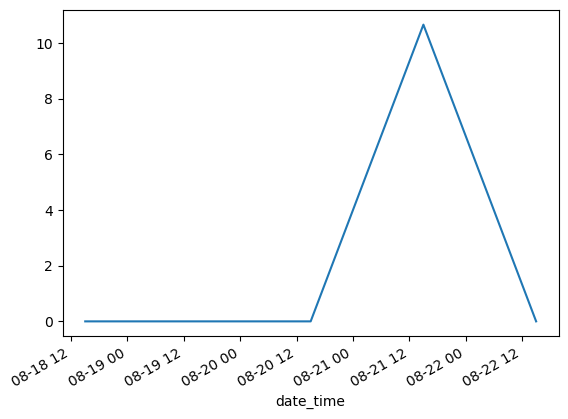

 49%|████▉     | 1042/2131 [1:33:41<43:24,  2.39s/it]  

QC fail with flag: 1 - not hourly


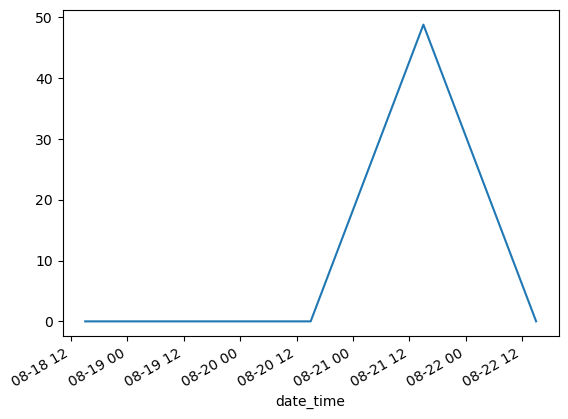

 49%|████▉     | 1043/2131 [1:33:41<31:18,  1.73s/it]

QC fail with flag: 1 - not hourly


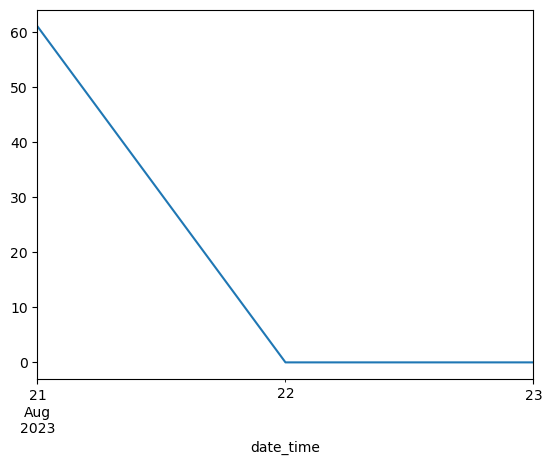

 49%|████▉     | 1044/2131 [1:33:42<22:33,  1.25s/it]

QC fail with flag: 1 - not hourly


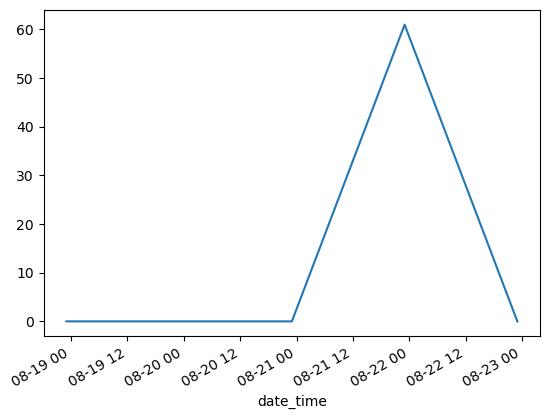

 49%|████▉     | 1045/2131 [1:33:42<16:41,  1.08it/s]

QC fail with flag: 1 - not hourly


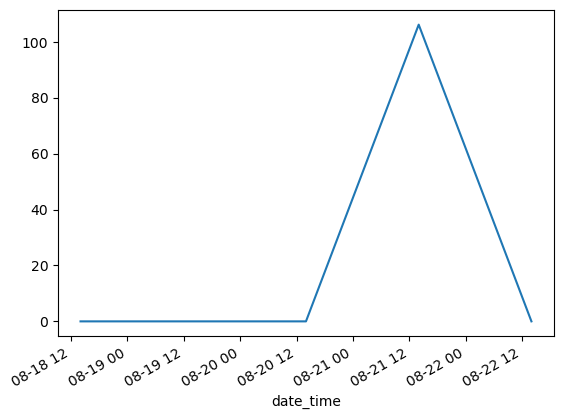

 49%|████▉     | 1047/2131 [1:33:42<09:36,  1.88it/s]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


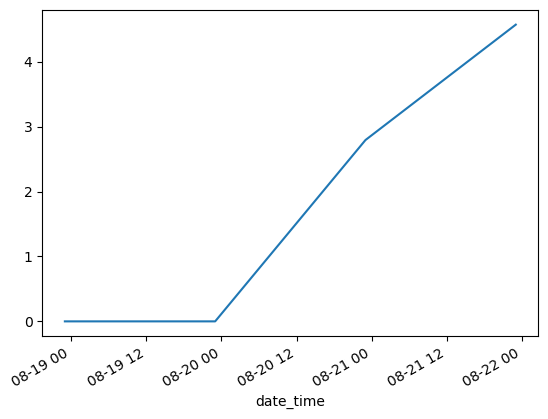

 49%|████▉     | 1048/2131 [1:33:42<07:32,  2.39it/s]

QC fail with flag: 1 - not hourly


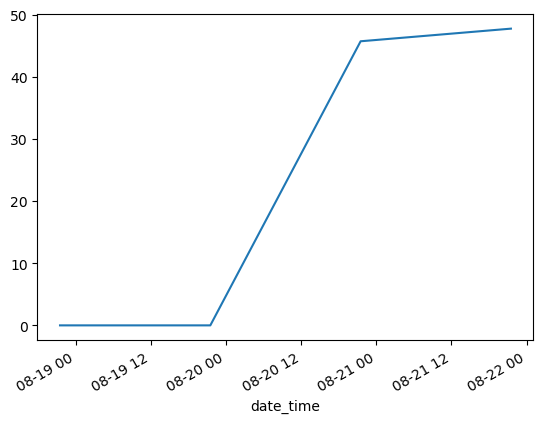

 49%|████▉     | 1050/2131 [1:33:43<06:33,  2.75it/s]

QC passed, flag = 0


 49%|████▉     | 1051/2131 [1:33:44<11:00,  1.64it/s]

QC passed, flag = 0


 49%|████▉     | 1052/2131 [1:33:49<35:47,  1.99s/it]

QC passed, flag = 0


 49%|████▉     | 1053/2131 [1:33:54<50:37,  2.82s/it]

QC passed, flag = 0


 49%|████▉     | 1054/2131 [1:34:08<1:50:00,  6.13s/it]

QC passed, flag = 0


 50%|████▉     | 1055/2131 [1:34:13<1:42:22,  5.71s/it]

QC passed, flag = 0


 50%|████▉     | 1056/2131 [1:34:15<1:24:35,  4.72s/it]

QC passed, flag = 0


 50%|████▉     | 1057/2131 [1:34:16<1:03:48,  3.56s/it]

QC passed, flag = 0


 50%|████▉     | 1058/2131 [1:34:19<59:18,  3.32s/it]  

QC passed, flag = 0


 50%|████▉     | 1059/2131 [1:34:21<53:58,  3.02s/it]

QC passed, flag = 0


 50%|████▉     | 1060/2131 [1:34:23<49:20,  2.76s/it]

QC passed, flag = 0


 50%|████▉     | 1061/2131 [1:34:26<49:02,  2.75s/it]

QC passed, flag = 0


 50%|████▉     | 1062/2131 [1:34:28<46:12,  2.59s/it]

QC passed, flag = 0


 50%|████▉     | 1063/2131 [1:34:31<47:11,  2.65s/it]

QC passed, flag = 0


 50%|████▉     | 1064/2131 [1:34:32<39:06,  2.20s/it]

QC passed, flag = 0


 50%|████▉     | 1065/2131 [1:34:34<38:40,  2.18s/it]

QC passed, flag = 0


 50%|█████     | 1066/2131 [1:34:36<38:48,  2.19s/it]

QC passed, flag = 0


 50%|█████     | 1067/2131 [1:34:37<30:18,  1.71s/it]

QC passed, flag = 0


 50%|█████     | 1068/2131 [1:34:38<25:52,  1.46s/it]

QC passed, flag = 0


 50%|█████     | 1069/2131 [1:34:40<29:17,  1.65s/it]

QC passed, flag = 0


 50%|█████     | 1070/2131 [1:34:41<24:52,  1.41s/it]

QC passed, flag = 0


 50%|█████     | 1071/2131 [1:34:41<21:18,  1.21s/it]

QC passed, flag = 0


 50%|█████     | 1072/2131 [1:34:44<26:45,  1.52s/it]

QC passed, flag = 0


 50%|█████     | 1073/2131 [1:34:48<42:45,  2.42s/it]

QC passed, flag = 0


 50%|█████     | 1074/2131 [1:34:50<37:03,  2.10s/it]

QC passed, flag = 0


 50%|█████     | 1075/2131 [1:34:51<31:24,  1.78s/it]

QC passed, flag = 0


 50%|█████     | 1076/2131 [1:34:51<24:42,  1.40s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


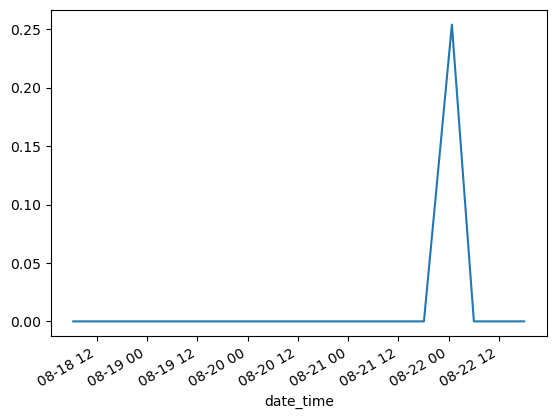

 51%|█████     | 1078/2131 [1:34:53<23:13,  1.32s/it]

QC passed, flag = 0


 51%|█████     | 1079/2131 [1:34:54<18:42,  1.07s/it]

QC passed, flag = 0


 51%|█████     | 1080/2131 [1:34:54<15:21,  1.14it/s]

QC passed, flag = 0


 51%|█████     | 1081/2131 [1:34:57<24:52,  1.42s/it]

QC passed, flag = 0


 51%|█████     | 1082/2131 [1:35:00<31:15,  1.79s/it]

QC passed, flag = 0


 51%|█████     | 1083/2131 [1:35:02<32:46,  1.88s/it]

QC passed, flag = 0


 51%|█████     | 1084/2131 [1:35:05<40:02,  2.29s/it]

QC passed, flag = 0


 51%|█████     | 1085/2131 [1:35:09<46:52,  2.69s/it]

QC passed, flag = 0


 51%|█████     | 1086/2131 [1:35:11<47:48,  2.75s/it]

QC passed, flag = 0


 51%|█████     | 1087/2131 [1:35:14<46:50,  2.69s/it]

QC passed, flag = 0


 51%|█████     | 1088/2131 [1:35:18<51:53,  2.99s/it]

QC passed, flag = 0


 51%|█████     | 1089/2131 [1:35:20<46:54,  2.70s/it]

QC passed, flag = 0


 51%|█████     | 1090/2131 [1:35:21<37:52,  2.18s/it]

QC passed, flag = 0


 51%|█████     | 1091/2131 [1:35:34<1:37:25,  5.62s/it]

QC passed, flag = 0


 51%|█████     | 1092/2131 [1:35:37<1:22:31,  4.77s/it]

QC passed, flag = 0


 51%|█████▏    | 1093/2131 [1:35:40<1:11:12,  4.12s/it]

QC passed, flag = 0


 51%|█████▏    | 1094/2131 [1:35:43<1:05:46,  3.81s/it]

QC passed, flag = 0


 51%|█████▏    | 1095/2131 [1:35:45<57:08,  3.31s/it]  

QC passed, flag = 0


 51%|█████▏    | 1096/2131 [1:35:48<53:50,  3.12s/it]

QC passed, flag = 0


 51%|█████▏    | 1097/2131 [1:35:49<43:19,  2.51s/it]

QC passed, flag = 0


 52%|█████▏    | 1098/2131 [1:35:52<45:06,  2.62s/it]

QC passed, flag = 0


 52%|█████▏    | 1099/2131 [1:35:52<33:12,  1.93s/it]

QC passed, flag = 0


 52%|█████▏    | 1100/2131 [1:35:53<28:08,  1.64s/it]

QC passed, flag = 0


 52%|█████▏    | 1101/2131 [1:35:53<22:31,  1.31s/it]

QC passed, flag = 0


 52%|█████▏    | 1102/2131 [1:35:54<18:18,  1.07s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


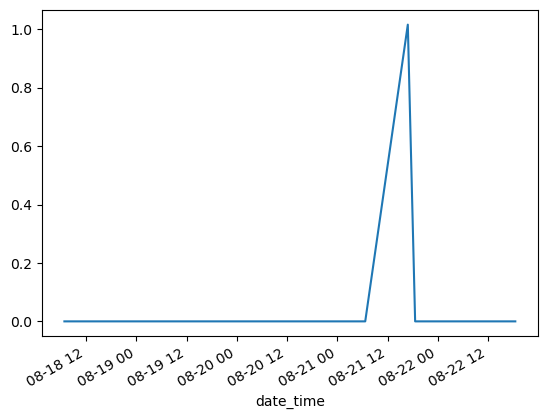

 52%|█████▏    | 1104/2131 [1:35:56<21:04,  1.23s/it]

QC passed, flag = 0


 52%|█████▏    | 1105/2131 [1:35:57<17:53,  1.05s/it]

QC passed, flag = 0


 52%|█████▏    | 1106/2131 [1:35:59<20:47,  1.22s/it]

QC passed, flag = 0


 52%|█████▏    | 1107/2131 [1:36:01<27:27,  1.61s/it]

QC passed, flag = 0


 52%|█████▏    | 1108/2131 [1:36:01<20:47,  1.22s/it]

QC passed, flag = 0


 52%|█████▏    | 1109/2131 [1:36:02<16:58,  1.00it/s]

QC passed, flag = 0


 52%|█████▏    | 1110/2131 [1:36:03<15:44,  1.08it/s]

QC passed, flag = 0


 52%|█████▏    | 1111/2131 [1:36:04<15:42,  1.08it/s]

QC passed, flag = 0


 52%|█████▏    | 1112/2131 [1:36:04<12:57,  1.31it/s]

QC passed, flag = 0


 52%|█████▏    | 1113/2131 [1:36:05<13:20,  1.27it/s]

QC passed, flag = 0


 52%|█████▏    | 1114/2131 [1:36:07<22:21,  1.32s/it]

QC passed, flag = 0


 52%|█████▏    | 1115/2131 [1:36:09<24:35,  1.45s/it]

QC passed, flag = 0


 52%|█████▏    | 1116/2131 [1:36:10<19:52,  1.17s/it]

QC passed, flag = 0


 52%|█████▏    | 1118/2131 [1:36:10<11:58,  1.41it/s]

QC passed, flag = 0
QC passed, flag = 0


 53%|█████▎    | 1119/2131 [1:36:14<29:27,  1.75s/it]

QC passed, flag = 0


 53%|█████▎    | 1120/2131 [1:36:16<26:53,  1.60s/it]

QC passed, flag = 0


 53%|█████▎    | 1121/2131 [1:36:27<1:17:59,  4.63s/it]

QC passed, flag = 0


 53%|█████▎    | 1122/2131 [1:36:41<2:01:07,  7.20s/it]

QC passed, flag = 0


 53%|█████▎    | 1123/2131 [1:36:46<1:52:27,  6.69s/it]

QC passed, flag = 0


 53%|█████▎    | 1124/2131 [1:37:00<2:27:55,  8.81s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


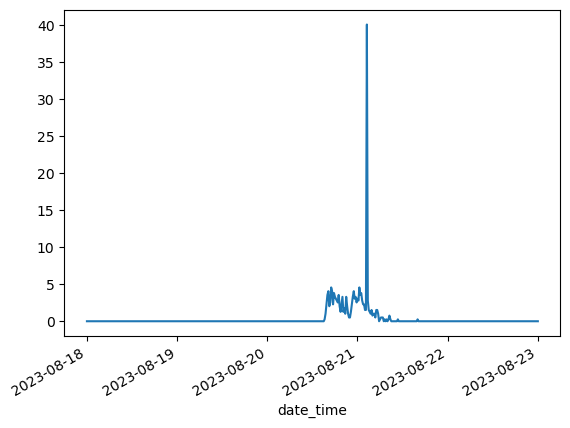

 53%|█████▎    | 1126/2131 [1:37:08<1:47:49,  6.44s/it]

QC passed, flag = 0


 53%|█████▎    | 1127/2131 [1:37:23<2:29:48,  8.95s/it]

QC passed, flag = 0


 53%|█████▎    | 1128/2131 [1:37:26<2:03:18,  7.38s/it]

QC passed, flag = 0


 53%|█████▎    | 1129/2131 [1:37:40<2:36:58,  9.40s/it]

QC passed, flag = 0


 53%|█████▎    | 1130/2131 [1:37:45<2:11:43,  7.90s/it]

QC passed, flag = 0


 53%|█████▎    | 1131/2131 [1:37:54<2:19:43,  8.38s/it]

QC passed, flag = 0


 53%|█████▎    | 1132/2131 [1:38:08<2:44:51,  9.90s/it]

QC passed, flag = 0


 53%|█████▎    | 1133/2131 [1:38:11<2:12:06,  7.94s/it]

QC passed, flag = 0


 53%|█████▎    | 1134/2131 [1:38:12<1:38:19,  5.92s/it]

QC passed, flag = 0


 53%|█████▎    | 1135/2131 [1:38:14<1:16:52,  4.63s/it]

QC passed, flag = 0


 53%|█████▎    | 1136/2131 [1:38:16<1:04:23,  3.88s/it]

QC passed, flag = 0


 53%|█████▎    | 1137/2131 [1:38:18<56:18,  3.40s/it]  

QC passed, flag = 0


 53%|█████▎    | 1138/2131 [1:38:20<45:47,  2.77s/it]

QC passed, flag = 0


 53%|█████▎    | 1139/2131 [1:38:21<38:00,  2.30s/it]

QC passed, flag = 0


 53%|█████▎    | 1140/2131 [1:38:22<32:36,  1.97s/it]

QC passed, flag = 0


 54%|█████▎    | 1141/2131 [1:38:23<28:51,  1.75s/it]

QC passed, flag = 0


 54%|█████▎    | 1142/2131 [1:38:25<26:18,  1.60s/it]

QC passed, flag = 0


 54%|█████▎    | 1143/2131 [1:38:26<24:25,  1.48s/it]

QC passed, flag = 0


 54%|█████▎    | 1144/2131 [1:38:27<22:59,  1.40s/it]

QC passed, flag = 0


 54%|█████▎    | 1145/2131 [1:38:36<1:02:56,  3.83s/it]

QC passed, flag = 0


 54%|█████▍    | 1146/2131 [1:38:40<1:01:42,  3.76s/it]

QC passed, flag = 0


 54%|█████▍    | 1147/2131 [1:38:41<49:01,  2.99s/it]  

QC passed, flag = 0


 54%|█████▍    | 1148/2131 [1:38:42<40:28,  2.47s/it]

QC passed, flag = 0


 54%|█████▍    | 1149/2131 [1:38:46<43:31,  2.66s/it]

QC passed, flag = 0


 54%|█████▍    | 1150/2131 [1:38:48<43:11,  2.64s/it]

QC passed, flag = 0


 54%|█████▍    | 1151/2131 [1:38:49<33:40,  2.06s/it]

QC passed, flag = 0


 54%|█████▍    | 1152/2131 [1:38:49<25:05,  1.54s/it]

QC passed, flag = 0


 54%|█████▍    | 1153/2131 [1:39:03<1:25:08,  5.22s/it]

QC passed, flag = 0


 54%|█████▍    | 1154/2131 [1:39:17<2:07:56,  7.86s/it]

QC passed, flag = 0


 54%|█████▍    | 1155/2131 [1:39:22<1:51:58,  6.88s/it]

QC passed, flag = 0


 54%|█████▍    | 1156/2131 [1:39:28<1:50:10,  6.78s/it]

QC passed, flag = 0


 54%|█████▍    | 1157/2131 [1:39:29<1:20:49,  4.98s/it]

QC passed, flag = 0


 54%|█████▍    | 1158/2131 [1:39:35<1:27:16,  5.38s/it]

QC passed, flag = 0


 54%|█████▍    | 1159/2131 [1:39:36<1:06:35,  4.11s/it]

QC passed, flag = 0


 54%|█████▍    | 1160/2131 [1:39:41<1:10:43,  4.37s/it]

QC passed, flag = 0


 54%|█████▍    | 1161/2131 [1:39:51<1:36:40,  5.98s/it]

QC passed, flag = 0


 55%|█████▍    | 1162/2131 [1:40:05<2:13:11,  8.25s/it]

QC passed, flag = 0


 55%|█████▍    | 1163/2131 [1:40:19<2:41:36, 10.02s/it]

QC passed, flag = 0


 55%|█████▍    | 1164/2131 [1:40:26<2:28:00,  9.18s/it]

QC passed, flag = 0


 55%|█████▍    | 1165/2131 [1:40:40<2:48:32, 10.47s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


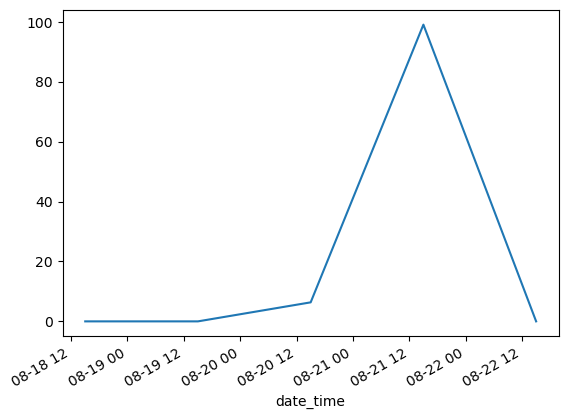

 55%|█████▍    | 1168/2131 [1:40:44<1:11:20,  4.44s/it]

QC passed, flag = 0
QC passed, flag = 0


 55%|█████▍    | 1169/2131 [1:40:44<53:42,  3.35s/it]  

QC passed, flag = 0


 55%|█████▍    | 1170/2131 [1:40:46<43:00,  2.68s/it]

QC passed, flag = 0


 55%|█████▍    | 1171/2131 [1:40:47<35:23,  2.21s/it]

QC passed, flag = 0


 55%|█████▍    | 1172/2131 [1:40:49<36:18,  2.27s/it]

QC passed, flag = 0


 55%|█████▌    | 1173/2131 [1:40:50<29:48,  1.87s/it]

QC passed, flag = 0


 55%|█████▌    | 1174/2131 [1:40:50<21:50,  1.37s/it]

QC passed, flag = 0


 55%|█████▌    | 1175/2131 [1:40:50<16:38,  1.04s/it]

QC passed, flag = 0


 55%|█████▌    | 1176/2131 [1:40:52<20:11,  1.27s/it]

QC passed, flag = 0


 55%|█████▌    | 1177/2131 [1:40:54<20:01,  1.26s/it]

QC passed, flag = 0


 55%|█████▌    | 1179/2131 [1:40:54<12:24,  1.28it/s]

QC passed, flag = 0
QC passed, flag = 0


 55%|█████▌    | 1180/2131 [1:40:56<18:49,  1.19s/it]

QC passed, flag = 0


 55%|█████▌    | 1182/2131 [1:40:59<18:19,  1.16s/it]

QC passed, flag = 0
QC passed, flag = 0


 56%|█████▌    | 1183/2131 [1:41:02<25:51,  1.64s/it]

QC passed, flag = 0


 56%|█████▌    | 1184/2131 [1:41:04<27:38,  1.75s/it]

QC passed, flag = 0


 56%|█████▌    | 1185/2131 [1:41:07<33:21,  2.12s/it]

QC passed, flag = 0


 56%|█████▌    | 1186/2131 [1:41:09<34:49,  2.21s/it]

QC passed, flag = 0


 56%|█████▌    | 1187/2131 [1:41:10<27:27,  1.75s/it]

QC passed, flag = 0


 56%|█████▌    | 1188/2131 [1:41:13<31:42,  2.02s/it]

QC passed, flag = 0


 56%|█████▌    | 1189/2131 [1:41:15<35:20,  2.25s/it]

QC passed, flag = 0


 56%|█████▌    | 1190/2131 [1:41:17<34:47,  2.22s/it]

QC passed, flag = 0


 56%|█████▌    | 1191/2131 [1:41:20<34:24,  2.20s/it]

QC passed, flag = 0


 56%|█████▌    | 1192/2131 [1:41:22<35:39,  2.28s/it]

QC passed, flag = 0


 56%|█████▌    | 1193/2131 [1:41:24<36:05,  2.31s/it]

QC passed, flag = 0


 56%|█████▌    | 1194/2131 [1:41:25<27:28,  1.76s/it]

QC passed, flag = 0


 56%|█████▌    | 1195/2131 [1:41:26<22:02,  1.41s/it]

QC passed, flag = 0


 56%|█████▌    | 1197/2131 [1:41:29<21:42,  1.39s/it]

QC passed, flag = 0
QC passed, flag = 0


 56%|█████▌    | 1198/2131 [1:41:29<15:51,  1.02s/it]

QC passed, flag = 0


 56%|█████▋    | 1199/2131 [1:41:30<16:14,  1.05s/it]

QC passed, flag = 0


 56%|█████▋    | 1200/2131 [1:41:44<1:15:55,  4.89s/it]

QC passed, flag = 0


 56%|█████▋    | 1201/2131 [1:41:58<1:59:02,  7.68s/it]

QC passed, flag = 0


 56%|█████▋    | 1202/2131 [1:42:12<2:28:09,  9.57s/it]

QC passed, flag = 0


 56%|█████▋    | 1203/2131 [1:42:22<2:28:25,  9.60s/it]

QC passed, flag = 0


 56%|█████▋    | 1204/2131 [1:42:22<1:47:19,  6.95s/it]

QC passed, flag = 0


 57%|█████▋    | 1205/2131 [1:42:26<1:31:44,  5.94s/it]

QC passed, flag = 0


 57%|█████▋    | 1206/2131 [1:42:27<1:10:01,  4.54s/it]

QC passed, flag = 0


 57%|█████▋    | 1207/2131 [1:42:28<54:04,  3.51s/it]  

QC passed, flag = 0


 57%|█████▋    | 1208/2131 [1:42:30<42:57,  2.79s/it]

QC passed, flag = 0


 57%|█████▋    | 1209/2131 [1:42:31<35:08,  2.29s/it]

QC passed, flag = 0


 57%|█████▋    | 1210/2131 [1:42:33<36:08,  2.35s/it]

QC passed, flag = 0


 57%|█████▋    | 1211/2131 [1:42:39<50:01,  3.26s/it]

QC passed, flag = 0


 57%|█████▋    | 1212/2131 [1:42:40<43:08,  2.82s/it]

QC passed, flag = 0


 57%|█████▋    | 1213/2131 [1:42:41<32:47,  2.14s/it]

QC passed, flag = 0


 57%|█████▋    | 1214/2131 [1:42:55<1:27:10,  5.70s/it]

QC passed, flag = 0


 57%|█████▋    | 1215/2131 [1:42:56<1:07:19,  4.41s/it]

QC passed, flag = 0


 57%|█████▋    | 1216/2131 [1:43:10<1:49:26,  7.18s/it]

QC passed, flag = 0


 57%|█████▋    | 1217/2131 [1:43:11<1:22:30,  5.42s/it]

QC passed, flag = 0


 57%|█████▋    | 1218/2131 [1:43:12<1:02:52,  4.13s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


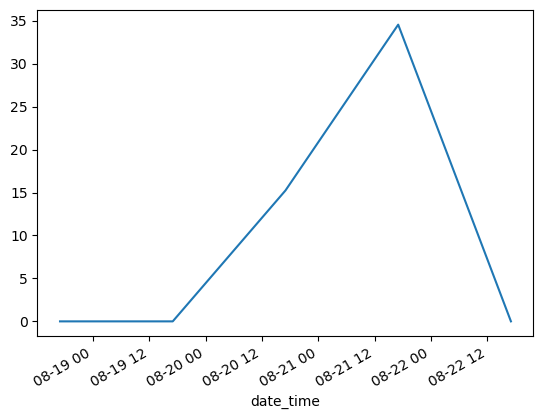

 57%|█████▋    | 1219/2131 [1:43:13<45:31,  2.99s/it]  

QC fail with flag: 1 - not hourly


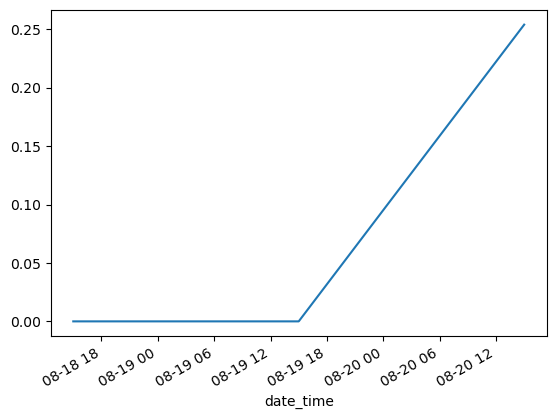

 57%|█████▋    | 1222/2131 [1:43:13<16:57,  1.12s/it]

QC passed, flag = 0
QC passed, flag = 0


 57%|█████▋    | 1223/2131 [1:43:27<1:13:34,  4.86s/it]

QC passed, flag = 0


 57%|█████▋    | 1224/2131 [1:43:28<57:23,  3.80s/it]  

QC passed, flag = 0


 57%|█████▋    | 1225/2131 [1:43:29<43:31,  2.88s/it]

QC passed, flag = 0


 58%|█████▊    | 1226/2131 [1:43:31<41:35,  2.76s/it]

QC passed, flag = 0


 58%|█████▊    | 1227/2131 [1:43:32<34:21,  2.28s/it]

QC passed, flag = 0


 58%|█████▊    | 1228/2131 [1:43:33<24:58,  1.66s/it]

QC passed, flag = 0


 58%|█████▊    | 1230/2131 [1:43:33<14:34,  1.03it/s]

QC passed, flag = 0
QC passed, flag = 0


 58%|█████▊    | 1231/2131 [1:43:34<11:18,  1.33it/s]

QC passed, flag = 0


 58%|█████▊    | 1232/2131 [1:43:34<08:57,  1.67it/s]

QC passed, flag = 0


 58%|█████▊    | 1233/2131 [1:43:34<07:21,  2.04it/s]

QC passed, flag = 0


 58%|█████▊    | 1234/2131 [1:43:35<10:28,  1.43it/s]

QC passed, flag = 0


 58%|█████▊    | 1235/2131 [1:43:36<12:35,  1.19it/s]

QC passed, flag = 0


 58%|█████▊    | 1236/2131 [1:43:50<1:09:30,  4.66s/it]

QC passed, flag = 0


 58%|█████▊    | 1237/2131 [1:43:51<54:42,  3.67s/it]  

QC passed, flag = 0


 58%|█████▊    | 1238/2131 [1:43:55<52:18,  3.51s/it]

QC passed, flag = 0


 58%|█████▊    | 1239/2131 [1:43:56<41:32,  2.79s/it]

QC passed, flag = 0


 58%|█████▊    | 1240/2131 [1:43:57<34:09,  2.30s/it]

QC passed, flag = 0


 58%|█████▊    | 1241/2131 [1:43:58<29:04,  1.96s/it]

QC passed, flag = 0


 58%|█████▊    | 1242/2131 [1:43:59<25:32,  1.72s/it]

QC passed, flag = 0


 58%|█████▊    | 1243/2131 [1:44:13<1:21:30,  5.51s/it]

QC passed, flag = 0


 58%|█████▊    | 1244/2131 [1:44:24<1:45:14,  7.12s/it]

QC passed, flag = 0


 58%|█████▊    | 1245/2131 [1:44:38<2:14:35,  9.11s/it]

QC passed, flag = 0


 58%|█████▊    | 1246/2131 [1:44:40<1:40:17,  6.80s/it]

QC passed, flag = 0


 59%|█████▊    | 1247/2131 [1:44:41<1:15:13,  5.11s/it]

QC passed, flag = 0


 59%|█████▊    | 1248/2131 [1:44:55<1:56:17,  7.90s/it]

QC passed, flag = 0


 59%|█████▊    | 1249/2131 [1:45:02<1:51:03,  7.55s/it]

QC passed, flag = 0


 59%|█████▊    | 1250/2131 [1:45:08<1:43:48,  7.07s/it]

QC passed, flag = 0


 59%|█████▊    | 1251/2131 [1:45:14<1:39:33,  6.79s/it]

QC passed, flag = 0


 59%|█████▉    | 1252/2131 [1:45:28<2:10:02,  8.88s/it]

QC passed, flag = 0


 59%|█████▉    | 1253/2131 [1:45:31<1:47:28,  7.34s/it]

QC passed, flag = 0


 59%|█████▉    | 1254/2131 [1:45:43<2:06:39,  8.66s/it]

QC passed, flag = 0


 59%|█████▉    | 1255/2131 [1:45:46<1:41:27,  6.95s/it]

QC passed, flag = 0


 59%|█████▉    | 1256/2131 [1:45:52<1:36:02,  6.59s/it]

QC passed, flag = 0


 59%|█████▉    | 1257/2131 [1:46:05<2:05:43,  8.63s/it]

QC passed, flag = 0


 59%|█████▉    | 1258/2131 [1:46:14<2:07:26,  8.76s/it]

QC passed, flag = 0


 59%|█████▉    | 1259/2131 [1:46:16<1:34:51,  6.53s/it]

QC passed, flag = 0


 59%|█████▉    | 1260/2131 [1:46:20<1:26:47,  5.98s/it]

QC passed, flag = 0


 59%|█████▉    | 1261/2131 [1:46:21<1:03:46,  4.40s/it]

QC passed, flag = 0


 59%|█████▉    | 1262/2131 [1:46:21<45:46,  3.16s/it]  

QC passed, flag = 0
QC fail with flag: 1 - not hourly


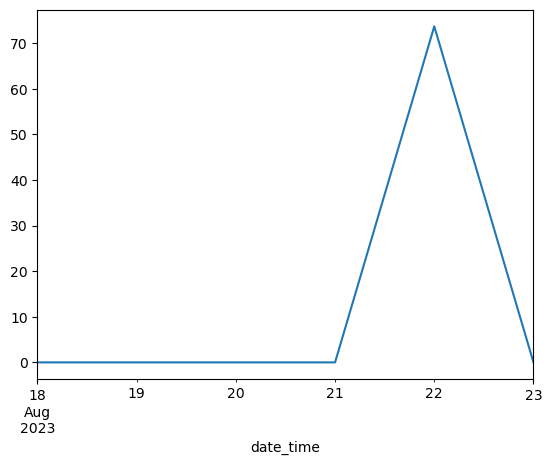

 59%|█████▉    | 1263/2131 [1:46:21<32:37,  2.26s/it]

QC fail with flag: 1 - not hourly


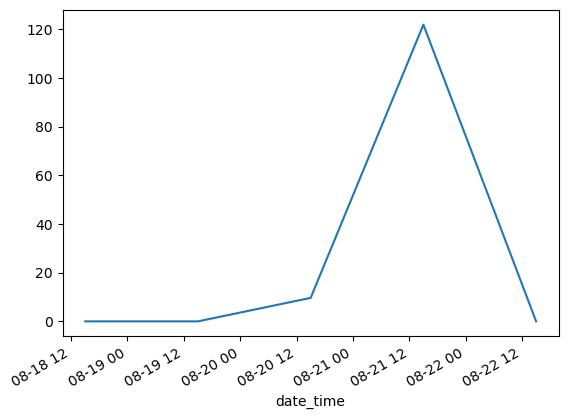

 59%|█████▉    | 1265/2131 [1:46:35<1:15:50,  5.25s/it]

QC passed, flag = 0


 59%|█████▉    | 1266/2131 [1:46:42<1:21:18,  5.64s/it]

QC passed, flag = 0


 59%|█████▉    | 1267/2131 [1:46:47<1:18:34,  5.46s/it]

QC passed, flag = 0


 60%|█████▉    | 1268/2131 [1:46:47<56:23,  3.92s/it]  

QC passed, flag = 0


 60%|█████▉    | 1269/2131 [1:46:52<58:35,  4.08s/it]

QC passed, flag = 0


 60%|█████▉    | 1271/2131 [1:46:52<30:02,  2.10s/it]

QC passed, flag = 0
QC passed, flag = 0


 60%|█████▉    | 1273/2131 [1:46:53<17:04,  1.19s/it]

QC passed, flag = 0
QC passed, flag = 0


 60%|█████▉    | 1274/2131 [1:46:57<31:22,  2.20s/it]

QC passed, flag = 0


 60%|█████▉    | 1275/2131 [1:47:02<41:58,  2.94s/it]

QC passed, flag = 0


 60%|█████▉    | 1276/2131 [1:47:17<1:32:57,  6.52s/it]

QC passed, flag = 0


 60%|█████▉    | 1277/2131 [1:47:30<2:00:48,  8.49s/it]

QC passed, flag = 0


 60%|█████▉    | 1278/2131 [1:47:46<2:32:14, 10.71s/it]

QC passed, flag = 0


 60%|██████    | 1279/2131 [1:48:01<2:49:16, 11.92s/it]

QC passed, flag = 0


 60%|██████    | 1280/2131 [1:48:03<2:10:31,  9.20s/it]

QC passed, flag = 0


 60%|██████    | 1281/2131 [1:48:05<1:38:22,  6.94s/it]

QC passed, flag = 0


 60%|██████    | 1282/2131 [1:48:06<1:13:34,  5.20s/it]

QC passed, flag = 0


 60%|██████    | 1283/2131 [1:48:07<56:12,  3.98s/it]  

QC passed, flag = 0


 60%|██████    | 1284/2131 [1:48:09<44:09,  3.13s/it]

QC passed, flag = 0


 60%|██████    | 1285/2131 [1:48:10<35:34,  2.52s/it]

QC passed, flag = 0


 60%|██████    | 1286/2131 [1:48:11<29:37,  2.10s/it]

QC passed, flag = 0


 60%|██████    | 1287/2131 [1:48:12<25:22,  1.80s/it]

QC passed, flag = 0


 60%|██████    | 1288/2131 [1:48:13<22:20,  1.59s/it]

QC passed, flag = 0


 60%|██████    | 1289/2131 [1:48:15<25:56,  1.85s/it]

QC passed, flag = 0


 61%|██████    | 1290/2131 [1:48:22<45:21,  3.24s/it]

QC passed, flag = 0


 61%|██████    | 1291/2131 [1:48:28<58:03,  4.15s/it]

QC passed, flag = 0


 61%|██████    | 1292/2131 [1:48:34<1:06:40,  4.77s/it]

QC passed, flag = 0


 61%|██████    | 1293/2131 [1:48:35<48:10,  3.45s/it]  

QC passed, flag = 0


 61%|██████    | 1294/2131 [1:48:41<58:32,  4.20s/it]

QC passed, flag = 0


 61%|██████    | 1295/2131 [1:48:47<1:06:37,  4.78s/it]

QC passed, flag = 0


 61%|██████    | 1296/2131 [1:48:50<59:32,  4.28s/it]  

QC passed, flag = 0


 61%|██████    | 1297/2131 [1:48:56<1:07:42,  4.87s/it]

QC passed, flag = 0
QC fail with flag: 3 - intensity greater than 1000 year retun interval


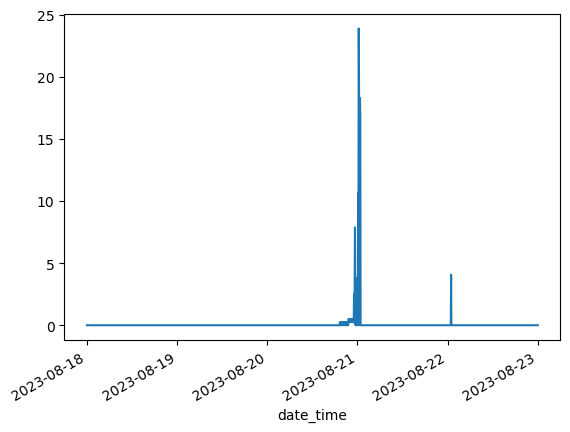

 61%|██████    | 1299/2131 [1:49:05<1:01:19,  4.42s/it]

QC passed, flag = 0


 61%|██████    | 1300/2131 [1:49:07<47:41,  3.44s/it]  

QC passed, flag = 0


 61%|██████    | 1301/2131 [1:49:22<1:37:48,  7.07s/it]

QC passed, flag = 0


 61%|██████    | 1302/2131 [1:49:24<1:15:30,  5.46s/it]

QC passed, flag = 0


 61%|██████    | 1303/2131 [1:49:29<1:12:06,  5.22s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


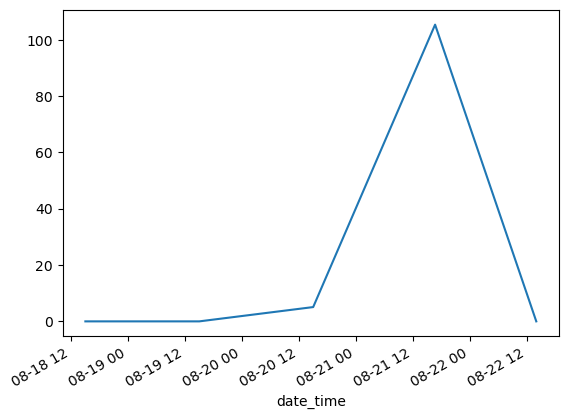

 61%|██████    | 1305/2131 [1:49:29<38:06,  2.77s/it]  

QC passed, flag = 0


 61%|██████▏   | 1306/2131 [1:49:30<27:41,  2.01s/it]

QC passed, flag = 0


 61%|██████▏   | 1307/2131 [1:49:30<20:58,  1.53s/it]

QC passed, flag = 0


 61%|██████▏   | 1308/2131 [1:49:30<15:47,  1.15s/it]

QC passed, flag = 0


 61%|██████▏   | 1309/2131 [1:49:33<22:51,  1.67s/it]

QC passed, flag = 0


 62%|██████▏   | 1311/2131 [1:49:38<24:40,  1.81s/it]

QC passed, flag = 0
QC passed, flag = 0


 62%|██████▏   | 1313/2131 [1:49:38<13:17,  1.03it/s]

QC passed, flag = 0
QC passed, flag = 0


 62%|██████▏   | 1315/2131 [1:49:39<09:09,  1.49it/s]

QC passed, flag = 0
QC passed, flag = 0


 62%|██████▏   | 1316/2131 [1:49:39<07:03,  1.92it/s]

QC passed, flag = 0


 62%|██████▏   | 1317/2131 [1:49:54<1:03:53,  4.71s/it]

QC passed, flag = 0


 62%|██████▏   | 1318/2131 [1:50:08<1:41:03,  7.46s/it]

QC passed, flag = 0


 62%|██████▏   | 1319/2131 [1:50:14<1:38:03,  7.25s/it]

QC passed, flag = 0


 62%|██████▏   | 1320/2131 [1:50:28<2:04:05,  9.18s/it]

QC passed, flag = 0


 62%|██████▏   | 1322/2131 [1:50:32<1:12:41,  5.39s/it]

QC passed, flag = 0
QC passed, flag = 0


 62%|██████▏   | 1323/2131 [1:50:36<1:08:16,  5.07s/it]

QC passed, flag = 0


 62%|██████▏   | 1324/2131 [1:50:41<1:05:35,  4.88s/it]

QC passed, flag = 0


 62%|██████▏   | 1325/2131 [1:50:43<54:19,  4.04s/it]  

QC passed, flag = 0


 62%|██████▏   | 1326/2131 [1:50:44<42:34,  3.17s/it]

QC passed, flag = 0


 62%|██████▏   | 1327/2131 [1:50:45<34:18,  2.56s/it]

QC passed, flag = 0


 62%|██████▏   | 1328/2131 [1:50:47<29:24,  2.20s/it]

QC passed, flag = 0


 62%|██████▏   | 1329/2131 [1:50:48<25:28,  1.91s/it]

QC passed, flag = 0


 62%|██████▏   | 1330/2131 [1:50:49<22:42,  1.70s/it]

QC passed, flag = 0


 62%|██████▏   | 1331/2131 [1:50:50<21:08,  1.59s/it]

QC passed, flag = 0


 63%|██████▎   | 1332/2131 [1:50:52<19:29,  1.46s/it]

QC passed, flag = 0


 63%|██████▎   | 1333/2131 [1:50:53<18:21,  1.38s/it]

QC passed, flag = 0


 63%|██████▎   | 1334/2131 [1:51:01<43:52,  3.30s/it]

QC passed, flag = 0


 63%|██████▎   | 1335/2131 [1:51:16<1:33:16,  7.03s/it]

QC passed, flag = 0


 63%|██████▎   | 1336/2131 [1:51:23<1:33:53,  7.09s/it]

QC passed, flag = 0


 63%|██████▎   | 1337/2131 [1:51:25<1:10:34,  5.33s/it]

QC passed, flag = 0


 63%|██████▎   | 1338/2131 [1:51:30<1:09:42,  5.27s/it]

QC passed, flag = 0


 63%|██████▎   | 1339/2131 [1:51:43<1:39:38,  7.55s/it]

QC passed, flag = 0


 63%|██████▎   | 1340/2131 [1:51:47<1:26:14,  6.54s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


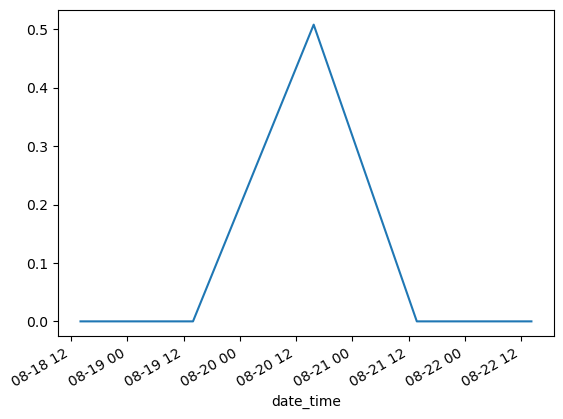

 63%|██████▎   | 1342/2131 [1:51:47<43:58,  3.34s/it]  

QC passed, flag = 0
QC fail with flag: 1 - not hourly


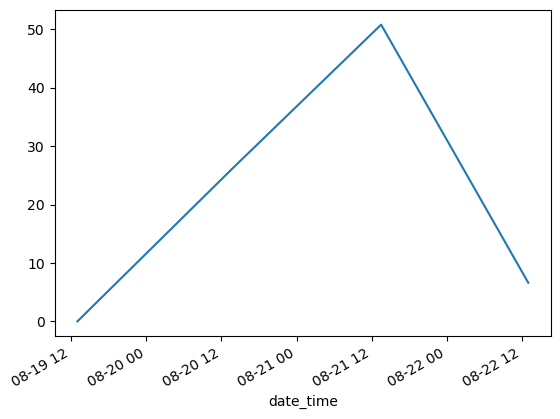

 63%|██████▎   | 1344/2131 [1:51:49<27:13,  2.08s/it]

QC passed, flag = 0


 63%|██████▎   | 1345/2131 [1:51:50<23:43,  1.81s/it]

QC passed, flag = 0


 63%|██████▎   | 1346/2131 [1:52:05<1:14:39,  5.71s/it]

QC passed, flag = 0


 63%|██████▎   | 1348/2131 [1:52:06<38:41,  2.97s/it]  

QC passed, flag = 0
QC passed, flag = 0


 63%|██████▎   | 1349/2131 [1:52:07<30:29,  2.34s/it]

QC passed, flag = 0


 63%|██████▎   | 1350/2131 [1:52:12<41:14,  3.17s/it]

QC passed, flag = 0


 63%|██████▎   | 1351/2131 [1:52:15<41:34,  3.20s/it]

QC passed, flag = 0


 63%|██████▎   | 1352/2131 [1:52:20<47:59,  3.70s/it]

QC passed, flag = 0


 63%|██████▎   | 1353/2131 [1:52:33<1:26:42,  6.69s/it]

QC passed, flag = 0


 64%|██████▎   | 1354/2131 [1:52:47<1:54:25,  8.84s/it]

QC passed, flag = 0


 64%|██████▎   | 1355/2131 [1:53:02<2:16:36, 10.56s/it]

QC passed, flag = 0


 64%|██████▎   | 1356/2131 [1:53:06<1:50:04,  8.52s/it]

QC passed, flag = 0


 64%|██████▎   | 1357/2131 [1:53:07<1:23:42,  6.49s/it]

QC passed, flag = 0


 64%|██████▎   | 1358/2131 [1:53:09<1:03:27,  4.93s/it]

QC passed, flag = 0


 64%|██████▍   | 1359/2131 [1:53:10<49:04,  3.81s/it]  

QC passed, flag = 0


 64%|██████▍   | 1360/2131 [1:53:11<39:03,  3.04s/it]

QC passed, flag = 0


 64%|██████▍   | 1361/2131 [1:53:12<32:08,  2.50s/it]

QC passed, flag = 0


 64%|██████▍   | 1362/2131 [1:53:14<27:34,  2.15s/it]

QC passed, flag = 0


 64%|██████▍   | 1363/2131 [1:53:15<24:06,  1.88s/it]

QC passed, flag = 0


 64%|██████▍   | 1364/2131 [1:53:16<21:38,  1.69s/it]

QC passed, flag = 0


 64%|██████▍   | 1365/2131 [1:53:18<20:27,  1.60s/it]

QC passed, flag = 0


 64%|██████▍   | 1366/2131 [1:53:18<16:46,  1.32s/it]

QC passed, flag = 0


 64%|██████▍   | 1367/2131 [1:53:20<16:46,  1.32s/it]

QC passed, flag = 0


 64%|██████▍   | 1368/2131 [1:53:26<37:56,  2.98s/it]

QC passed, flag = 0


 64%|██████▍   | 1369/2131 [1:53:33<50:21,  3.97s/it]

QC passed, flag = 0


 64%|██████▍   | 1370/2131 [1:53:37<52:00,  4.10s/it]

QC passed, flag = 0


 64%|██████▍   | 1371/2131 [1:53:41<52:44,  4.16s/it]

QC passed, flag = 0


 64%|██████▍   | 1372/2131 [1:53:49<1:04:15,  5.08s/it]

QC passed, flag = 0


 64%|██████▍   | 1373/2131 [1:53:50<50:06,  3.97s/it]  

QC passed, flag = 0


 64%|██████▍   | 1374/2131 [1:53:51<36:45,  2.91s/it]

QC passed, flag = 0


 65%|██████▍   | 1375/2131 [1:53:51<26:37,  2.11s/it]

QC passed, flag = 0


 65%|██████▍   | 1376/2131 [1:53:55<36:29,  2.90s/it]

QC passed, flag = 0


 65%|██████▍   | 1377/2131 [1:53:57<30:24,  2.42s/it]

QC passed, flag = 0


 65%|██████▍   | 1378/2131 [1:54:01<38:32,  3.07s/it]

QC passed, flag = 0


 65%|██████▍   | 1379/2131 [1:54:16<1:21:24,  6.49s/it]

QC passed, flag = 0


 65%|██████▍   | 1381/2131 [1:54:16<41:27,  3.32s/it]  

QC passed, flag = 0
QC passed, flag = 0
QC fail with flag: 1 - not hourly


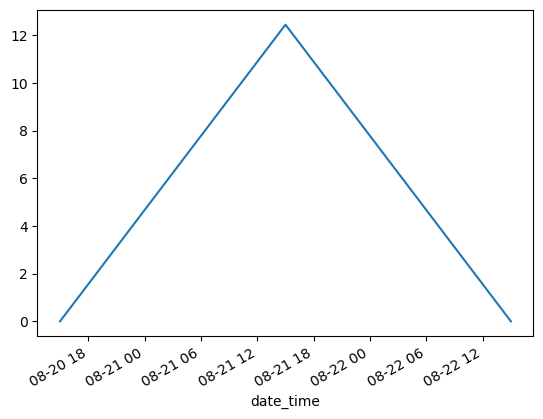

 65%|██████▍   | 1383/2131 [1:54:17<21:30,  1.72s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


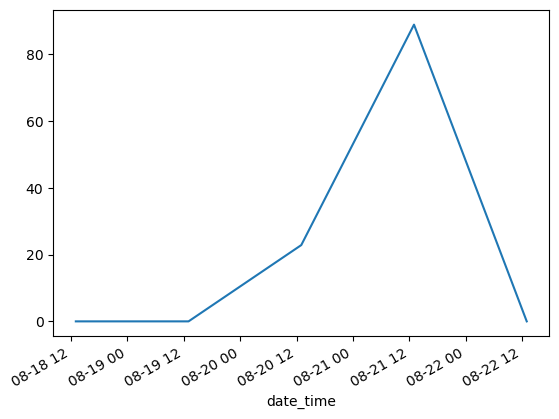

 65%|██████▍   | 1385/2131 [1:54:21<27:37,  2.22s/it]

QC passed, flag = 0


 65%|██████▌   | 1386/2131 [1:54:22<21:01,  1.69s/it]

QC passed, flag = 0


 65%|██████▌   | 1387/2131 [1:54:23<19:32,  1.58s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


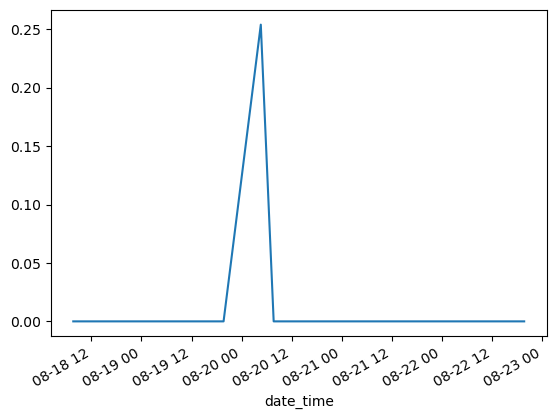

 65%|██████▌   | 1389/2131 [1:54:24<11:56,  1.04it/s]

QC passed, flag = 0


 65%|██████▌   | 1390/2131 [1:54:25<12:04,  1.02it/s]

QC passed, flag = 0


 65%|██████▌   | 1391/2131 [1:54:29<24:25,  1.98s/it]

QC passed, flag = 0


 65%|██████▌   | 1392/2131 [1:54:31<21:36,  1.75s/it]

QC passed, flag = 0


 65%|██████▌   | 1393/2131 [1:54:32<19:37,  1.60s/it]

QC passed, flag = 0


 65%|██████▌   | 1394/2131 [1:54:33<18:41,  1.52s/it]

QC passed, flag = 0


 65%|██████▌   | 1395/2131 [1:54:34<17:31,  1.43s/it]

QC passed, flag = 0


 66%|██████▌   | 1396/2131 [1:54:36<16:37,  1.36s/it]

QC passed, flag = 0


 66%|██████▌   | 1397/2131 [1:54:37<16:05,  1.31s/it]

QC passed, flag = 0


 66%|██████▌   | 1398/2131 [1:54:38<16:00,  1.31s/it]

QC passed, flag = 0


 66%|██████▌   | 1399/2131 [1:54:39<16:19,  1.34s/it]

QC passed, flag = 0


 66%|██████▌   | 1400/2131 [1:54:42<19:35,  1.61s/it]

QC passed, flag = 0


 66%|██████▌   | 1401/2131 [1:54:47<32:32,  2.67s/it]

QC passed, flag = 0


 66%|██████▌   | 1402/2131 [1:54:53<46:48,  3.85s/it]

QC passed, flag = 0


 66%|██████▌   | 1403/2131 [1:54:56<40:56,  3.37s/it]

QC passed, flag = 0


 66%|██████▌   | 1404/2131 [1:55:03<54:02,  4.46s/it]

QC passed, flag = 0


 66%|██████▌   | 1405/2131 [1:55:03<39:17,  3.25s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


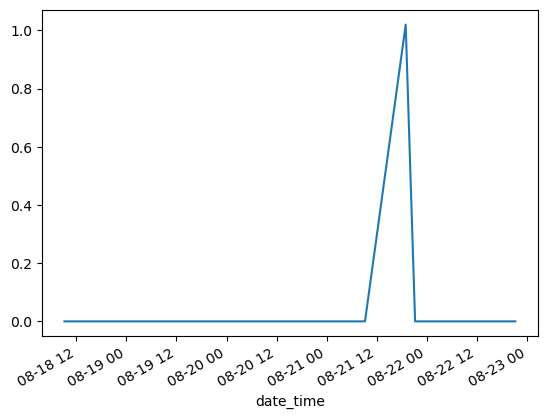

 66%|██████▌   | 1407/2131 [1:55:04<22:56,  1.90s/it]

QC passed, flag = 0


 66%|██████▌   | 1408/2131 [1:55:09<33:04,  2.74s/it]

QC passed, flag = 0


 66%|██████▌   | 1409/2131 [1:55:14<39:21,  3.27s/it]

QC passed, flag = 0


 66%|██████▌   | 1410/2131 [1:55:18<44:45,  3.73s/it]

QC passed, flag = 0


 66%|██████▌   | 1411/2131 [1:55:23<47:52,  3.99s/it]

QC passed, flag = 0


 66%|██████▋   | 1412/2131 [1:55:25<41:07,  3.43s/it]

QC passed, flag = 0


 66%|██████▋   | 1413/2131 [1:55:26<33:43,  2.82s/it]

QC passed, flag = 0


 66%|██████▋   | 1414/2131 [1:55:28<28:02,  2.35s/it]

QC passed, flag = 0


 66%|██████▋   | 1415/2131 [1:55:29<24:15,  2.03s/it]

QC passed, flag = 0


 66%|██████▋   | 1416/2131 [1:55:30<21:28,  1.80s/it]

QC passed, flag = 0


 66%|██████▋   | 1417/2131 [1:55:31<19:18,  1.62s/it]

QC passed, flag = 0


 67%|██████▋   | 1418/2131 [1:55:33<18:05,  1.52s/it]

QC passed, flag = 0


 67%|██████▋   | 1419/2131 [1:55:40<38:01,  3.20s/it]

QC passed, flag = 0


 67%|██████▋   | 1420/2131 [1:55:47<51:21,  4.33s/it]

QC passed, flag = 0


 67%|██████▋   | 1421/2131 [1:55:48<40:57,  3.46s/it]

QC passed, flag = 0


 67%|██████▋   | 1422/2131 [1:55:55<52:07,  4.41s/it]

QC passed, flag = 0


 67%|██████▋   | 1423/2131 [1:55:58<45:51,  3.89s/it]

QC passed, flag = 0


 67%|██████▋   | 1424/2131 [1:56:04<56:08,  4.76s/it]

QC passed, flag = 0


 67%|██████▋   | 1425/2131 [1:56:07<47:13,  4.01s/it]

QC passed, flag = 0


 67%|██████▋   | 1426/2131 [1:56:07<34:26,  2.93s/it]

QC passed, flag = 0


 67%|██████▋   | 1427/2131 [1:56:08<27:52,  2.38s/it]

QC passed, flag = 0


 67%|██████▋   | 1428/2131 [1:56:08<20:14,  1.73s/it]

QC passed, flag = 0


 67%|██████▋   | 1429/2131 [1:56:09<15:19,  1.31s/it]

QC passed, flag = 0


 67%|██████▋   | 1430/2131 [1:56:10<15:40,  1.34s/it]

QC passed, flag = 0


 67%|██████▋   | 1431/2131 [1:56:15<27:09,  2.33s/it]

QC passed, flag = 0


 67%|██████▋   | 1432/2131 [1:56:19<34:24,  2.95s/it]

QC passed, flag = 0


 67%|██████▋   | 1433/2131 [1:56:20<28:14,  2.43s/it]

QC passed, flag = 0


 67%|██████▋   | 1434/2131 [1:56:25<34:42,  2.99s/it]

QC passed, flag = 0


 67%|██████▋   | 1435/2131 [1:56:34<57:10,  4.93s/it]

QC passed, flag = 0


 67%|██████▋   | 1436/2131 [1:56:40<1:01:37,  5.32s/it]

QC passed, flag = 0


 67%|██████▋   | 1437/2131 [1:56:41<43:57,  3.80s/it]  

QC passed, flag = 0
QC fail with flag: 1 - not hourly


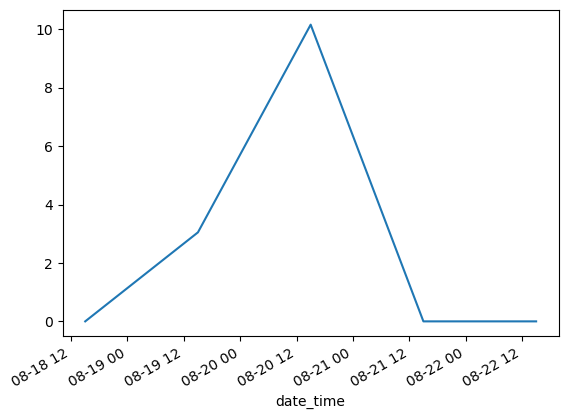

 67%|██████▋   | 1438/2131 [1:56:41<31:17,  2.71s/it]

QC fail with flag: 1 - not hourly


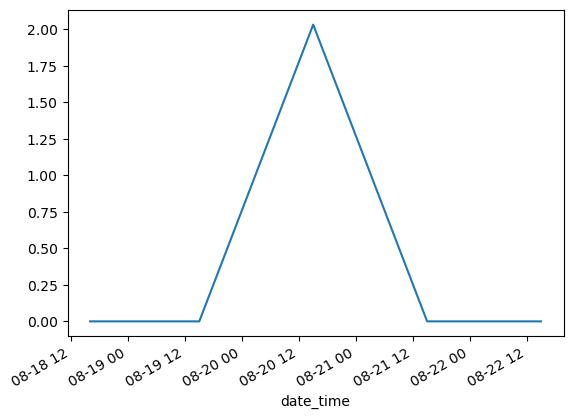

 68%|██████▊   | 1440/2131 [1:56:42<20:19,  1.76s/it]

QC passed, flag = 0


 68%|██████▊   | 1441/2131 [1:56:47<29:28,  2.56s/it]

QC passed, flag = 0


 68%|██████▊   | 1442/2131 [1:57:18<2:07:16, 11.08s/it]

QC passed, flag = 0


 68%|██████▊   | 1443/2131 [1:57:19<1:34:55,  8.28s/it]

QC passed, flag = 0


 68%|██████▊   | 1444/2131 [1:57:21<1:12:37,  6.34s/it]

QC passed, flag = 0


 68%|██████▊   | 1445/2131 [1:57:22<55:10,  4.83s/it]  

QC passed, flag = 0


 68%|██████▊   | 1446/2131 [1:57:24<42:16,  3.70s/it]

QC passed, flag = 0


 68%|██████▊   | 1447/2131 [1:57:25<33:15,  2.92s/it]

QC passed, flag = 0


 68%|██████▊   | 1448/2131 [1:57:26<26:56,  2.37s/it]

QC passed, flag = 0


 68%|██████▊   | 1449/2131 [1:57:27<22:30,  1.98s/it]

QC passed, flag = 0


 68%|██████▊   | 1450/2131 [1:57:31<29:06,  2.56s/it]

QC passed, flag = 0


 68%|██████▊   | 1451/2131 [1:57:32<24:02,  2.12s/it]

QC passed, flag = 0


 68%|██████▊   | 1452/2131 [1:57:33<20:29,  1.81s/it]

QC passed, flag = 0


 68%|██████▊   | 1453/2131 [1:57:34<18:01,  1.60s/it]

QC passed, flag = 0


 68%|██████▊   | 1454/2131 [1:57:35<16:18,  1.45s/it]

QC passed, flag = 0


 68%|██████▊   | 1455/2131 [1:57:36<15:05,  1.34s/it]

QC passed, flag = 0


 68%|██████▊   | 1456/2131 [1:57:37<14:14,  1.27s/it]

QC passed, flag = 0


 68%|██████▊   | 1457/2131 [1:57:40<17:42,  1.58s/it]

QC passed, flag = 0


 68%|██████▊   | 1458/2131 [1:57:53<57:42,  5.15s/it]

QC passed, flag = 0


 68%|██████▊   | 1459/2131 [1:57:54<44:00,  3.93s/it]

QC passed, flag = 0


 69%|██████▊   | 1460/2131 [1:57:54<31:31,  2.82s/it]

QC passed, flag = 0
QC passed, flag = 0


 69%|██████▊   | 1462/2131 [1:57:55<16:24,  1.47s/it]

QC passed, flag = 0


 69%|██████▊   | 1463/2131 [1:57:55<12:13,  1.10s/it]

QC passed, flag = 0


 69%|██████▊   | 1464/2131 [1:58:00<23:59,  2.16s/it]

QC passed, flag = 0


 69%|██████▊   | 1465/2131 [1:58:06<39:15,  3.54s/it]

QC passed, flag = 0


 69%|██████▉   | 1466/2131 [1:58:11<43:36,  3.93s/it]

QC passed, flag = 0


 69%|██████▉   | 1467/2131 [1:58:15<44:17,  4.00s/it]

QC passed, flag = 0


 69%|██████▉   | 1468/2131 [1:58:17<35:07,  3.18s/it]

QC passed, flag = 0


 69%|██████▉   | 1469/2131 [1:58:18<28:26,  2.58s/it]

QC passed, flag = 0


 69%|██████▉   | 1470/2131 [1:58:18<20:41,  1.88s/it]

QC passed, flag = 0


 69%|██████▉   | 1471/2131 [1:58:18<15:53,  1.44s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


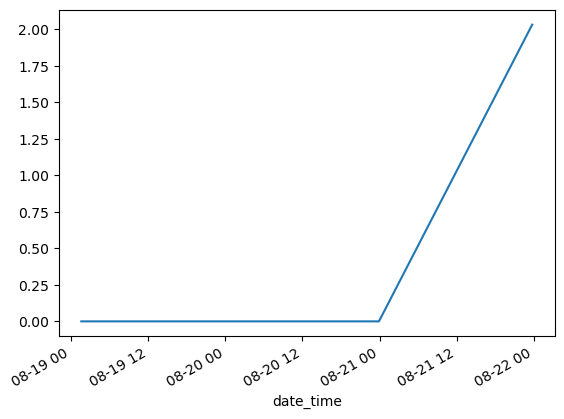

 69%|██████▉   | 1472/2131 [1:58:19<12:33,  1.14s/it]

QC fail with flag: 1 - not hourly


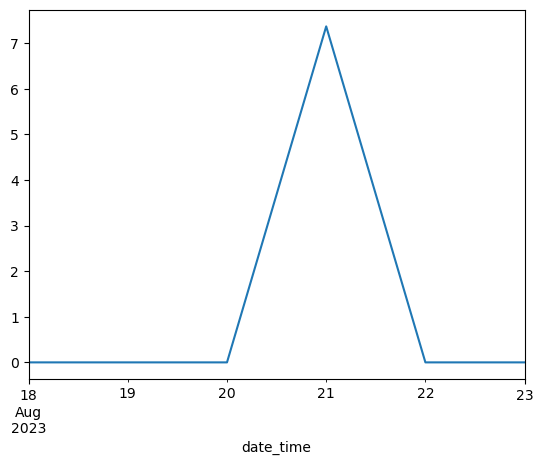

 69%|██████▉   | 1473/2131 [1:58:19<09:20,  1.17it/s]

QC fail with flag: 1 - not hourly


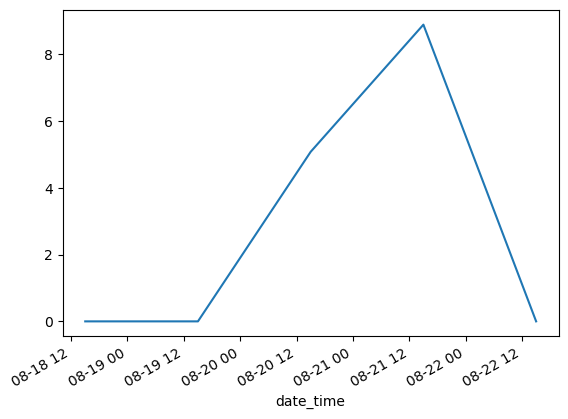

 69%|██████▉   | 1475/2131 [1:58:19<05:32,  1.97it/s]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


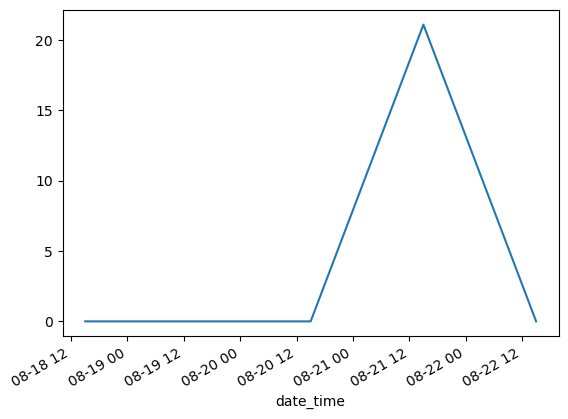

 69%|██████▉   | 1476/2131 [1:58:20<04:24,  2.48it/s]

QC fail with flag: 1 - not hourly


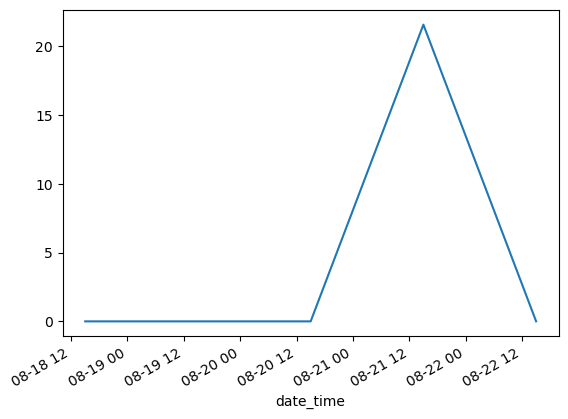

 69%|██████▉   | 1477/2131 [1:58:20<03:37,  3.00it/s]

QC fail with flag: 1 - not hourly


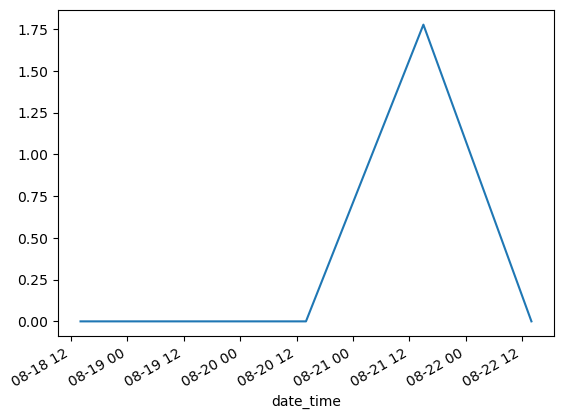

 69%|██████▉   | 1479/2131 [1:58:21<06:33,  1.66it/s]

QC passed, flag = 0


 69%|██████▉   | 1480/2131 [1:58:22<05:25,  2.00it/s]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


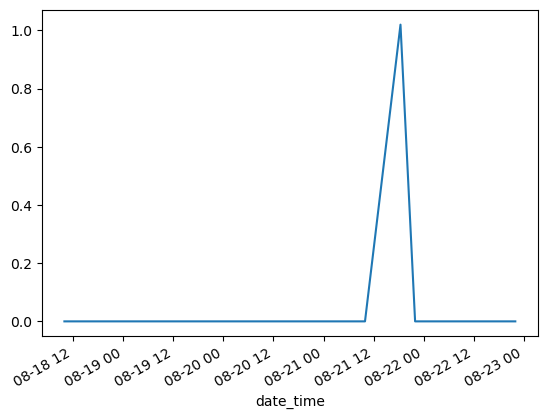

 70%|██████▉   | 1482/2131 [1:58:36<49:45,  4.60s/it]

QC passed, flag = 0


 70%|██████▉   | 1483/2131 [1:58:48<1:11:23,  6.61s/it]

QC passed, flag = 0


 70%|██████▉   | 1484/2131 [1:59:00<1:30:55,  8.43s/it]

QC passed, flag = 0


 70%|██████▉   | 1485/2131 [1:59:06<1:21:34,  7.58s/it]

QC passed, flag = 0


 70%|██████▉   | 1486/2131 [1:59:07<1:00:55,  5.67s/it]

QC passed, flag = 0


 70%|██████▉   | 1487/2131 [1:59:08<44:33,  4.15s/it]  

QC passed, flag = 0


 70%|██████▉   | 1488/2131 [1:59:09<35:00,  3.27s/it]

QC passed, flag = 0


 70%|██████▉   | 1489/2131 [1:59:13<38:13,  3.57s/it]

QC passed, flag = 0


 70%|██████▉   | 1490/2131 [1:59:14<30:27,  2.85s/it]

QC passed, flag = 0


 70%|██████▉   | 1491/2131 [1:59:19<35:58,  3.37s/it]

QC passed, flag = 0


 70%|███████   | 1492/2131 [1:59:23<38:19,  3.60s/it]

QC passed, flag = 0


 70%|███████   | 1493/2131 [1:59:25<34:21,  3.23s/it]

QC passed, flag = 0


 70%|███████   | 1494/2131 [1:59:26<27:30,  2.59s/it]

QC passed, flag = 0


 70%|███████   | 1495/2131 [1:59:28<22:43,  2.14s/it]

QC passed, flag = 0


 70%|███████   | 1496/2131 [1:59:29<19:22,  1.83s/it]

QC passed, flag = 0


 70%|███████   | 1497/2131 [1:59:30<17:15,  1.63s/it]

QC passed, flag = 0


 70%|███████   | 1498/2131 [1:59:31<15:44,  1.49s/it]

QC passed, flag = 0


 70%|███████   | 1499/2131 [1:59:35<25:04,  2.38s/it]

QC passed, flag = 0


 70%|███████   | 1500/2131 [1:59:40<32:07,  3.05s/it]

QC passed, flag = 0


 70%|███████   | 1501/2131 [1:59:42<27:52,  2.66s/it]

QC passed, flag = 0


 70%|███████   | 1502/2131 [1:59:43<23:15,  2.22s/it]

QC passed, flag = 0


 71%|███████   | 1503/2131 [1:59:44<20:03,  1.92s/it]

QC passed, flag = 0


 71%|███████   | 1504/2131 [1:59:45<17:46,  1.70s/it]

QC passed, flag = 0


 71%|███████   | 1505/2131 [1:59:47<16:08,  1.55s/it]

QC passed, flag = 0


 71%|███████   | 1506/2131 [1:59:49<18:44,  1.80s/it]

QC passed, flag = 0


 71%|███████   | 1507/2131 [1:59:59<44:53,  4.32s/it]

QC passed, flag = 0


 71%|███████   | 1508/2131 [2:00:03<44:48,  4.32s/it]

QC passed, flag = 0


 71%|███████   | 1510/2131 [2:00:04<23:11,  2.24s/it]

QC passed, flag = 0
QC passed, flag = 0


 71%|███████   | 1511/2131 [2:00:05<19:49,  1.92s/it]

QC passed, flag = 0


 71%|███████   | 1512/2131 [2:00:06<17:19,  1.68s/it]

QC passed, flag = 0


 71%|███████   | 1513/2131 [2:00:08<15:56,  1.55s/it]

QC passed, flag = 0


 71%|███████   | 1514/2131 [2:00:09<14:41,  1.43s/it]

QC passed, flag = 0


 71%|███████   | 1515/2131 [2:00:10<14:15,  1.39s/it]

QC passed, flag = 0


 71%|███████   | 1516/2131 [2:00:15<24:33,  2.40s/it]

QC passed, flag = 0


 71%|███████   | 1517/2131 [2:00:19<30:27,  2.98s/it]

QC passed, flag = 0


 71%|███████   | 1518/2131 [2:00:33<1:05:30,  6.41s/it]

QC passed, flag = 0


 71%|███████▏  | 1519/2131 [2:00:38<1:00:07,  5.89s/it]

QC passed, flag = 0


 71%|███████▏  | 1520/2131 [2:00:46<1:04:35,  6.34s/it]

QC passed, flag = 0


 71%|███████▏  | 1521/2131 [2:00:47<49:20,  4.85s/it]  

QC passed, flag = 0


 71%|███████▏  | 1522/2131 [2:00:51<47:46,  4.71s/it]

QC passed, flag = 0


 71%|███████▏  | 1523/2131 [2:00:52<34:10,  3.37s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


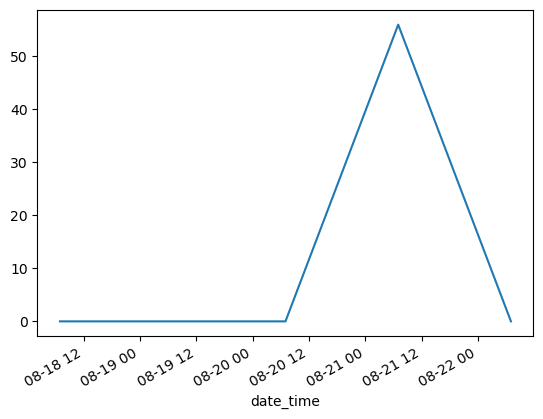

 72%|███████▏  | 1525/2131 [2:00:52<17:24,  1.72s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


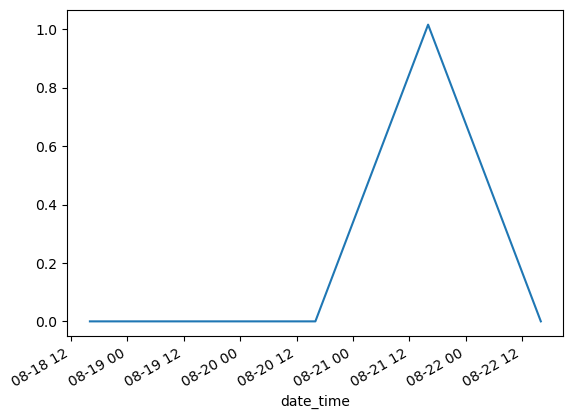

 72%|███████▏  | 1527/2131 [2:00:56<21:46,  2.16s/it]

QC passed, flag = 0


 72%|███████▏  | 1528/2131 [2:01:01<28:14,  2.81s/it]

QC passed, flag = 0


 72%|███████▏  | 1529/2131 [2:01:15<1:02:16,  6.21s/it]

QC passed, flag = 0


 72%|███████▏  | 1530/2131 [2:01:19<57:01,  5.69s/it]  

QC passed, flag = 0


 72%|███████▏  | 1531/2131 [2:01:23<52:35,  5.26s/it]

QC passed, flag = 0


 72%|███████▏  | 1532/2131 [2:01:38<1:19:53,  8.00s/it]

QC passed, flag = 0


 72%|███████▏  | 1533/2131 [2:01:43<1:10:14,  7.05s/it]

QC passed, flag = 0


 72%|███████▏  | 1534/2131 [2:01:43<50:36,  5.09s/it]  

QC passed, flag = 0


 72%|███████▏  | 1535/2131 [2:01:56<1:14:47,  7.53s/it]

QC passed, flag = 0


 72%|███████▏  | 1536/2131 [2:02:04<1:13:23,  7.40s/it]

QC passed, flag = 0


 72%|███████▏  | 1537/2131 [2:02:10<1:10:33,  7.13s/it]

QC passed, flag = 0


 72%|███████▏  | 1538/2131 [2:02:11<53:24,  5.40s/it]  

QC passed, flag = 0


 72%|███████▏  | 1539/2131 [2:02:13<43:15,  4.38s/it]

QC passed, flag = 0


 72%|███████▏  | 1540/2131 [2:02:15<34:44,  3.53s/it]

QC passed, flag = 0


 72%|███████▏  | 1541/2131 [2:02:16<27:31,  2.80s/it]

QC passed, flag = 0


 72%|███████▏  | 1542/2131 [2:02:17<22:45,  2.32s/it]

QC passed, flag = 0


 72%|███████▏  | 1543/2131 [2:02:18<19:07,  1.95s/it]

QC passed, flag = 0


 72%|███████▏  | 1544/2131 [2:02:19<16:34,  1.69s/it]

QC passed, flag = 0


 73%|███████▎  | 1545/2131 [2:02:24<24:39,  2.53s/it]

QC passed, flag = 0


 73%|███████▎  | 1546/2131 [2:02:25<20:27,  2.10s/it]

QC passed, flag = 0


 73%|███████▎  | 1547/2131 [2:02:26<17:30,  1.80s/it]

QC passed, flag = 0


 73%|███████▎  | 1548/2131 [2:02:27<15:25,  1.59s/it]

QC passed, flag = 0


 73%|███████▎  | 1549/2131 [2:02:28<12:59,  1.34s/it]

QC passed, flag = 0


 73%|███████▎  | 1550/2131 [2:02:29<12:10,  1.26s/it]

QC passed, flag = 0


 73%|███████▎  | 1552/2131 [2:02:30<07:02,  1.37it/s]

QC passed, flag = 0
QC passed, flag = 0


 73%|███████▎  | 1553/2131 [2:02:31<08:06,  1.19it/s]

QC passed, flag = 0


 73%|███████▎  | 1554/2131 [2:02:33<11:14,  1.17s/it]

QC passed, flag = 0


 73%|███████▎  | 1555/2131 [2:02:37<21:48,  2.27s/it]

QC passed, flag = 0


 73%|███████▎  | 1556/2131 [2:02:42<28:43,  3.00s/it]

QC passed, flag = 0


 73%|███████▎  | 1557/2131 [2:02:43<23:30,  2.46s/it]

QC passed, flag = 0


 73%|███████▎  | 1558/2131 [2:02:57<54:38,  5.72s/it]

QC passed, flag = 0


 73%|███████▎  | 1559/2131 [2:03:13<1:25:43,  8.99s/it]

QC passed, flag = 0


 73%|███████▎  | 1560/2131 [2:03:18<1:12:12,  7.59s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


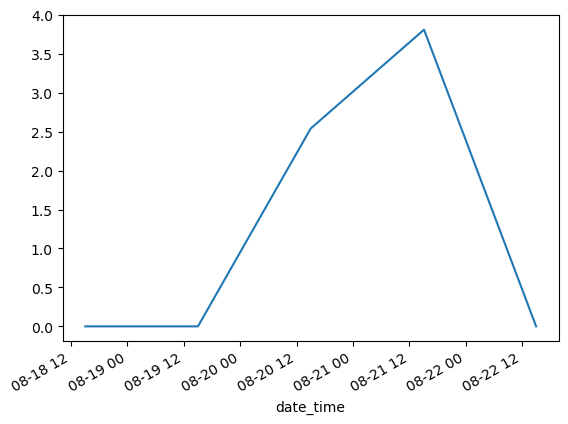

 73%|███████▎  | 1561/2131 [2:03:18<51:22,  5.41s/it]  

QC fail with flag: 1 - not hourly


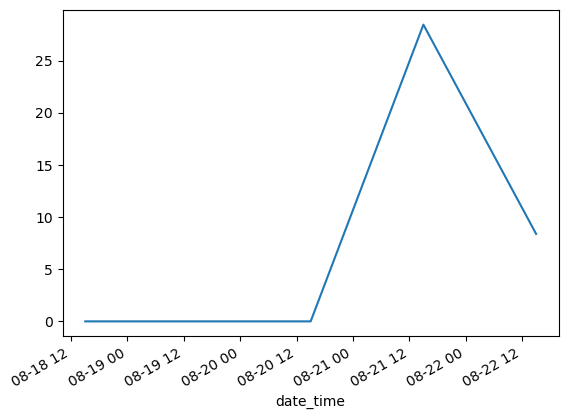

 73%|███████▎  | 1563/2131 [2:03:18<25:53,  2.73s/it]

QC passed, flag = 0


 73%|███████▎  | 1564/2131 [2:03:19<19:02,  2.02s/it]

QC passed, flag = 0


 73%|███████▎  | 1565/2131 [2:03:22<22:29,  2.38s/it]

QC passed, flag = 0


 73%|███████▎  | 1566/2131 [2:03:26<27:53,  2.96s/it]

QC passed, flag = 0


 74%|███████▎  | 1567/2131 [2:03:30<31:50,  3.39s/it]

QC passed, flag = 0


 74%|███████▎  | 1568/2131 [2:03:45<1:01:58,  6.60s/it]

QC passed, flag = 0


 74%|███████▎  | 1569/2131 [2:03:47<49:05,  5.24s/it]  

QC passed, flag = 0


 74%|███████▎  | 1570/2131 [2:03:48<37:43,  4.03s/it]

QC passed, flag = 0


 74%|███████▎  | 1571/2131 [2:03:49<29:48,  3.19s/it]

QC passed, flag = 0


 74%|███████▍  | 1572/2131 [2:03:50<24:12,  2.60s/it]

QC passed, flag = 0


 74%|███████▍  | 1573/2131 [2:03:55<29:03,  3.13s/it]

QC passed, flag = 0


 74%|███████▍  | 1574/2131 [2:03:59<31:46,  3.42s/it]

QC passed, flag = 0


 74%|███████▍  | 1575/2131 [2:04:00<25:35,  2.76s/it]

QC passed, flag = 0


 74%|███████▍  | 1576/2131 [2:04:01<20:54,  2.26s/it]

QC passed, flag = 0


 74%|███████▍  | 1577/2131 [2:04:02<17:37,  1.91s/it]

QC passed, flag = 0


 74%|███████▍  | 1578/2131 [2:04:11<35:58,  3.90s/it]

QC passed, flag = 0


 74%|███████▍  | 1579/2131 [2:04:12<28:51,  3.14s/it]

QC passed, flag = 0


 74%|███████▍  | 1580/2131 [2:04:13<23:12,  2.53s/it]

QC passed, flag = 0


 74%|███████▍  | 1581/2131 [2:04:15<19:55,  2.17s/it]

QC passed, flag = 0


 74%|███████▍  | 1582/2131 [2:04:16<17:11,  1.88s/it]

QC passed, flag = 0


 74%|███████▍  | 1583/2131 [2:04:17<15:12,  1.67s/it]

QC passed, flag = 0


 74%|███████▍  | 1584/2131 [2:04:18<13:46,  1.51s/it]

QC passed, flag = 0


 74%|███████▍  | 1585/2131 [2:04:19<12:56,  1.42s/it]

QC passed, flag = 0


 74%|███████▍  | 1586/2131 [2:04:22<17:41,  1.95s/it]

QC passed, flag = 0


 74%|███████▍  | 1587/2131 [2:04:26<22:29,  2.48s/it]

QC passed, flag = 0


 75%|███████▍  | 1588/2131 [2:04:32<32:53,  3.63s/it]

QC passed, flag = 0


 75%|███████▍  | 1589/2131 [2:04:46<1:00:38,  6.71s/it]

QC passed, flag = 0


 75%|███████▍  | 1590/2131 [2:04:54<1:01:55,  6.87s/it]

QC passed, flag = 0


 75%|███████▍  | 1591/2131 [2:04:55<46:52,  5.21s/it]  

QC passed, flag = 0


 75%|███████▍  | 1592/2131 [2:04:59<44:40,  4.97s/it]

QC passed, flag = 0


 75%|███████▍  | 1593/2131 [2:05:03<42:02,  4.69s/it]

QC passed, flag = 0


 75%|███████▍  | 1594/2131 [2:05:07<38:14,  4.27s/it]

QC passed, flag = 0


 75%|███████▍  | 1595/2131 [2:05:19<58:38,  6.57s/it]

QC passed, flag = 0


 75%|███████▍  | 1596/2131 [2:05:20<44:53,  5.03s/it]

QC passed, flag = 0


 75%|███████▍  | 1597/2131 [2:05:34<1:09:33,  7.82s/it]

QC passed, flag = 0


 75%|███████▍  | 1598/2131 [2:05:39<1:00:42,  6.83s/it]

QC passed, flag = 0


 75%|███████▌  | 1599/2131 [2:05:42<50:39,  5.71s/it]  

QC passed, flag = 0


 75%|███████▌  | 1600/2131 [2:05:47<47:23,  5.35s/it]

QC passed, flag = 0


 75%|███████▌  | 1601/2131 [2:05:51<44:42,  5.06s/it]

QC passed, flag = 0


 75%|███████▌  | 1602/2131 [2:05:55<42:21,  4.80s/it]

QC passed, flag = 0


 75%|███████▌  | 1603/2131 [2:06:00<41:12,  4.68s/it]

QC passed, flag = 0


 75%|███████▌  | 1604/2131 [2:06:01<32:30,  3.70s/it]

QC passed, flag = 0


 75%|███████▌  | 1605/2131 [2:06:05<34:05,  3.89s/it]

QC passed, flag = 0


 75%|███████▌  | 1606/2131 [2:06:12<41:39,  4.76s/it]

QC passed, flag = 0


 75%|███████▌  | 1607/2131 [2:06:29<1:12:56,  8.35s/it]

QC passed, flag = 0


 75%|███████▌  | 1608/2131 [2:06:29<51:50,  5.95s/it]  

QC passed, flag = 0
QC fail with flag: 1 - not hourly


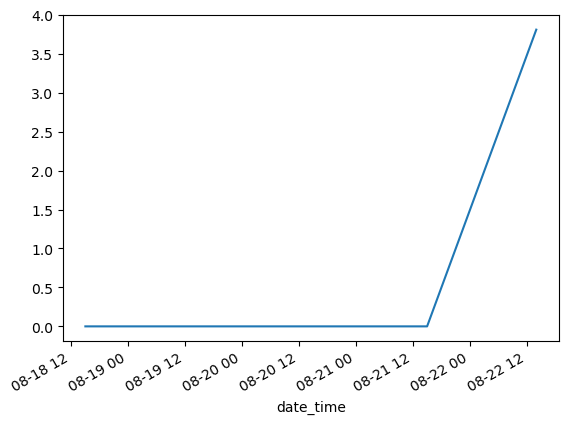

 76%|███████▌  | 1610/2131 [2:06:30<26:09,  3.01s/it]

QC passed, flag = 0


 76%|███████▌  | 1611/2131 [2:06:30<18:49,  2.17s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


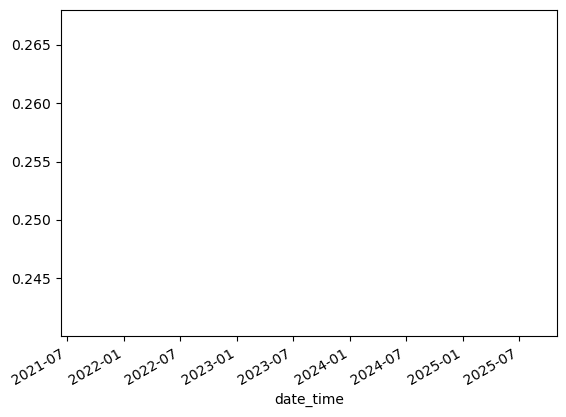

 76%|███████▌  | 1613/2131 [2:06:47<52:33,  6.09s/it]

QC passed, flag = 0


 76%|███████▌  | 1614/2131 [2:06:47<37:48,  4.39s/it]

QC passed, flag = 0


 76%|███████▌  | 1615/2131 [2:06:47<27:08,  3.16s/it]

QC passed, flag = 0


 76%|███████▌  | 1616/2131 [2:06:52<30:45,  3.58s/it]

QC passed, flag = 0


 76%|███████▌  | 1617/2131 [2:06:56<32:29,  3.79s/it]

QC passed, flag = 0


 76%|███████▌  | 1618/2131 [2:06:57<24:12,  2.83s/it]

QC passed, flag = 0


 76%|███████▌  | 1619/2131 [2:07:01<28:08,  3.30s/it]

QC passed, flag = 0


 76%|███████▌  | 1620/2131 [2:07:06<31:50,  3.74s/it]

QC passed, flag = 0


 76%|███████▌  | 1621/2131 [2:07:10<33:42,  3.97s/it]

QC passed, flag = 0


 76%|███████▌  | 1622/2131 [2:07:15<35:49,  4.22s/it]

QC passed, flag = 0


 76%|███████▌  | 1623/2131 [2:07:22<43:17,  5.11s/it]

QC passed, flag = 0


 76%|███████▌  | 1624/2131 [2:07:35<1:02:03,  7.34s/it]

QC passed, flag = 0


 76%|███████▋  | 1625/2131 [2:07:49<1:19:42,  9.45s/it]

QC passed, flag = 0


 76%|███████▋  | 1626/2131 [2:07:51<59:23,  7.06s/it]  

QC passed, flag = 0


 76%|███████▋  | 1627/2131 [2:07:52<44:41,  5.32s/it]

QC passed, flag = 0


 76%|███████▋  | 1628/2131 [2:07:53<34:26,  4.11s/it]

QC passed, flag = 0


 76%|███████▋  | 1629/2131 [2:07:58<36:32,  4.37s/it]

QC passed, flag = 0


 76%|███████▋  | 1630/2131 [2:08:03<36:56,  4.42s/it]

QC passed, flag = 0


 77%|███████▋  | 1631/2131 [2:08:04<29:33,  3.55s/it]

QC passed, flag = 0


 77%|███████▋  | 1632/2131 [2:08:09<31:40,  3.81s/it]

QC passed, flag = 0


 77%|███████▋  | 1633/2131 [2:08:13<33:23,  4.02s/it]

QC passed, flag = 0


 77%|███████▋  | 1634/2131 [2:08:14<26:20,  3.18s/it]

QC passed, flag = 0


 77%|███████▋  | 1635/2131 [2:08:16<21:26,  2.59s/it]

QC passed, flag = 0


 77%|███████▋  | 1636/2131 [2:08:17<18:06,  2.20s/it]

QC passed, flag = 0


 77%|███████▋  | 1637/2131 [2:08:18<15:44,  1.91s/it]

QC passed, flag = 0


 77%|███████▋  | 1638/2131 [2:08:28<34:34,  4.21s/it]

QC passed, flag = 0


 77%|███████▋  | 1639/2131 [2:08:31<32:48,  4.00s/it]

QC passed, flag = 0


 77%|███████▋  | 1640/2131 [2:08:39<42:53,  5.24s/it]

QC passed, flag = 0


 77%|███████▋  | 1641/2131 [2:08:44<40:55,  5.01s/it]

QC passed, flag = 0


 77%|███████▋  | 1642/2131 [2:08:45<32:10,  3.95s/it]

QC passed, flag = 0


 77%|███████▋  | 1643/2131 [2:08:50<33:07,  4.07s/it]

QC passed, flag = 0


 77%|███████▋  | 1644/2131 [2:08:54<33:57,  4.18s/it]

QC passed, flag = 0


 77%|███████▋  | 1645/2131 [2:09:11<1:03:27,  7.83s/it]

QC passed, flag = 0


 77%|███████▋  | 1646/2131 [2:09:28<1:26:27, 10.70s/it]

QC passed, flag = 0


 77%|███████▋  | 1647/2131 [2:09:33<1:13:18,  9.09s/it]

QC passed, flag = 0


 77%|███████▋  | 1648/2131 [2:09:34<52:17,  6.50s/it]  

QC passed, flag = 0


 77%|███████▋  | 1649/2131 [2:09:35<39:25,  4.91s/it]

QC passed, flag = 0


 77%|███████▋  | 1650/2131 [2:09:40<39:13,  4.89s/it]

QC passed, flag = 0


 77%|███████▋  | 1651/2131 [2:09:43<34:21,  4.29s/it]

QC passed, flag = 0


 78%|███████▊  | 1652/2131 [2:09:44<27:20,  3.43s/it]

QC passed, flag = 0


 78%|███████▊  | 1653/2131 [2:09:51<36:51,  4.63s/it]

QC passed, flag = 0


 78%|███████▊  | 1654/2131 [2:09:56<36:38,  4.61s/it]

QC passed, flag = 0


 78%|███████▊  | 1655/2131 [2:10:01<36:51,  4.65s/it]

QC passed, flag = 0


 78%|███████▊  | 1656/2131 [2:10:22<1:15:56,  9.59s/it]

QC passed, flag = 0


 78%|███████▊  | 1657/2131 [2:10:37<1:28:36, 11.22s/it]

QC passed, flag = 0


 78%|███████▊  | 1658/2131 [2:10:52<1:37:05, 12.32s/it]

QC passed, flag = 0


 78%|███████▊  | 1659/2131 [2:10:53<1:10:49,  9.00s/it]

QC passed, flag = 0


 78%|███████▊  | 1660/2131 [2:10:56<55:31,  7.07s/it]  

QC passed, flag = 0


 78%|███████▊  | 1661/2131 [2:10:57<41:24,  5.29s/it]

QC passed, flag = 0


 78%|███████▊  | 1662/2131 [2:11:02<40:47,  5.22s/it]

QC passed, flag = 0


 78%|███████▊  | 1663/2131 [2:11:07<40:23,  5.18s/it]

QC passed, flag = 0


 78%|███████▊  | 1664/2131 [2:11:11<38:40,  4.97s/it]

QC passed, flag = 0


 78%|███████▊  | 1665/2131 [2:11:17<39:16,  5.06s/it]

QC passed, flag = 0


 78%|███████▊  | 1666/2131 [2:11:33<1:06:18,  8.56s/it]

QC passed, flag = 0


 78%|███████▊  | 1668/2131 [2:11:34<33:30,  4.34s/it]  

QC passed, flag = 0
QC passed, flag = 0
QC fail with flag: 1 - not hourly


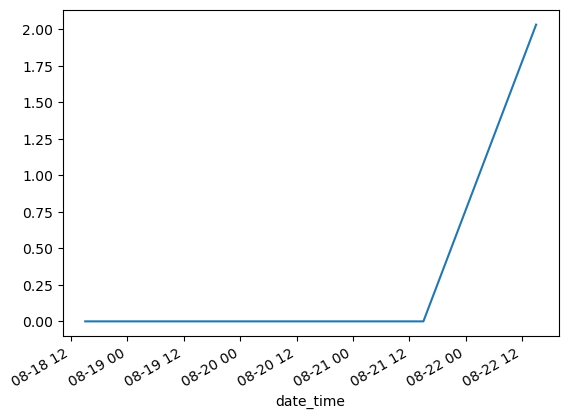

 78%|███████▊  | 1671/2131 [2:11:35<12:33,  1.64s/it]

QC passed, flag = 0
QC passed, flag = 0


 78%|███████▊  | 1672/2131 [2:11:35<09:20,  1.22s/it]

QC passed, flag = 0


 79%|███████▊  | 1673/2131 [2:11:35<07:01,  1.09it/s]

QC passed, flag = 0


 79%|███████▊  | 1674/2131 [2:11:35<05:34,  1.36it/s]

QC passed, flag = 0


 79%|███████▊  | 1676/2131 [2:11:36<03:18,  2.29it/s]

QC passed, flag = 0
QC passed, flag = 0


 79%|███████▊  | 1677/2131 [2:11:36<02:38,  2.86it/s]

QC passed, flag = 0


 79%|███████▊  | 1678/2131 [2:11:36<02:20,  3.23it/s]

QC passed, flag = 0


 79%|███████▉  | 1679/2131 [2:11:36<02:09,  3.48it/s]

QC passed, flag = 0


 79%|███████▉  | 1680/2131 [2:11:38<04:30,  1.67it/s]

QC passed, flag = 0


 79%|███████▉  | 1681/2131 [2:11:53<37:17,  4.97s/it]

QC passed, flag = 0


 79%|███████▉  | 1682/2131 [2:11:55<31:29,  4.21s/it]

QC passed, flag = 0


 79%|███████▉  | 1683/2131 [2:12:09<52:58,  7.09s/it]

QC passed, flag = 0


 79%|███████▉  | 1684/2131 [2:12:24<1:10:12,  9.42s/it]

QC passed, flag = 0


 79%|███████▉  | 1685/2131 [2:12:29<1:00:07,  8.09s/it]

QC passed, flag = 0


 79%|███████▉  | 1686/2131 [2:12:43<1:13:26,  9.90s/it]

QC passed, flag = 0


 79%|███████▉  | 1687/2131 [2:12:49<1:04:05,  8.66s/it]

QC passed, flag = 0


 79%|███████▉  | 1688/2131 [2:12:53<54:08,  7.33s/it]  

QC passed, flag = 0


 79%|███████▉  | 1689/2131 [2:12:58<48:22,  6.57s/it]

QC passed, flag = 0


 79%|███████▉  | 1690/2131 [2:13:12<1:04:01,  8.71s/it]

QC passed, flag = 0


 79%|███████▉  | 1691/2131 [2:13:13<47:37,  6.50s/it]  

QC passed, flag = 0


 79%|███████▉  | 1692/2131 [2:13:17<43:01,  5.88s/it]

QC passed, flag = 0


 79%|███████▉  | 1693/2131 [2:13:18<32:25,  4.44s/it]

QC passed, flag = 0


 79%|███████▉  | 1694/2131 [2:13:33<53:38,  7.37s/it]

QC passed, flag = 0


 80%|███████▉  | 1695/2131 [2:13:38<48:12,  6.63s/it]

QC passed, flag = 0


 80%|███████▉  | 1696/2131 [2:13:41<40:52,  5.64s/it]

QC passed, flag = 0


 80%|███████▉  | 1697/2131 [2:13:56<1:00:55,  8.42s/it]

QC passed, flag = 0


 80%|███████▉  | 1698/2131 [2:13:57<45:25,  6.29s/it]  

QC passed, flag = 0


 80%|███████▉  | 1699/2131 [2:14:00<37:00,  5.14s/it]

QC passed, flag = 0


 80%|███████▉  | 1700/2131 [2:14:01<28:21,  3.95s/it]

QC passed, flag = 0


 80%|███████▉  | 1701/2131 [2:14:01<21:09,  2.95s/it]

QC passed, flag = 0


 80%|███████▉  | 1702/2131 [2:14:03<17:52,  2.50s/it]

QC passed, flag = 0


 80%|███████▉  | 1703/2131 [2:14:04<14:59,  2.10s/it]

QC passed, flag = 0


 80%|███████▉  | 1704/2131 [2:14:05<12:59,  1.83s/it]

QC passed, flag = 0


 80%|████████  | 1705/2131 [2:14:06<11:40,  1.64s/it]

QC passed, flag = 0


 80%|████████  | 1706/2131 [2:14:08<11:11,  1.58s/it]

QC passed, flag = 0


 80%|████████  | 1707/2131 [2:14:09<10:20,  1.46s/it]

QC passed, flag = 0


 80%|████████  | 1708/2131 [2:14:13<16:40,  2.37s/it]

QC passed, flag = 0


 80%|████████  | 1709/2131 [2:14:18<20:40,  2.94s/it]

QC passed, flag = 0


 80%|████████  | 1710/2131 [2:14:22<23:19,  3.32s/it]

QC passed, flag = 0


 80%|████████  | 1711/2131 [2:14:26<25:07,  3.59s/it]

QC passed, flag = 0


 80%|████████  | 1712/2131 [2:14:30<26:35,  3.81s/it]

QC passed, flag = 0


 80%|████████  | 1713/2131 [2:14:35<28:11,  4.05s/it]

QC passed, flag = 0


 80%|████████  | 1714/2131 [2:14:36<22:07,  3.18s/it]

QC passed, flag = 0


 80%|████████  | 1715/2131 [2:14:37<17:53,  2.58s/it]

QC passed, flag = 0


 81%|████████  | 1716/2131 [2:14:39<15:14,  2.20s/it]

QC passed, flag = 0


 81%|████████  | 1717/2131 [2:14:40<13:01,  1.89s/it]

QC passed, flag = 0


 81%|████████  | 1718/2131 [2:14:41<11:35,  1.68s/it]

QC passed, flag = 0


 81%|████████  | 1719/2131 [2:14:42<10:30,  1.53s/it]

QC passed, flag = 0


 81%|████████  | 1720/2131 [2:14:50<22:25,  3.27s/it]

QC passed, flag = 0


 81%|████████  | 1721/2131 [2:15:05<46:53,  6.86s/it]

QC passed, flag = 0


 81%|████████  | 1722/2131 [2:15:18<1:00:03,  8.81s/it]

QC passed, flag = 0


 81%|████████  | 1723/2131 [2:15:35<1:15:13, 11.06s/it]

QC passed, flag = 0


 81%|████████  | 1724/2131 [2:15:43<1:08:47, 10.14s/it]

QC passed, flag = 0


 81%|████████  | 1725/2131 [2:15:45<52:46,  7.80s/it]  

QC passed, flag = 0


 81%|████████  | 1726/2131 [2:15:49<46:00,  6.82s/it]

QC passed, flag = 0


 81%|████████  | 1727/2131 [2:15:56<45:53,  6.82s/it]

QC passed, flag = 0


 81%|████████  | 1728/2131 [2:15:58<35:13,  5.24s/it]

QC passed, flag = 0


 81%|████████  | 1729/2131 [2:16:04<37:28,  5.59s/it]

QC passed, flag = 0


 81%|████████  | 1730/2131 [2:16:06<29:04,  4.35s/it]

QC passed, flag = 0


 81%|████████  | 1731/2131 [2:16:12<33:07,  4.97s/it]

QC passed, flag = 0


 81%|████████▏ | 1732/2131 [2:16:17<33:41,  5.07s/it]

QC passed, flag = 0


 81%|████████▏ | 1733/2131 [2:16:22<32:08,  4.85s/it]

QC passed, flag = 0


 81%|████████▏ | 1734/2131 [2:16:49<1:17:07, 11.66s/it]

QC passed, flag = 0


 81%|████████▏ | 1735/2131 [2:17:02<1:19:58, 12.12s/it]

QC passed, flag = 0


 81%|████████▏ | 1736/2131 [2:17:08<1:06:21, 10.08s/it]

QC passed, flag = 0


 82%|████████▏ | 1737/2131 [2:17:15<59:53,  9.12s/it]  

QC passed, flag = 0


 82%|████████▏ | 1738/2131 [2:17:29<1:09:28, 10.61s/it]

QC passed, flag = 0


 82%|████████▏ | 1739/2131 [2:17:33<56:58,  8.72s/it]  

QC passed, flag = 0


 82%|████████▏ | 1740/2131 [2:17:37<47:58,  7.36s/it]

QC passed, flag = 0


 82%|████████▏ | 1741/2131 [2:17:51<1:00:12,  9.26s/it]

QC passed, flag = 0


 82%|████████▏ | 1742/2131 [2:17:55<50:05,  7.73s/it]  

QC passed, flag = 0


 82%|████████▏ | 1743/2131 [2:18:02<47:32,  7.35s/it]

QC passed, flag = 0


 82%|████████▏ | 1744/2131 [2:18:03<35:43,  5.54s/it]

QC passed, flag = 0


 82%|████████▏ | 1745/2131 [2:18:17<52:28,  8.16s/it]

QC passed, flag = 0


 82%|████████▏ | 1746/2131 [2:18:22<45:41,  7.12s/it]

QC passed, flag = 0


 82%|████████▏ | 1747/2131 [2:18:38<1:03:08,  9.87s/it]

QC passed, flag = 0


 82%|████████▏ | 1748/2131 [2:18:43<52:34,  8.24s/it]  

QC passed, flag = 0


 82%|████████▏ | 1749/2131 [2:18:47<44:26,  6.98s/it]

QC passed, flag = 0


 82%|████████▏ | 1750/2131 [2:18:51<38:56,  6.13s/it]

QC passed, flag = 0


 82%|████████▏ | 1751/2131 [2:18:55<35:10,  5.55s/it]

QC passed, flag = 0


 82%|████████▏ | 1752/2131 [2:18:59<32:31,  5.15s/it]

QC passed, flag = 0


 82%|████████▏ | 1753/2131 [2:19:03<30:25,  4.83s/it]

QC passed, flag = 0


 82%|████████▏ | 1754/2131 [2:19:04<23:32,  3.75s/it]

QC passed, flag = 0


 82%|████████▏ | 1755/2131 [2:19:12<30:13,  4.82s/it]

QC passed, flag = 0


 82%|████████▏ | 1756/2131 [2:19:19<34:54,  5.58s/it]

QC passed, flag = 0


 82%|████████▏ | 1757/2131 [2:19:22<29:01,  4.66s/it]

QC passed, flag = 0


 82%|████████▏ | 1758/2131 [2:19:28<32:23,  5.21s/it]

QC passed, flag = 0


 83%|████████▎ | 1759/2131 [2:19:34<34:06,  5.50s/it]

QC passed, flag = 0


 83%|████████▎ | 1760/2131 [2:19:47<47:25,  7.67s/it]

QC passed, flag = 0


 83%|████████▎ | 1761/2131 [2:19:52<42:20,  6.87s/it]

QC passed, flag = 0


 83%|████████▎ | 1762/2131 [2:19:59<41:39,  6.77s/it]

QC passed, flag = 0


 83%|████████▎ | 1763/2131 [2:20:14<57:01,  9.30s/it]

QC passed, flag = 0


 83%|████████▎ | 1764/2131 [2:20:18<48:18,  7.90s/it]

QC passed, flag = 0


 83%|████████▎ | 1765/2131 [2:20:22<41:09,  6.75s/it]

QC passed, flag = 0


 83%|████████▎ | 1766/2131 [2:20:37<55:41,  9.16s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


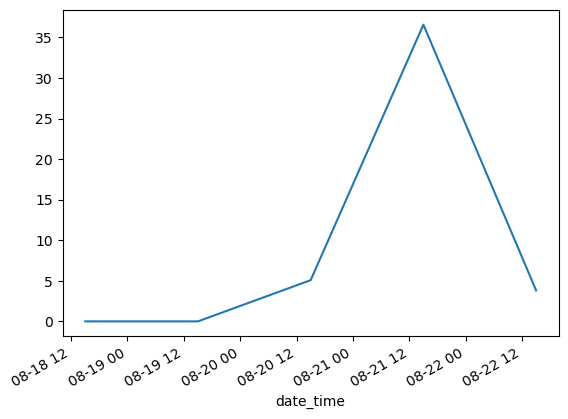

 83%|████████▎ | 1767/2131 [2:20:38<39:58,  6.59s/it]

QC fail with flag: 1 - not hourly


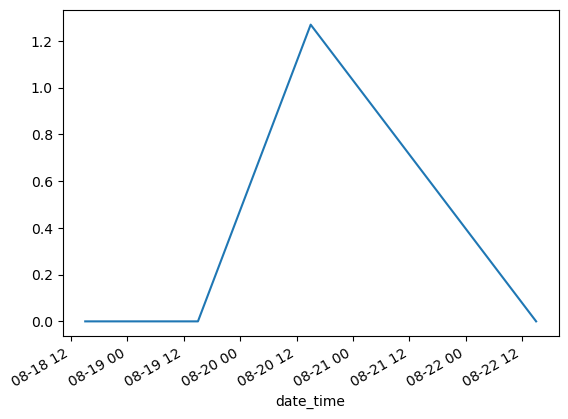

 83%|████████▎ | 1770/2131 [2:20:39<14:31,  2.41s/it]

QC passed, flag = 0
QC passed, flag = 0
QC fail with flag: 1 - not hourly


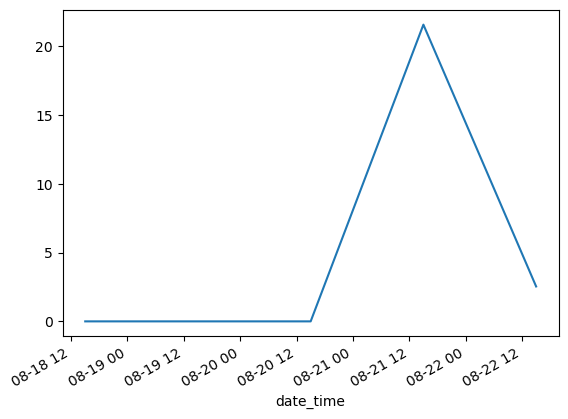

 83%|████████▎ | 1771/2131 [2:20:39<10:25,  1.74s/it]

QC fail with flag: 1 - not hourly


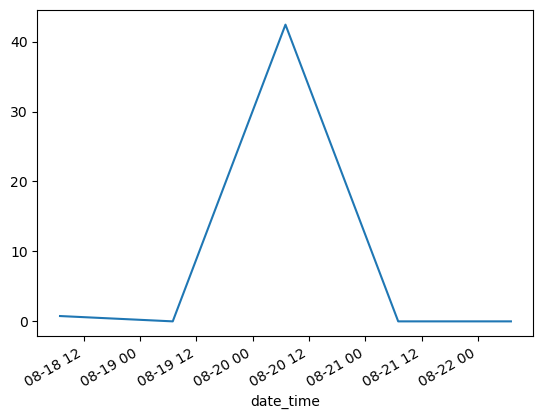

 83%|████████▎ | 1773/2131 [2:20:51<26:57,  4.52s/it]

QC passed, flag = 0


 83%|████████▎ | 1774/2131 [2:21:00<35:01,  5.89s/it]

QC passed, flag = 0


 83%|████████▎ | 1775/2131 [2:21:05<33:51,  5.71s/it]

QC passed, flag = 0


 83%|████████▎ | 1776/2131 [2:21:12<34:38,  5.85s/it]

QC passed, flag = 0


 83%|████████▎ | 1777/2131 [2:21:25<48:36,  8.24s/it]

QC passed, flag = 0


 83%|████████▎ | 1778/2131 [2:21:39<57:47,  9.82s/it]

QC passed, flag = 0
QC passed, flag = 0


 84%|████████▎ | 1780/2131 [2:21:40<31:54,  5.45s/it]

QC passed, flag = 0
QC passed, flag = 0
QC fail with flag: 1 - not hourly


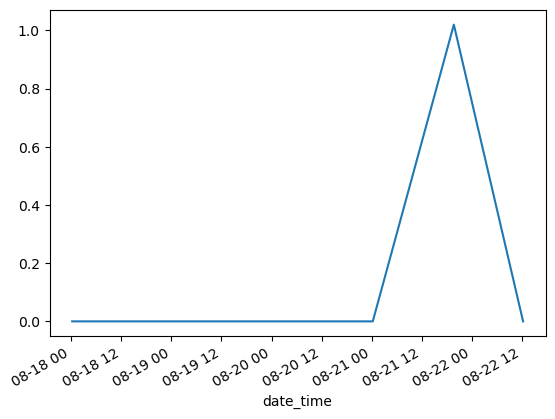

 84%|████████▎ | 1783/2131 [2:21:41<15:38,  2.70s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


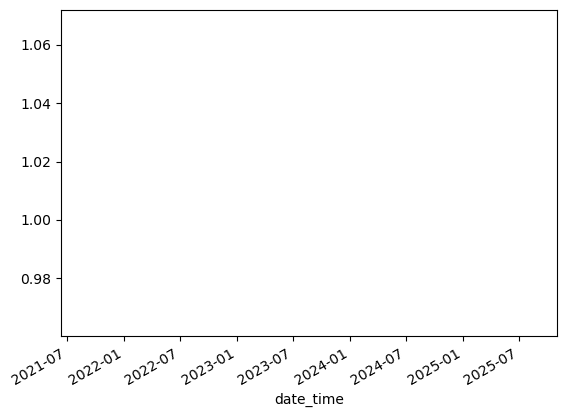

 84%|████████▍ | 1786/2131 [2:21:41<07:17,  1.27s/it]

QC passed, flag = 0
QC passed, flag = 0
QC passed, flag = 0


 84%|████████▍ | 1788/2131 [2:21:41<05:03,  1.13it/s]

QC passed, flag = 0
QC passed, flag = 0


 84%|████████▍ | 1790/2131 [2:21:43<04:48,  1.18it/s]

QC passed, flag = 0


 84%|████████▍ | 1791/2131 [2:21:44<05:09,  1.10it/s]

QC passed, flag = 0


 84%|████████▍ | 1792/2131 [2:21:46<05:55,  1.05s/it]

QC passed, flag = 0


 84%|████████▍ | 1793/2131 [2:21:59<22:59,  4.08s/it]

QC passed, flag = 0


 84%|████████▍ | 1794/2131 [2:22:04<24:06,  4.29s/it]

QC passed, flag = 0


 84%|████████▍ | 1795/2131 [2:22:08<23:43,  4.24s/it]

QC passed, flag = 0


 84%|████████▍ | 1796/2131 [2:22:13<23:46,  4.26s/it]

QC passed, flag = 0


 84%|████████▍ | 1797/2131 [2:22:17<23:38,  4.25s/it]

QC passed, flag = 0


 84%|████████▍ | 1798/2131 [2:22:21<22:44,  4.10s/it]

QC passed, flag = 0


 84%|████████▍ | 1799/2131 [2:22:25<22:53,  4.14s/it]

QC passed, flag = 0


 84%|████████▍ | 1800/2131 [2:22:42<43:28,  7.88s/it]

QC passed, flag = 0


 85%|████████▍ | 1801/2131 [2:22:46<38:04,  6.92s/it]

QC passed, flag = 0


 85%|████████▍ | 1802/2131 [2:22:51<33:47,  6.16s/it]

QC passed, flag = 0


 85%|████████▍ | 1803/2131 [2:23:05<47:19,  8.66s/it]

QC passed, flag = 0


 85%|████████▍ | 1804/2131 [2:23:19<54:49, 10.06s/it]

QC passed, flag = 0


 85%|████████▍ | 1805/2131 [2:23:24<46:25,  8.55s/it]

QC passed, flag = 0


 85%|████████▍ | 1806/2131 [2:23:37<54:38, 10.09s/it]

QC passed, flag = 0


 85%|████████▍ | 1807/2131 [2:23:42<45:16,  8.38s/it]

QC passed, flag = 0


 85%|████████▍ | 1808/2131 [2:23:47<39:44,  7.38s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


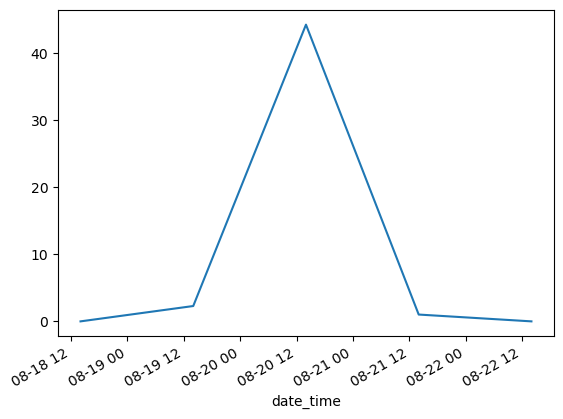

 85%|████████▍ | 1810/2131 [2:24:01<41:41,  7.79s/it]

QC passed, flag = 0


 85%|████████▍ | 1811/2131 [2:24:15<51:23,  9.64s/it]

QC passed, flag = 0


 85%|████████▌ | 1812/2131 [2:24:16<38:04,  7.16s/it]

QC passed, flag = 0


 85%|████████▌ | 1813/2131 [2:24:30<49:33,  9.35s/it]

QC passed, flag = 0


 85%|████████▌ | 1814/2131 [2:24:35<41:02,  7.77s/it]

QC passed, flag = 0


 85%|████████▌ | 1815/2131 [2:24:38<33:57,  6.45s/it]

QC passed, flag = 0


 85%|████████▌ | 1816/2131 [2:24:39<25:32,  4.87s/it]

QC passed, flag = 0


 85%|████████▌ | 1817/2131 [2:24:40<19:39,  3.76s/it]

QC passed, flag = 0


 85%|████████▌ | 1818/2131 [2:24:41<15:31,  2.97s/it]

QC passed, flag = 0


 85%|████████▌ | 1819/2131 [2:24:43<12:38,  2.43s/it]

QC passed, flag = 0


 85%|████████▌ | 1820/2131 [2:24:44<10:37,  2.05s/it]

QC passed, flag = 0


 85%|████████▌ | 1821/2131 [2:24:45<09:11,  1.78s/it]

QC passed, flag = 0


 85%|████████▌ | 1822/2131 [2:24:46<08:13,  1.60s/it]

QC passed, flag = 0


 86%|████████▌ | 1823/2131 [2:24:47<07:31,  1.46s/it]

QC passed, flag = 0


 86%|████████▌ | 1824/2131 [2:24:52<12:04,  2.36s/it]

QC passed, flag = 0


 86%|████████▌ | 1825/2131 [2:24:56<14:45,  2.89s/it]

QC passed, flag = 0


 86%|████████▌ | 1826/2131 [2:25:01<18:22,  3.62s/it]

QC passed, flag = 0


 86%|████████▌ | 1827/2131 [2:25:06<19:51,  3.92s/it]

QC passed, flag = 0


 86%|████████▌ | 1828/2131 [2:25:10<20:24,  4.04s/it]

QC passed, flag = 0


 86%|████████▌ | 1829/2131 [2:25:12<16:29,  3.28s/it]

QC passed, flag = 0


 86%|████████▌ | 1830/2131 [2:25:13<13:14,  2.64s/it]

QC passed, flag = 0


 86%|████████▌ | 1831/2131 [2:25:14<11:00,  2.20s/it]

QC passed, flag = 0


 86%|████████▌ | 1832/2131 [2:25:15<08:41,  1.75s/it]

QC passed, flag = 0


 86%|████████▌ | 1833/2131 [2:25:29<27:42,  5.58s/it]

QC passed, flag = 0


 86%|████████▌ | 1834/2131 [2:25:30<21:11,  4.28s/it]

QC passed, flag = 0
QC fail with flag: 4 - isolated high intensity


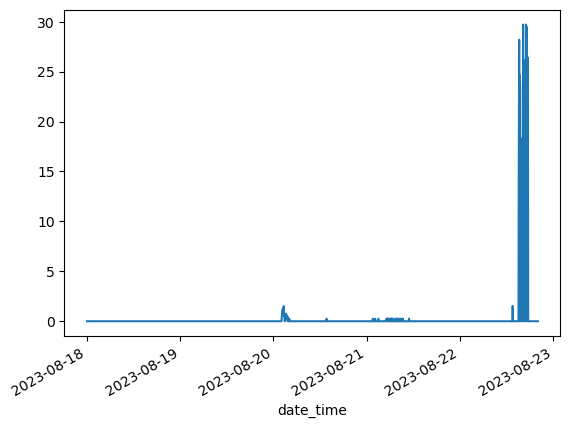

 86%|████████▌ | 1836/2131 [2:25:46<27:21,  5.57s/it]

QC passed, flag = 0


 86%|████████▌ | 1837/2131 [2:26:03<44:48,  9.14s/it]

QC passed, flag = 0


 86%|████████▋ | 1838/2131 [2:26:05<33:17,  6.82s/it]

QC passed, flag = 0


 86%|████████▋ | 1839/2131 [2:26:23<50:31, 10.38s/it]

QC passed, flag = 0


 86%|████████▋ | 1840/2131 [2:26:29<43:31,  8.97s/it]

QC passed, flag = 0


 86%|████████▋ | 1841/2131 [2:26:31<32:59,  6.83s/it]

QC passed, flag = 0


 86%|████████▋ | 1842/2131 [2:26:32<24:43,  5.13s/it]

QC passed, flag = 0


 86%|████████▋ | 1843/2131 [2:26:36<23:11,  4.83s/it]

QC passed, flag = 0


 87%|████████▋ | 1844/2131 [2:26:51<37:21,  7.81s/it]

QC passed, flag = 0


 87%|████████▋ | 1845/2131 [2:26:59<37:27,  7.86s/it]

QC passed, flag = 0


 87%|████████▋ | 1846/2131 [2:27:00<27:15,  5.74s/it]

QC passed, flag = 0


 87%|████████▋ | 1847/2131 [2:27:01<21:00,  4.44s/it]

QC passed, flag = 0


 87%|████████▋ | 1848/2131 [2:27:14<32:44,  6.94s/it]

QC passed, flag = 0


 87%|████████▋ | 1849/2131 [2:27:17<27:32,  5.86s/it]

QC passed, flag = 0


 87%|████████▋ | 1850/2131 [2:27:19<21:19,  4.55s/it]

QC passed, flag = 0


 87%|████████▋ | 1851/2131 [2:27:32<33:57,  7.28s/it]

QC passed, flag = 0


 87%|████████▋ | 1852/2131 [2:27:37<30:02,  6.46s/it]

QC passed, flag = 0


 87%|████████▋ | 1853/2131 [2:27:38<22:47,  4.92s/it]

QC passed, flag = 0


 87%|████████▋ | 1854/2131 [2:27:42<21:43,  4.70s/it]

QC passed, flag = 0


 87%|████████▋ | 1855/2131 [2:27:46<20:51,  4.53s/it]

QC passed, flag = 0


 87%|████████▋ | 1856/2131 [2:27:51<21:14,  4.63s/it]

QC passed, flag = 0


 87%|████████▋ | 1857/2131 [2:28:08<37:54,  8.30s/it]

QC passed, flag = 0


 87%|████████▋ | 1858/2131 [2:28:23<47:02, 10.34s/it]

QC passed, flag = 0


 87%|████████▋ | 1859/2131 [2:28:25<34:56,  7.71s/it]

QC passed, flag = 0


 87%|████████▋ | 1860/2131 [2:28:30<30:51,  6.83s/it]

QC passed, flag = 0


 87%|████████▋ | 1861/2131 [2:28:47<44:55,  9.98s/it]

QC passed, flag = 0


 87%|████████▋ | 1862/2131 [2:28:48<33:16,  7.42s/it]

QC passed, flag = 0


 87%|████████▋ | 1863/2131 [2:28:53<28:50,  6.46s/it]

QC passed, flag = 0


 87%|████████▋ | 1864/2131 [2:29:00<30:02,  6.75s/it]

QC passed, flag = 0


 88%|████████▊ | 1865/2131 [2:29:02<23:52,  5.39s/it]

QC passed, flag = 0


 88%|████████▊ | 1866/2131 [2:29:36<1:01:06, 13.83s/it]

QC passed, flag = 0


 88%|████████▊ | 1867/2131 [2:29:36<43:06,  9.80s/it]  

QC passed, flag = 0
QC fail with flag: 1 - not hourly


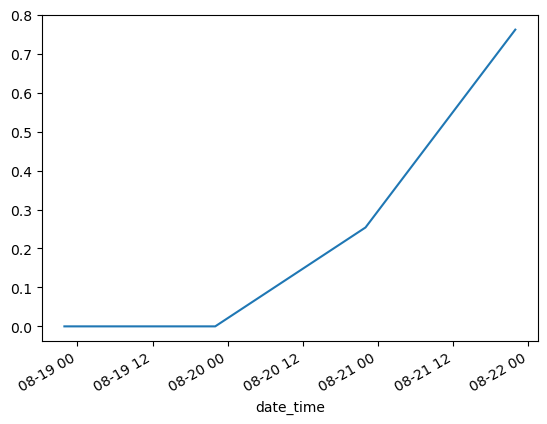

 88%|████████▊ | 1869/2131 [2:29:37<21:47,  4.99s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


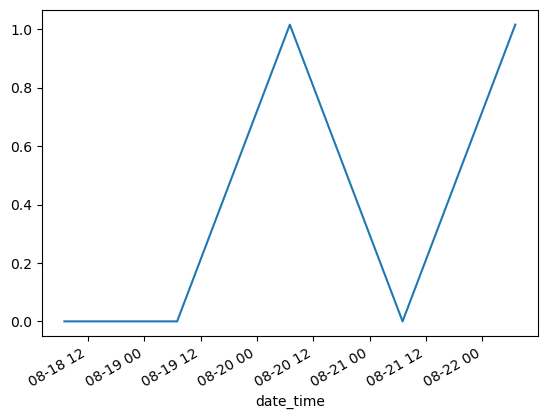

 88%|████████▊ | 1870/2131 [2:29:37<15:25,  3.55s/it]

QC fail with flag: 1 - not hourly


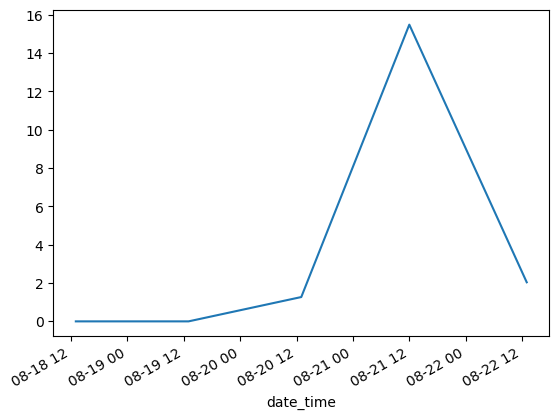

 88%|████████▊ | 1872/2131 [2:29:43<15:00,  3.48s/it]

QC passed, flag = 0


 88%|████████▊ | 1873/2131 [2:29:58<30:07,  7.01s/it]

QC passed, flag = 0


 88%|████████▊ | 1874/2131 [2:30:15<42:14,  9.86s/it]

QC passed, flag = 0


 88%|████████▊ | 1875/2131 [2:30:19<35:06,  8.23s/it]

QC passed, flag = 0


 88%|████████▊ | 1876/2131 [2:30:20<25:29,  6.00s/it]

QC passed, flag = 0


 88%|████████▊ | 1877/2131 [2:30:20<18:08,  4.29s/it]

QC passed, flag = 0


 88%|████████▊ | 1879/2131 [2:30:21<09:15,  2.20s/it]

QC passed, flag = 0
QC passed, flag = 0


 88%|████████▊ | 1881/2131 [2:30:21<05:07,  1.23s/it]

QC passed, flag = 0
QC passed, flag = 0
QC passed, flag = 0


 88%|████████▊ | 1883/2131 [2:30:35<14:46,  3.57s/it]

QC passed, flag = 0


 88%|████████▊ | 1884/2131 [2:30:49<24:08,  5.86s/it]

QC passed, flag = 0


 88%|████████▊ | 1885/2131 [2:31:53<1:21:25, 19.86s/it]

QC passed, flag = 0


 89%|████████▊ | 1886/2131 [2:32:09<1:16:42, 18.79s/it]

QC passed, flag = 0


 89%|████████▊ | 1887/2131 [2:32:14<1:01:11, 15.05s/it]

QC passed, flag = 0


 89%|████████▊ | 1888/2131 [2:32:28<59:43, 14.75s/it]  

QC passed, flag = 0


 89%|████████▊ | 1889/2131 [2:32:40<56:43, 14.07s/it]

QC passed, flag = 0


 89%|████████▊ | 1890/2131 [2:32:44<45:15, 11.27s/it]

QC passed, flag = 0


 89%|████████▊ | 1891/2131 [2:32:48<36:52,  9.22s/it]

QC passed, flag = 0


 89%|████████▉ | 1892/2131 [2:33:03<43:09, 10.84s/it]

QC passed, flag = 0


 89%|████████▉ | 1893/2131 [2:33:18<47:53, 12.07s/it]

QC passed, flag = 0


 89%|████████▉ | 1894/2131 [2:33:24<39:49, 10.08s/it]

QC passed, flag = 0


 89%|████████▉ | 1895/2131 [2:33:28<33:21,  8.48s/it]

QC passed, flag = 0


 89%|████████▉ | 1896/2131 [2:33:43<40:39, 10.38s/it]

QC passed, flag = 0


 89%|████████▉ | 1897/2131 [2:33:49<35:14,  9.04s/it]

QC passed, flag = 0


 89%|████████▉ | 1898/2131 [2:33:55<31:43,  8.17s/it]

QC passed, flag = 0


 89%|████████▉ | 1899/2131 [2:34:02<30:04,  7.78s/it]

QC passed, flag = 0


 89%|████████▉ | 1900/2131 [2:34:20<41:19, 10.73s/it]

QC passed, flag = 0


 89%|████████▉ | 1901/2131 [2:34:35<46:20, 12.09s/it]

QC passed, flag = 0


 89%|████████▉ | 1902/2131 [2:34:38<35:20,  9.26s/it]

QC passed, flag = 0


 89%|████████▉ | 1903/2131 [2:34:39<26:19,  6.93s/it]

QC passed, flag = 0


 89%|████████▉ | 1904/2131 [2:34:43<22:37,  5.98s/it]

QC passed, flag = 0


 89%|████████▉ | 1905/2131 [2:34:44<17:25,  4.63s/it]

QC passed, flag = 0


 89%|████████▉ | 1906/2131 [2:34:46<13:40,  3.65s/it]

QC passed, flag = 0


 89%|████████▉ | 1907/2131 [2:34:47<11:19,  3.03s/it]

QC passed, flag = 0


 90%|████████▉ | 1908/2131 [2:34:48<09:10,  2.47s/it]

QC passed, flag = 0


 90%|████████▉ | 1909/2131 [2:34:50<07:42,  2.08s/it]

QC passed, flag = 0


 90%|████████▉ | 1910/2131 [2:34:51<06:39,  1.81s/it]

QC passed, flag = 0


 90%|████████▉ | 1911/2131 [2:34:52<05:49,  1.59s/it]

QC passed, flag = 0


 90%|████████▉ | 1912/2131 [2:34:53<05:13,  1.43s/it]

QC passed, flag = 0


 90%|████████▉ | 1913/2131 [2:34:57<08:02,  2.21s/it]

QC passed, flag = 0


 90%|████████▉ | 1914/2131 [2:34:58<06:55,  1.91s/it]

QC passed, flag = 0


 90%|████████▉ | 1915/2131 [2:34:59<06:04,  1.69s/it]

QC passed, flag = 0


 90%|████████▉ | 1916/2131 [2:35:00<05:28,  1.53s/it]

QC passed, flag = 0


 90%|████████▉ | 1917/2131 [2:35:02<05:03,  1.42s/it]

QC passed, flag = 0


 90%|█████████ | 1918/2131 [2:35:07<08:47,  2.47s/it]

QC passed, flag = 0


 90%|█████████ | 1919/2131 [2:35:21<21:51,  6.19s/it]

QC passed, flag = 0


 90%|█████████ | 1920/2131 [2:35:23<16:32,  4.70s/it]

QC passed, flag = 0


 90%|█████████ | 1921/2131 [2:35:28<16:36,  4.75s/it]

QC passed, flag = 0


 90%|█████████ | 1922/2131 [2:35:29<12:44,  3.66s/it]

QC passed, flag = 0


 90%|█████████ | 1923/2131 [2:35:33<13:36,  3.93s/it]

QC passed, flag = 0


 90%|█████████ | 1924/2131 [2:35:37<13:25,  3.89s/it]

QC passed, flag = 0


 90%|█████████ | 1925/2131 [2:35:38<10:33,  3.07s/it]

QC passed, flag = 0


 90%|█████████ | 1926/2131 [2:35:44<13:12,  3.87s/it]

QC passed, flag = 0


 90%|█████████ | 1927/2131 [2:35:45<10:49,  3.19s/it]

QC passed, flag = 0


 90%|█████████ | 1928/2131 [2:36:01<22:57,  6.79s/it]

QC passed, flag = 0


 91%|█████████ | 1929/2131 [2:36:02<17:29,  5.20s/it]

QC passed, flag = 0


 91%|█████████ | 1930/2131 [2:36:03<13:19,  3.98s/it]

QC passed, flag = 0


 91%|█████████ | 1931/2131 [2:36:10<16:04,  4.82s/it]

QC passed, flag = 0


 91%|█████████ | 1932/2131 [2:36:15<16:26,  4.96s/it]

QC passed, flag = 0


 91%|█████████ | 1933/2131 [2:36:29<24:37,  7.46s/it]

QC passed, flag = 0


 91%|█████████ | 1934/2131 [2:36:30<18:39,  5.68s/it]

QC passed, flag = 0


 91%|█████████ | 1935/2131 [2:36:37<19:54,  6.10s/it]

QC passed, flag = 0


 91%|█████████ | 1936/2131 [2:36:44<20:05,  6.18s/it]

QC passed, flag = 0


 91%|█████████ | 1937/2131 [2:36:50<20:25,  6.32s/it]

QC passed, flag = 0


 91%|█████████ | 1938/2131 [2:37:05<28:24,  8.83s/it]

QC passed, flag = 0


 91%|█████████ | 1939/2131 [2:37:06<21:03,  6.58s/it]

QC passed, flag = 0


 91%|█████████ | 1940/2131 [2:37:07<15:49,  4.97s/it]

QC passed, flag = 0


 91%|█████████ | 1941/2131 [2:37:23<25:30,  8.05s/it]

QC passed, flag = 0


 91%|█████████ | 1942/2131 [2:37:27<22:03,  7.00s/it]

QC passed, flag = 0


 91%|█████████ | 1943/2131 [2:37:34<21:42,  6.93s/it]

QC passed, flag = 0


 91%|█████████ | 1944/2131 [2:37:38<19:15,  6.18s/it]

QC passed, flag = 0


 91%|█████████▏| 1945/2131 [2:37:43<17:42,  5.71s/it]

QC passed, flag = 0


 91%|█████████▏| 1946/2131 [2:37:57<24:51,  8.06s/it]

QC passed, flag = 0


 91%|█████████▏| 1947/2131 [2:37:58<18:33,  6.05s/it]

QC passed, flag = 0


 91%|█████████▏| 1948/2131 [2:38:03<17:10,  5.63s/it]

QC passed, flag = 0


 91%|█████████▏| 1949/2131 [2:38:17<24:42,  8.15s/it]

QC passed, flag = 0


 92%|█████████▏| 1950/2131 [2:38:30<29:33,  9.80s/it]

QC passed, flag = 0


 92%|█████████▏| 1952/2131 [2:38:31<14:51,  4.98s/it]

QC passed, flag = 0
QC passed, flag = 0


 92%|█████████▏| 1953/2131 [2:38:31<10:26,  3.52s/it]

QC passed, flag = 0


 92%|█████████▏| 1955/2131 [2:38:32<05:26,  1.86s/it]

QC passed, flag = 0
QC passed, flag = 0


 92%|█████████▏| 1957/2131 [2:38:32<02:48,  1.03it/s]

QC passed, flag = 0
QC passed, flag = 0
QC fail with flag: 1 - not hourly


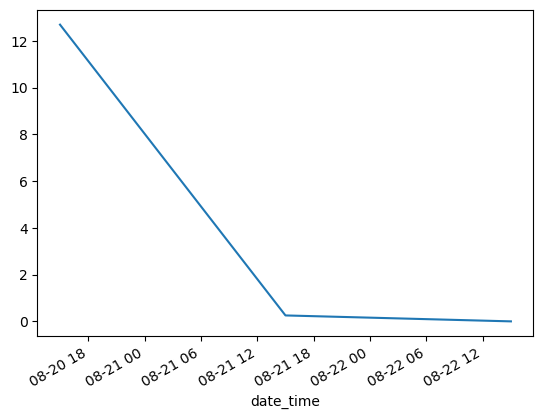

 92%|█████████▏| 1959/2131 [2:38:37<05:45,  2.01s/it]

QC passed, flag = 0


 92%|█████████▏| 1960/2131 [2:38:43<09:21,  3.29s/it]

QC passed, flag = 0


 92%|█████████▏| 1962/2131 [2:38:48<07:14,  2.57s/it]

QC passed, flag = 0
QC passed, flag = 0


 92%|█████████▏| 1963/2131 [2:38:48<05:10,  1.85s/it]

QC passed, flag = 0


 92%|█████████▏| 1964/2131 [2:38:49<04:38,  1.67s/it]

QC passed, flag = 0


 92%|█████████▏| 1965/2131 [2:38:50<03:48,  1.38s/it]

QC passed, flag = 0


 92%|█████████▏| 1966/2131 [2:38:53<05:17,  1.92s/it]

QC passed, flag = 0


 92%|█████████▏| 1967/2131 [2:39:08<15:36,  5.71s/it]

QC passed, flag = 0


 92%|█████████▏| 1968/2131 [2:39:22<22:06,  8.14s/it]

QC passed, flag = 0


 92%|█████████▏| 1969/2131 [2:39:27<19:59,  7.41s/it]

QC passed, flag = 0


 92%|█████████▏| 1970/2131 [2:39:32<17:25,  6.49s/it]

QC passed, flag = 0


 92%|█████████▏| 1971/2131 [2:39:46<23:46,  8.92s/it]

QC passed, flag = 0


 93%|█████████▎| 1972/2131 [2:39:51<20:40,  7.80s/it]

QC passed, flag = 0


 93%|█████████▎| 1973/2131 [2:39:57<18:46,  7.13s/it]

QC passed, flag = 0


 93%|█████████▎| 1974/2131 [2:40:11<24:21,  9.31s/it]

QC passed, flag = 0


 93%|█████████▎| 1975/2131 [2:40:32<32:42, 12.58s/it]

QC passed, flag = 0


 93%|█████████▎| 1976/2131 [2:40:38<27:54, 10.80s/it]

QC passed, flag = 0


 93%|█████████▎| 1977/2131 [2:40:43<23:25,  9.13s/it]

QC passed, flag = 0


 93%|█████████▎| 1978/2131 [2:40:44<16:37,  6.52s/it]

QC passed, flag = 0


 93%|█████████▎| 1979/2131 [2:40:59<22:40,  8.95s/it]

QC passed, flag = 0


 93%|█████████▎| 1980/2131 [2:41:12<26:00, 10.33s/it]

QC passed, flag = 0


 93%|█████████▎| 1981/2131 [2:41:17<21:49,  8.73s/it]

QC passed, flag = 0


 93%|█████████▎| 1982/2131 [2:41:18<16:11,  6.52s/it]

QC passed, flag = 0


 93%|█████████▎| 1983/2131 [2:41:23<14:24,  5.84s/it]

QC passed, flag = 0


 93%|█████████▎| 1984/2131 [2:41:30<15:08,  6.18s/it]

QC passed, flag = 0


 93%|█████████▎| 1985/2131 [2:41:34<13:51,  5.70s/it]

QC passed, flag = 0


 93%|█████████▎| 1986/2131 [2:41:49<20:21,  8.42s/it]

QC passed, flag = 0


 93%|█████████▎| 1987/2131 [2:42:04<24:36, 10.25s/it]

QC passed, flag = 0


 93%|█████████▎| 1988/2131 [2:42:18<27:34, 11.57s/it]

QC passed, flag = 0


 93%|█████████▎| 1989/2131 [2:42:21<21:10,  8.94s/it]

QC passed, flag = 0


 93%|█████████▎| 1990/2131 [2:42:22<15:34,  6.63s/it]

QC passed, flag = 0


 93%|█████████▎| 1991/2131 [2:42:23<11:38,  4.99s/it]

QC passed, flag = 0


 93%|█████████▎| 1992/2131 [2:42:25<08:53,  3.84s/it]

QC passed, flag = 0


 94%|█████████▎| 1993/2131 [2:42:26<07:02,  3.06s/it]

QC passed, flag = 0


 94%|█████████▎| 1994/2131 [2:42:27<05:44,  2.51s/it]

QC passed, flag = 0


 94%|█████████▎| 1995/2131 [2:42:28<04:48,  2.12s/it]

QC passed, flag = 0


 94%|█████████▎| 1996/2131 [2:42:29<04:08,  1.84s/it]

QC passed, flag = 0


 94%|█████████▎| 1997/2131 [2:42:31<03:40,  1.64s/it]

QC passed, flag = 0


 94%|█████████▍| 1998/2131 [2:42:32<03:18,  1.49s/it]

QC passed, flag = 0


 94%|█████████▍| 1999/2131 [2:42:36<05:16,  2.40s/it]

QC passed, flag = 0


 94%|█████████▍| 2000/2131 [2:42:37<04:24,  2.02s/it]

QC passed, flag = 0


 94%|█████████▍| 2001/2131 [2:42:39<03:55,  1.81s/it]

QC passed, flag = 0


 94%|█████████▍| 2002/2131 [2:42:40<03:27,  1.61s/it]

QC passed, flag = 0


 94%|█████████▍| 2003/2131 [2:42:41<03:10,  1.49s/it]

QC passed, flag = 0


 94%|█████████▍| 2004/2131 [2:42:42<02:58,  1.40s/it]

QC passed, flag = 0


 94%|█████████▍| 2005/2131 [2:42:43<02:47,  1.33s/it]

QC passed, flag = 0


 94%|█████████▍| 2006/2131 [2:42:45<02:47,  1.34s/it]

QC passed, flag = 0


 94%|█████████▍| 2007/2131 [2:42:46<02:42,  1.31s/it]

QC passed, flag = 0


 94%|█████████▍| 2008/2131 [2:42:47<02:35,  1.27s/it]

QC passed, flag = 0


 94%|█████████▍| 2009/2131 [2:42:48<02:27,  1.21s/it]

QC passed, flag = 0


 94%|█████████▍| 2010/2131 [2:42:52<04:09,  2.06s/it]

QC passed, flag = 0


 94%|█████████▍| 2011/2131 [2:43:08<12:29,  6.24s/it]

QC passed, flag = 0


 94%|█████████▍| 2012/2131 [2:43:10<09:39,  4.87s/it]

QC passed, flag = 0


 94%|█████████▍| 2013/2131 [2:43:11<07:20,  3.74s/it]

QC passed, flag = 0


 95%|█████████▍| 2014/2131 [2:43:12<05:50,  2.99s/it]

QC passed, flag = 0


 95%|█████████▍| 2015/2131 [2:43:19<07:49,  4.05s/it]

QC passed, flag = 0


 95%|█████████▍| 2016/2131 [2:43:25<09:04,  4.74s/it]

QC passed, flag = 0


 95%|█████████▍| 2017/2131 [2:43:33<10:47,  5.68s/it]

QC passed, flag = 0


 95%|█████████▍| 2018/2131 [2:43:39<10:57,  5.82s/it]

QC passed, flag = 0


 95%|█████████▍| 2019/2131 [2:43:53<15:24,  8.26s/it]

QC passed, flag = 0


 95%|█████████▍| 2020/2131 [2:44:09<19:38, 10.62s/it]

QC passed, flag = 0


 95%|█████████▍| 2021/2131 [2:44:18<18:35, 10.14s/it]

QC passed, flag = 0


 95%|█████████▍| 2022/2131 [2:44:22<14:44,  8.11s/it]

QC passed, flag = 0


 95%|█████████▍| 2023/2131 [2:44:23<11:07,  6.18s/it]

QC passed, flag = 0


 95%|█████████▍| 2024/2131 [2:44:27<09:49,  5.51s/it]

QC passed, flag = 0


 95%|█████████▌| 2025/2131 [2:45:21<35:06, 19.87s/it]

QC passed, flag = 0


 95%|█████████▌| 2026/2131 [2:45:28<28:10, 16.10s/it]

QC passed, flag = 0


 95%|█████████▌| 2027/2131 [2:45:39<25:20, 14.62s/it]

QC passed, flag = 0


 95%|█████████▌| 2028/2131 [2:45:53<24:52, 14.49s/it]

QC passed, flag = 0


 95%|█████████▌| 2029/2131 [2:45:55<17:54, 10.54s/it]

QC passed, flag = 0


 95%|█████████▌| 2030/2131 [2:46:08<19:23, 11.52s/it]

QC passed, flag = 0


 95%|█████████▌| 2031/2131 [2:46:13<15:43,  9.44s/it]

QC passed, flag = 0


 95%|█████████▌| 2032/2131 [2:46:17<12:52,  7.80s/it]

QC passed, flag = 0


 95%|█████████▌| 2033/2131 [2:46:21<10:54,  6.68s/it]

QC passed, flag = 0


 95%|█████████▌| 2034/2131 [2:46:25<09:29,  5.87s/it]

QC passed, flag = 0


 95%|█████████▌| 2035/2131 [2:46:29<08:36,  5.38s/it]

QC passed, flag = 0


 96%|█████████▌| 2036/2131 [2:46:31<06:34,  4.15s/it]

QC passed, flag = 0


 96%|█████████▌| 2037/2131 [2:46:31<04:44,  3.03s/it]

QC passed, flag = 0


 96%|█████████▌| 2038/2131 [2:46:32<03:46,  2.44s/it]

QC passed, flag = 0


 96%|█████████▌| 2039/2131 [2:46:36<04:34,  2.98s/it]

QC passed, flag = 0


 96%|█████████▌| 2040/2131 [2:46:41<05:08,  3.39s/it]

QC passed, flag = 0


 96%|█████████▌| 2041/2131 [2:46:42<04:06,  2.74s/it]

QC passed, flag = 0


 96%|█████████▌| 2042/2131 [2:47:00<10:48,  7.29s/it]

QC passed, flag = 0


 96%|█████████▌| 2043/2131 [2:47:06<10:15,  6.99s/it]

QC passed, flag = 0


 96%|█████████▌| 2044/2131 [2:47:11<09:14,  6.37s/it]

QC passed, flag = 0


 96%|█████████▌| 2045/2131 [2:47:23<11:37,  8.11s/it]

QC passed, flag = 0


 96%|█████████▌| 2046/2131 [2:47:39<14:46, 10.43s/it]

QC passed, flag = 0


 96%|█████████▌| 2047/2131 [2:47:56<17:15, 12.32s/it]

QC passed, flag = 0


 96%|█████████▌| 2048/2131 [2:48:03<14:48, 10.70s/it]

QC passed, flag = 0


 96%|█████████▌| 2049/2131 [2:48:07<12:04,  8.84s/it]

QC passed, flag = 0


 96%|█████████▌| 2050/2131 [2:48:13<10:31,  7.80s/it]

QC passed, flag = 0


 96%|█████████▌| 2051/2131 [2:48:17<08:58,  6.74s/it]

QC passed, flag = 0


 96%|█████████▋| 2052/2131 [2:48:30<11:36,  8.81s/it]

QC passed, flag = 0


 96%|█████████▋| 2053/2131 [2:48:31<08:11,  6.31s/it]

QC passed, flag = 0


 96%|█████████▋| 2054/2131 [2:48:49<12:29,  9.74s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


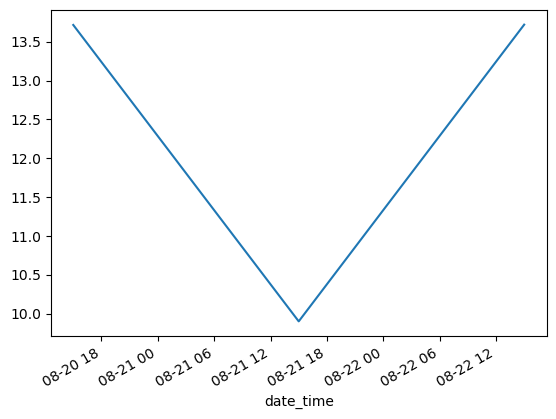

 96%|█████████▋| 2055/2131 [2:48:49<08:46,  6.92s/it]

QC fail with flag: 1 - not hourly


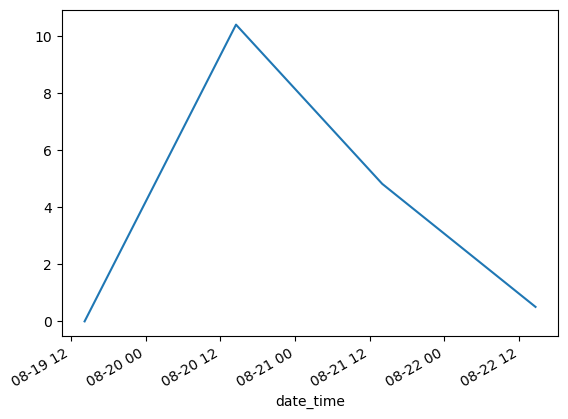

 96%|█████████▋| 2056/2131 [2:48:49<06:07,  4.90s/it]

QC fail with flag: 1 - not hourly


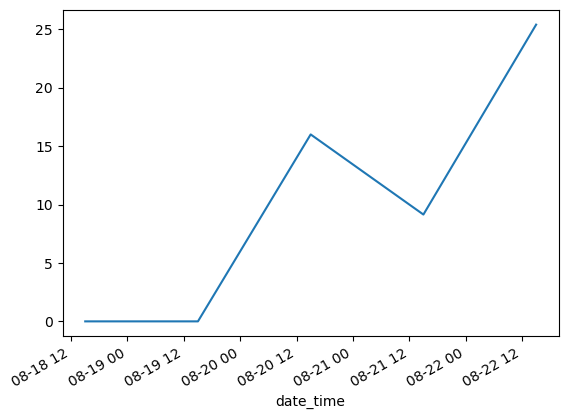

 97%|█████████▋| 2058/2131 [2:48:50<03:06,  2.56s/it]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


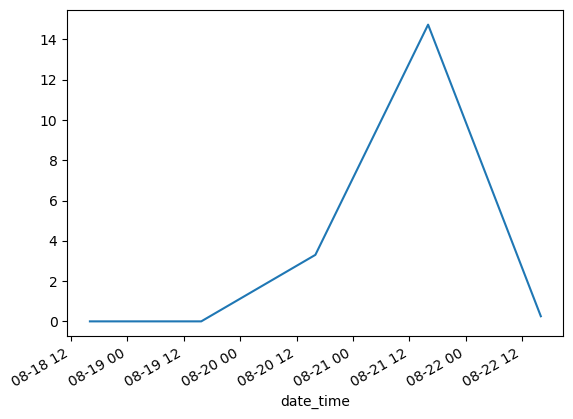

 97%|█████████▋| 2061/2131 [2:48:50<01:10,  1.01s/it]

QC passed, flag = 0
QC passed, flag = 0


 97%|█████████▋| 2062/2131 [2:48:51<00:51,  1.35it/s]

QC passed, flag = 0


 97%|█████████▋| 2063/2131 [2:48:51<00:39,  1.73it/s]

QC passed, flag = 0
QC fail with flag: 1 - not hourly


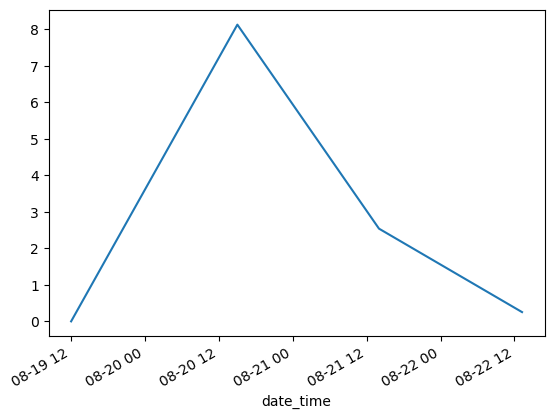

 97%|█████████▋| 2065/2131 [2:48:55<01:46,  1.61s/it]

QC passed, flag = 0


 97%|█████████▋| 2066/2131 [2:49:00<02:55,  2.70s/it]

QC passed, flag = 0


 97%|█████████▋| 2067/2131 [2:49:15<06:41,  6.27s/it]

QC passed, flag = 0


 97%|█████████▋| 2068/2131 [2:49:29<09:01,  8.59s/it]

QC passed, flag = 0


 97%|█████████▋| 2069/2131 [2:49:29<06:21,  6.15s/it]

QC passed, flag = 0


 97%|█████████▋| 2070/2131 [2:49:30<04:27,  4.38s/it]

QC passed, flag = 0


 97%|█████████▋| 2071/2131 [2:49:30<03:09,  3.15s/it]

QC passed, flag = 0


 97%|█████████▋| 2072/2131 [2:49:30<02:14,  2.28s/it]

QC passed, flag = 0


 97%|█████████▋| 2073/2131 [2:49:32<01:58,  2.05s/it]

QC passed, flag = 0


 97%|█████████▋| 2074/2131 [2:49:33<01:44,  1.84s/it]

QC passed, flag = 0


 97%|█████████▋| 2075/2131 [2:49:36<02:02,  2.18s/it]

QC passed, flag = 0


 97%|█████████▋| 2076/2131 [2:49:38<01:59,  2.18s/it]

QC passed, flag = 0


 97%|█████████▋| 2077/2131 [2:49:39<01:35,  1.77s/it]

QC passed, flag = 0


 98%|█████████▊| 2078/2131 [2:49:40<01:16,  1.45s/it]

QC passed, flag = 0


 98%|█████████▊| 2079/2131 [2:49:41<01:11,  1.37s/it]

QC passed, flag = 0


 98%|█████████▊| 2080/2131 [2:49:46<02:09,  2.54s/it]

QC passed, flag = 0


 98%|█████████▊| 2081/2131 [2:49:47<01:37,  1.94s/it]

QC passed, flag = 0


 98%|█████████▊| 2082/2131 [2:49:50<01:58,  2.42s/it]

QC passed, flag = 0


 98%|█████████▊| 2083/2131 [2:49:53<01:59,  2.50s/it]

QC passed, flag = 0


 98%|█████████▊| 2084/2131 [2:49:56<02:04,  2.65s/it]

QC passed, flag = 0


 98%|█████████▊| 2085/2131 [2:49:57<01:42,  2.23s/it]

QC passed, flag = 0


 98%|█████████▊| 2086/2131 [2:49:58<01:22,  1.84s/it]

QC passed, flag = 0


 98%|█████████▊| 2087/2131 [2:49:59<01:12,  1.66s/it]

QC passed, flag = 0


 98%|█████████▊| 2088/2131 [2:50:01<01:05,  1.51s/it]

QC passed, flag = 0


 98%|█████████▊| 2089/2131 [2:50:05<01:39,  2.37s/it]

QC passed, flag = 0


 98%|█████████▊| 2090/2131 [2:50:06<01:23,  2.03s/it]

QC passed, flag = 0


 98%|█████████▊| 2091/2131 [2:50:07<01:08,  1.70s/it]

QC passed, flag = 0


 98%|█████████▊| 2092/2131 [2:50:12<01:38,  2.53s/it]

QC passed, flag = 0


 98%|█████████▊| 2093/2131 [2:50:12<01:13,  1.93s/it]

QC passed, flag = 0


 98%|█████████▊| 2094/2131 [2:50:13<00:54,  1.48s/it]

QC passed, flag = 0


 98%|█████████▊| 2095/2131 [2:50:14<00:49,  1.38s/it]

QC passed, flag = 0


 98%|█████████▊| 2096/2131 [2:50:31<03:39,  6.27s/it]

QC passed, flag = 0


 98%|█████████▊| 2097/2131 [2:50:35<03:09,  5.58s/it]

QC passed, flag = 0


 98%|█████████▊| 2098/2131 [2:50:39<02:48,  5.11s/it]

QC passed, flag = 0


 98%|█████████▊| 2099/2131 [2:50:54<04:16,  8.03s/it]

QC passed, flag = 0


 99%|█████████▊| 2100/2131 [2:51:08<05:04,  9.81s/it]

QC passed, flag = 0


 99%|█████████▊| 2101/2131 [2:51:22<05:29, 10.99s/it]

QC passed, flag = 0


 99%|█████████▊| 2102/2131 [2:51:38<06:03, 12.55s/it]

QC passed, flag = 0


 99%|█████████▊| 2103/2131 [2:51:43<04:45, 10.18s/it]

QC passed, flag = 0


 99%|█████████▊| 2104/2131 [2:51:44<03:23,  7.54s/it]

QC passed, flag = 0


 99%|█████████▉| 2105/2131 [2:51:50<03:03,  7.07s/it]

QC passed, flag = 0


 99%|█████████▉| 2106/2131 [2:52:04<03:46,  9.04s/it]

QC passed, flag = 0


 99%|█████████▉| 2107/2131 [2:52:20<04:25, 11.06s/it]

QC passed, flag = 0


 99%|█████████▉| 2108/2131 [2:52:24<03:28,  9.08s/it]

QC passed, flag = 0


 99%|█████████▉| 2109/2131 [2:52:29<02:50,  7.74s/it]

QC passed, flag = 0


 99%|█████████▉| 2110/2131 [2:52:33<02:22,  6.79s/it]

QC passed, flag = 0


 99%|█████████▉| 2111/2131 [2:52:37<02:00,  6.00s/it]

QC passed, flag = 0


 99%|█████████▉| 2112/2131 [2:52:39<01:27,  4.60s/it]

QC passed, flag = 0


 99%|█████████▉| 2113/2131 [2:52:54<02:18,  7.70s/it]

QC passed, flag = 0


 99%|█████████▉| 2114/2131 [2:53:01<02:07,  7.48s/it]

QC passed, flag = 0


 99%|█████████▉| 2115/2131 [2:53:15<02:31,  9.44s/it]

QC passed, flag = 0


 99%|█████████▉| 2116/2131 [2:53:29<02:42, 10.81s/it]

QC passed, flag = 0


 99%|█████████▉| 2117/2131 [2:53:38<02:23, 10.28s/it]

QC passed, flag = 0


 99%|█████████▉| 2118/2131 [2:53:51<02:26, 11.28s/it]

QC passed, flag = 0


 99%|█████████▉| 2119/2131 [2:54:05<02:25, 12.14s/it]

QC passed, flag = 0


 99%|█████████▉| 2120/2131 [2:54:07<01:38,  8.95s/it]

QC passed, flag = 0


100%|█████████▉| 2121/2131 [2:54:11<01:16,  7.64s/it]

QC passed, flag = 0


100%|█████████▉| 2122/2131 [2:54:26<01:26,  9.65s/it]

QC passed, flag = 0


100%|█████████▉| 2123/2131 [2:54:27<00:57,  7.22s/it]

QC passed, flag = 0


100%|█████████▉| 2124/2131 [2:54:42<01:05,  9.30s/it]

QC passed, flag = 0


100%|█████████▉| 2125/2131 [2:54:56<01:04, 10.74s/it]

QC passed, flag = 0


100%|█████████▉| 2126/2131 [2:55:09<00:57, 11.48s/it]

QC passed, flag = 0


100%|█████████▉| 2127/2131 [2:55:14<00:37,  9.47s/it]

QC passed, flag = 0


100%|█████████▉| 2128/2131 [2:55:27<00:32, 10.77s/it]

QC passed, flag = 0


100%|█████████▉| 2129/2131 [2:55:42<00:23, 11.81s/it]

QC passed, flag = 0


100%|█████████▉| 2130/2131 [2:55:43<00:08,  8.72s/it]

QC passed, flag = 0


100%|██████████| 2131/2131 [2:55:50<00:00,  4.95s/it]

QC passed, flag = 0


In [9]:
# set up dataframe to store gauge information/metrics
df_all = pd.DataFrame(columns=['STID','Name','Network','Latitude','Longitude',
                               'Storm_Total','Max_Intensity','QC'])
# set up dictionary to store gauge data
resampled_data_dict = {}

# loop through each station
for i in trange(len(station_list)):
    # get station info
    station = station_list[i]                                       # select station
    stid = station['STID']                                          # station ID
    name = station['NAME']                                          # station name
    lat = float(station['LATITUDE'])                                # latutude
    lon = float(station['LONGITUDE'])                               # longitude
    mnet_id = int(station['MNET_ID'])                               # mesonet ID
    network = netids['Name'].loc[netids['ID'] == mnet_id].values[0] # network, from mesonet ID

    # resample to hourly
    df_raw = pd.DataFrame.from_dict(station['OBSERVATIONS'])
    datetimes_raw = df_raw['date_time']
    precip_raw = df_raw['precip_intervals_set_1d']
    df_resampled = resample_qc.resample(precip_raw, datetimes_raw)

    # find maximum hourlt intensity and total storm accumulation
    maximum = df_resampled.max()
    total = precip_raw.sum()

    # quality control
    qc_flag = resample_qc.quality_control(
        precip_raw, datetimes_raw, 
        PFDS=using_atlas14,
        PFDS_folder=atlas14_path, 
        lat=lat, lon=lon)
    
    # store station info to dataframe
    df_all.loc[i] = [stid, name, network, lat, lon, total, maximum, qc_flag]
    # store resampled hourly data to dictionary 
    resampled_data_dict[stid] = df_resampled

### always good to check the data

In [12]:
# take a look at the stations that passed quality control
df_all[df_all['QC']==0].sort_values(by='Storm_Total')

,STID,Name,Network,Latitude,Longitude,Storm_Total,Max_Intensity,QC
1611,COOPWVIC1,WATSONVILLE WATERWORKS,COOPAB,36.93080,-121.76910,0.254,0.000000,1
1076,HOTC1,HOLLISTER RANCH #70,CNRFC,34.46770,-120.34020,0.254,0.038100,1
1219,COOPCYMC1,NEW CUYAMA FIRE STATION,COOPAB,34.94550,-119.68270,0.254,0.010583,1
1387,SHAC1,SHANDON,CNRFC,35.65639,-120.38083,0.254,0.028486,1
1340,COOPBAFC1,BAKERSFIELD 5 NW,COOPC,35.41860,-119.05080,0.508,0.019728,1
1525,COOPPNMC1,PINNACLES NATIONAL PARK,COOPA,36.48190,-121.18220,1.016,0.042333,1
1867,COOPHMBC1,HALF MOON BAY,COOPA,37.47250,-122.44330,1.016,0.031861,1
1102,SDNC1,SUDDEN PEAK,CNRFC,34.56694,-120.49861,1.016,0.099934,1
1783,RSOC1,RANCHO SAN ANTONIO PARK,CNRFC,37.33000,-122.11806,1.016,0.000000,1
5,MAVC1,MARRON VALLEY,CNRFC,32.57611,-116.78667,1.016,0.193524,1


In [ ]:
# take a look at the stations that did NOT pass quality control
df_all[df_all['QC']!=0].sort_values(by='Storm_Total')

### save the results!

You can save the gauge information dataframe, but note that this does not contain the hourly gauge data, just the accumulations and max intensities. Below is also code for creating and saving a netCDF file, which stores gauge information (such as station ID, location, network, and QC flag), along with the resampled hourly data. 

In [14]:
# save information dataframe, if desired
df_all.to_csv('gauge_info_df.csv')

In [ ]:
# set up data to save to netCDF
hourly_data = []

start_dt = datetime.strptime(start, '%Y%m%d%H%M')
end_dt = datetime.strptime(end, '%Y%m%d%H%M')
time_array = np.arange(start_dt, end_dt, dtype='datetime64[h]')

for i in df_all.index:
    stid = df_all['STID'].loc[i]

    precip_resample = resampled_data_dict[stid].copy()
    precip_resample.index = precip_resample.index.values.astype('datetime64[h]')
    precip_resample_reindex = precip_resample.reindex(time_array)
    precip_resample_vals = precip_resample_reindex.values
    hourly_data.append(precip_resample_vals)

In [ ]:
# put station data and information into an xarray dataset
ds = xr.Dataset(
    data_vars=dict(
        precip_int=(['station', 'time'], hourly_data),
        total=(['station'], df_all['Storm_Total'].values),
        maximum=(['station'], df_all['Max_Intensity'].values),
        network=(['station'], df_all['Network'].values ),
        qc_flag=(['station'], df_all['QC'].values )
    ),
    coords=dict(
        station = df_all['STID'].values,
        time=time_array,
        lon=('station', df_all['Longitude'].values),
        lat=('station', df_all['Latitude'].values),
    ),
)

In [ ]:
# save dataset to netCDF file
ds.to_netcdf('mesowest_gaugedata_hourly.nc')